<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools
import patsy
import statsmodels.api as sm
import pylab
from collections import Counter
from scipy.stats import kendalltau
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, Lasso, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Ridge, RidgeClassifierCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.datasets import make_imbalance
from imblearn.ensemble import BalancedBaggingClassifier, BalanceCascade
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTETomek

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
random.seed(42)
np_seed = np.random.RandomState(42)

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# A:
### Load and filter out non-residential listings ###

# Load the data
house = pd.read_csv('./housing.csv')

# Obtain non-residential properties first
    # Based on the data dictionary, there are only 3 non-residential types
        # 'A-Agriculture', 'C-Commerical' and 'I-Industrial'
    # We shall remove rows with these values - A, C, I in feature: 'MSZoning'
    # Nonetheless, check for the unique values in 'house' first

print(house['MSZoning'].unique())
    # ['RL' 'RM' 'C (all)' 'FV' 'RH']
    # Clearly, this indicates that the data dictionary is a general guide or requires updating
    # We shall only have to drop 'C (all)'

res_mask = house['MSZoning'] != 'C (all)'
house_res = house[res_mask]

print(house_res['MSZoning'].unique())
    # ['RL' 'RM' 'FV' 'RH']

['RL' 'RM' 'C (all)' 'FV' 'RH']
['RL' 'RM' 'FV' 'RH']


## Overview of the approach

#### [1] Perform some high level overview of the data <br />
- df.info(), df.describe(include='all'), df.head(), df.shape

#### [2] Cleaning, dropping and interpolations <br />
- df.dropna(), df.drop(mask), df.fillna() <br />
- Standardisation: (x_i's - np.mean(x_i's)) / np.std(x_i's)

#### [3] Visualisation of data <br />
- Distribution/box-whisker/swarm plots of each feature <br />
    - Identify outliers if any
    - Check if normal or not
- Scatter Pair-plot (for multicollinearity) between the explanatory variables - x_i's <br />
    - if > 5 features, better to do a correlation heatmap for better visualisation
- Scatter/Line Pair-plots in relation to explained variable - y's <br />

#### [4] Least squares regression checks
###### For unbiased estimators
- Zero conditional mean E[e|X] == 0: Residuals on average == 0 <br />
- Pair-wise/auxillary regressions between the x_i's - Multicollinearity <br />
    - In linear algebra, this means a [n,K] matrix X has rank K
    - There must not be perfect collinearity; as proxy, CORR(x_i, x_j) == +/-0.7 might still be acceptable   
###### For BLUE (Best Linear Unbiased Estimators) efficient estimates  <br />
- Uncorrelated errors / no serial correlation <br />
- Homoskedasticity of the x_i's residuals
###### Not critical/required for unbiased/BLUE estimators but good to have <br />
- Normality in the errors - residuals <br />
    - Essential when constructing the critical region for the test statistics
    - However, the estimators' distributions (B_i's) are more crucial where we want them to be normal, else the t-test is inaccurate
        - By CLT, the sample means of the estimators are normal

In [3]:
### [1] CLEANING ###
# 1.1 Checking the shape of data and noting down those with null values

# Reset the index of the dataframe
house_res.reset_index(inplace=True)
house_res.drop(['index'], axis='columns', inplace=True)

print('Shape of data: ', house_res.shape, '\n')
    # With 81 columns, we break them into batchs of 7 features per '.describe'
    
print(house_res.info())
    # Data with nulls:
    # LotFrontage, Alley, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2,
    # Electrical, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature

Shape of data:  (1450, 81) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null objec

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
# 1.2 Verifying whether 'NaN's are caused by default strings like 'NA' or empty fields

# To check that 'NA' values have been inserted as str(NA) rather than a complete empty field,
# set 'keep_default_na'=False in 'pd.read_csv()'

na_test = pd.read_csv('./housing.csv', keep_default_na=False)
na_test.info()
    # There are completely no 'empty' values - signifies that 'NA' in the data has been prefilled and pandas detects it
    # and converts them all to 'NaN's

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

In [5]:
# 1.3 Checking for correct dtypes for each feature

# Printing out '.describe()' and '.head()' to inspect the data better
bat_slice = 0

for batch in range(np.round(house_res.shape[1] / 7).astype('int64')):
        # Note: np.round goes for the nearest value
    print(house_res.iloc[:, bat_slice:(batch+1)*7].head())
    print('**********************************************************************************************************')
    print((house_res.iloc[:, bat_slice:(batch+1)*7]).describe(include='all'))
    bat_slice += 7
    
    # Print next batch of 7 columns
    print('##########################################################################################################')
    
# There are 33 (including ID not listed in data dictionary) int/float features, 5 date features-recorded as int/float,
# a total of 38 int/float features which is verified against the data dictionary

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley
0   1          60       RL         65.0     8450   Pave   NaN
1   2          20       RL         80.0     9600   Pave   NaN
2   3          60       RL         68.0    11250   Pave   NaN
3   4          70       RL         60.0     9550   Pave   NaN
4   5          60       RL         84.0    14260   Pave   NaN
**********************************************************************************************************
                 Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1450.000000  1450.000000     1450  1191.000000    1450.000000   1450   
unique          NaN          NaN        4          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1446   
mean     731.364138    56.903448      NaN    70.052897   10523.831724    NaN   
std      421.554345    42.265033      NaN

           FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
count   1450.000000  1450.000000   1450.000000   1450.000000        1450   
unique          NaN          NaN           NaN           NaN           4   
top             NaN          NaN           NaN           NaN          TA   
freq            NaN          NaN           NaN           NaN         727   
mean       1.568966     0.384828      2.870345      1.046207         NaN   
std        0.549549     0.503450      0.814645      0.219643         NaN   
min        0.000000     0.000000      0.000000      0.000000         NaN   
25%        1.000000     0.000000      2.000000      1.000000         NaN   
50%        2.000000     0.000000      3.000000      1.000000         NaN   
75%        2.000000     1.000000      3.000000      1.000000         NaN   
max        3.000000     2.000000      8.000000      3.000000         NaN   

        TotRmsAbvGrd Functional  
count    1450.000000       1450  
unique           Na

In [6]:
# 1.4 Sanity check on reasonable datetime values

# There are 5 datetime related features
    # 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt' 'MoSold' & 'YrSold' - Check whether these 5 features for oddity
date_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

# Odd min/max value check
house_res[date_cols].describe(include='all')
    # Nothing odd detected
    # May apply more detailed checks: YearRemodAdd/GarageYrBlt/MoSold/YrSold > YearBuilt in numeric value for each house

YearBuilt  YearRemodAdd  GarageYrBlt       MoSold       YrSold
count  1450.000000   1450.000000  1371.000000  1450.000000  1450.000000
mean   1971.593103   1985.049655  1978.627279     6.312414  2007.812414
std      30.022696     20.552319    24.592779     2.698244     1.326321
min    1872.000000   1950.000000  1906.000000     1.000000  2006.000000
25%    1954.000000   1967.000000  1961.500000     5.000000  2007.000000
50%    1973.000000   1994.000000  1980.000000     6.000000  2008.000000
75%    2001.000000   2004.000000  2002.000000     8.000000  2009.000000
max    2010.000000   2010.000000  2010.000000    12.000000  2010.000000

In [7]:
# 1.5.1 Filling data with 'NaN' values Part I

# Inspecting 'LotFrontage', there are 'NaN' values, therefore we should fill these as 0.0
    # The person managing the data probably had in mind that if a property is not even surrounded by streets, this
    # would be 'None' and '0' has little significance
        # i.e. a log-cabin in the middle of a forest, a house by the seaside...
house_res['LotFrontage'] = house_res['LotFrontage'].fillna(0.0)

# This problem is also seen in 'MasVnrArea', if there's None then perhaps '0' is inappropriate too but we shall fill them
# as zeroes too for analysis sake
house_res['MasVnrArea'] = house_res['MasVnrArea'].fillna(0.0)

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


count    1371.000000
mean     1978.627279
std        24.592779
min      1906.000000
25%      1961.500000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
count     596.000000
mean     2001.666107
std         5.134257
min      1990.000000
25%      1998.000000
50%      2003.000000
75%      2006.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda2\envs\tens

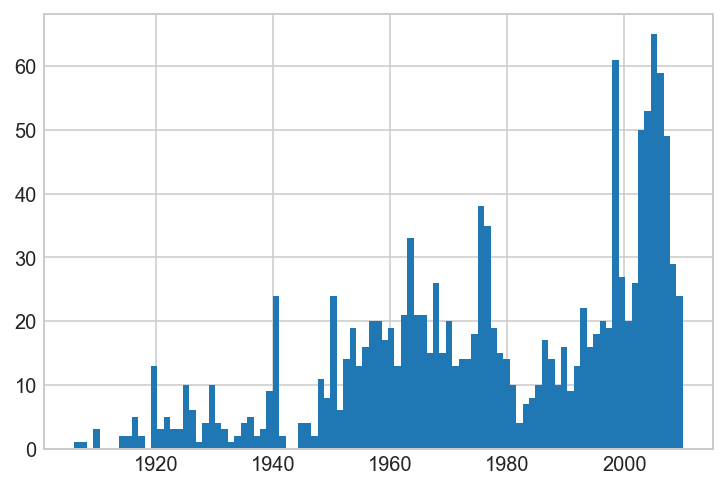

In [8]:
# 1.5.2 Filling data with 'NaN' values Part II

# Interesting features with missing values - 'Electrical' and 'GarageYrBlt'

# 'GarageYrBlt' - if there's no garage in the first place then it should rightly be none
# However we need to fill the empty spaces, perform brief EDA on this data to see what is the most appropriate
# date to fill it with

print(house_res['GarageYrBlt'].describe(include='all'))
    # Data stretches from 1906 to 2010 (95 years in between), we shall try 95 bins

# We can't plot using plt/sns immediately yet as the 'NaN's produces errors, therefore we drop them before plotting
# the empirical pdfs
gyb_no_nan = house_res['GarageYrBlt'].dropna(how='all')
_ = plt.hist(gyb_no_nan, bins=95)
    # It seems like the majority of garage construction spike during the millennium and at an exponential rate
    # We shall fill 'NaN' values with years starting from 2000

""" Ideally, we should be filling year according to the distr. from 1990s onwards but a random uniform draw is done here """
# Create mask to obtain 'mu', 'sigma' of the years if required/normal distribution draw was done instead
aft_1990 = house_res['GarageYrBlt'] >= 1990
print(house_res[aft_1990]['GarageYrBlt'].describe())

# Create function to fill 'GarageBltYr' empty values

def fit_garagebltyr(pdSr):
    """ Fill a reasonable garage built-year for those without.
    Year of garage built cannot be earlier than the property built """
        
    for idx, row in enumerate(pdSr):
        if pdSr[idx] == 99999:
            gen_year = np.round(random.choice(np.random.RandomState(42).uniform(1990, 2010, size=10000)))
            
            while house_res.ix[idx, 'YearBuilt'] > gen_year:
                gen_year = np.round(random.choice(np.random.RandomState(42).uniform(1990, 2010, size=10000)))

            pdSr[idx] = gen_year # This is a procedural function, thus there were no return values

# Perform filling of 'NaN' values
house_res['GarageYrBlt'] = house_res['GarageYrBlt'].fillna(99999)
    # Apparently the lambda function fails to catch 'np.nan', this intermediate step is a temp. solution
    
# Call on function to fill appropriate 'GarageYrBlt' values
fit_garagebltyr(house_res['GarageYrBlt'])
    # Uniform draw is used to prevent sharp peaking at any particular years

count    1450.000000
mean     1979.775172
std        24.426997
min      1906.000000
25%      1962.000000
50%      1985.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

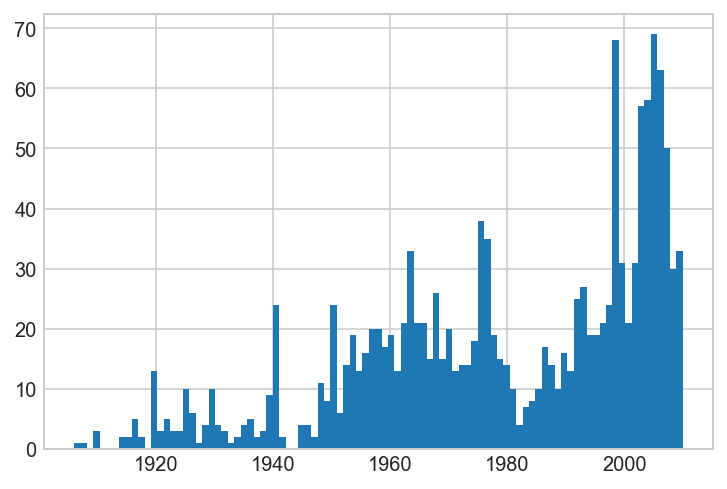

In [9]:
# Check how 'GarageYrBlt' looks like now
gyb_no_nan = house_res['GarageYrBlt']
_ = plt.hist(gyb_no_nan, bins=95)

# Check that no values exceeded 2010
house_res['GarageYrBlt'].describe()

In [10]:
# 1.5.3 Filling data with 'NaN' values Part III

# One unique missing value in 'Electrical'
    # Since this is just one odd 'NaN' out of 1450 obs., we shall just fill it using the majority class
print(house_res['Electrical'].value_counts())
    # 'SBrkr' appears to be the dominant class - 1328
    
# Fill with 'SBrkr'
house_res['Electrical'] = house_res['Electrical'].fillna('SBrkr')

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
# This was a backtracked check
    # Appaerently 'None' was read as it was literally, the null values belong to 'CBlock'!
house_res['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [12]:
# 1.5.4 Filling data with 'NaN' values Part IV

# For the rest of the 15 features with 'NaN', the feature simply does not exist - i.e. there was no garage in the house
    # Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2,
    # FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature

# Define a dictionary to fill these 'NaN's with something more meaningful for categorical analysis
fill_dict = {'Alley': 'NoAll',
            'MasVnrType': 'CBlock', # Replace from 'NoVnr' to 'CBlock'
            'BsmtQual': 'NoBsmt',
            'BsmtCond': 'NoBsmt',
            'BsmtExposure': 'NoBsmt',
            'BsmtFinType1': 'NoBsmt',
            'BsmtFinType2': 'NoBsmt',
            'FireplaceQu': 'NoFir',
            'GarageType': 'NoGar',
            'GarageFinish': 'NoGar',
            'GarageQual': 'NoGar',
            'GarageCond': 'NoGar',
            'PoolQC': 'NoPool',
            'Fence': 'NoFen',
            'MiscFeature': 'NoMisF'}

# Define list of columns with 'NaN's to be filled
fill_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

# Fill the 15 remaining columns
for column in fill_cols:
    house_res[column] = house_res[column].fillna(fill_dict[column])

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# 1.6 Check for any persisting 'NaN' values

house_res.info()
    # No more missing values!!!, data types are also correct/appropriate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non

In [14]:
# 1.7 Excluding datetime features, verify that the remaining 33 features have reasonable value ranges

# Int/Float features to check...
# Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, MAsVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF,
# 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr,
# TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea,
# MiscVal, SalePrice

int_float_ft = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                'PoolArea', 'MiscVal', 'SalePrice']

for feat in int_float_ft:
    print(house_res[feat].describe(include='all')) # "include='all'" in case we missed an object dtype
    print('##############################################################################################################')
        # No oddity found in the features that are of int64 or float64 type

count    1450.000000
mean      731.364138
std       421.554345
min         1.000000
25%       366.250000
50%       731.500000
75%      1096.750000
max      1460.000000
Name: Id, dtype: float64
##############################################################################################################
count    1450.000000
mean       56.903448
std        42.265033
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
##############################################################################################################
count    1450.00000
mean       57.54000
std        34.71992
min         0.00000
25%        41.25000
50%        63.00000
75%        79.00000
max       313.00000
Name: LotFrontage, dtype: float64
##############################################################################################################
count      1450.000000
mean      10523.831724
std       10012.185355
min       

In [15]:
# 1.8 Define what are fixed and variable features

# Features of the house that may be altered, controllable - variable
var_ft_c = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
          'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating',
          'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
          'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

# Features of the house that are demand driven, there is no control over - variable
var_ft_unc = ['MiscVal', 'SaleType', 'SaleCondition', 'SalePrice']
    # Buyers determine the price and how the transaction process is implemented

# Features which are fixed by contruction
fx_ft = [feat for feat in house_res.columns
          if (feat not in var_ft_c) and (feat not in var_ft_unc)]

# Remove artefact fixed feature - 'Id'
fx_ft = fx_ft[1:]

# Check whether the features are in their right places and the sum of all the features == 80
print(len(fx_ft), len(var_ft_c), len(var_ft_unc), 'Total features: ', len(fx_ft) + len(var_ft_c) + len(var_ft_unc), '\n')
print(fx_ft, '\n', var_ft_c, '\n', var_ft_unc)

47 29 4 Total features:  80 

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MoSold', 'YrSold'] 
 ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'Gar

In [16]:
# 1.9 Feature Processing - One-hot encode all categorical variables

# Categorical variables
cat_ft = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
         'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
         'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
         'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
         'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
         'MiscFeature', 'SaleType', 'SaleCondition', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
    # Datetime features were classified as categorical: 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'

# Create one-hot encoded dataframe for categorical features separately
onehot_df = pd.DataFrame()
for feat in cat_ft:
    onehot_df = pd.concat([onehot_df, pd.get_dummies(house_res[feat], prefix=feat, prefix_sep='_', drop_first=False)],
                          axis='columns')
        # We shall set 'drop_first'=False as some variables do not contain all the possible categories
        # i.e. 'ExterQual' had no 'Po' values to begin with

# pd.reset_option()
pd.set_option('max_info_columns', 1000)
pd.set_option('max_info_rows', 1000)

print('Shape: ', onehot_df.shape, '\n', '*******************************************')
onehot_df.info()

Shape:  (1450, 567) 
 *******************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 567 columns):
MSSubClass_20            uint8
MSSubClass_30            uint8
MSSubClass_40            uint8
MSSubClass_45            uint8
MSSubClass_50            uint8
MSSubClass_60            uint8
MSSubClass_70            uint8
MSSubClass_75            uint8
MSSubClass_80            uint8
MSSubClass_85            uint8
MSSubClass_90            uint8
MSSubClass_120           uint8
MSSubClass_160           uint8
MSSubClass_180           uint8
MSSubClass_190           uint8
MSZoning_FV              uint8
MSZoning_RH              uint8
MSZoning_RL              uint8
MSZoning_RM              uint8
Street_Grvl              uint8
Street_Pave              uint8
Alley_Grvl               uint8
Alley_NoAll              uint8
Alley_Pave               uint8
LotShape_IR1             uint8
LotShape_IR2             uint8
LotShape_IR3        

In [17]:
### [1] END OF CLEANING / CONCLUSION OF SECTION 1 ###
# End of cleaning: Merge 'onehot_df' to 'house_res' for analysis
# Residential dataframe that will be used for analysis from now on: 'resident'
resident = pd.concat([house_res, onehot_df], axis='columns')

# With the exception of 'MSSubClass', the other fixed categorical features contain string values
    # We shall recast this entire series' elements as strings
resident['MSSubClass'] = resident['MSSubClass'].apply(lambda x: str(x))

print(resident.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 648 columns):
Id                       int64
MSSubClass               object
MSZoning                 object
LotFrontage              float64
LotArea                  int64
Street                   object
Alley                    object
LotShape                 object
LandContour              object
Utilities                object
LotConfig                object
LandSlope                object
Neighborhood             object
Condition1               object
Condition2               object
BldgType                 object
HouseStyle               object
OverallQual              int64
OverallCond              int64
YearBuilt                int64
YearRemodAdd             int64
RoofStyle                object
RoofMatl                 object
Exterior1st              object
Exterior2nd              object
MasVnrType               object
MasVnrArea               float64
ExterQual                object


- Some variables created earlier to note during analysis:
    - Categorical variables: 'cat_ft'
    - Variable features - Controllable/Uncontrollable: 'var_ft_c'/'var_ft_unc'
    - Fixed features: 'fx_ft'
    - Datetime features: 'date_cols'
        - These are all the list of column names from the dataframe 'house_res'

In [18]:
### [2] EDA & FEATURE SELECTION ###

# Split data into before/2010 - Use pre 2010 data to predict 2010 data
resident_2010 = resident[resident['YrSold'] == 2010]
resident_pre2010 = resident[resident['YrSold'] != 2010]

- As defined earlier, there are 4 uncontrollable variable features, main variable of interest is 'SalePrice'
    - Establish relationship (if any) between 'SalePrice' and the other controllable fixed features
        - This will be further investigated in regression analysis, part 3

['Condition1', 'Alley', 'BsmtQual', 'Foundation', 'BldgType', 'BsmtExposure', 'Street', 'MiscFeature', 'LotConfig', 'Neighborhood', 'Utilities', 'LandSlope', 'LandContour', 'GarageType', 'MSZoning', 'HouseStyle', 'LotShape', 'Condition2', 'MSSubClass'] 
 No. of fixed-categoricals:  19


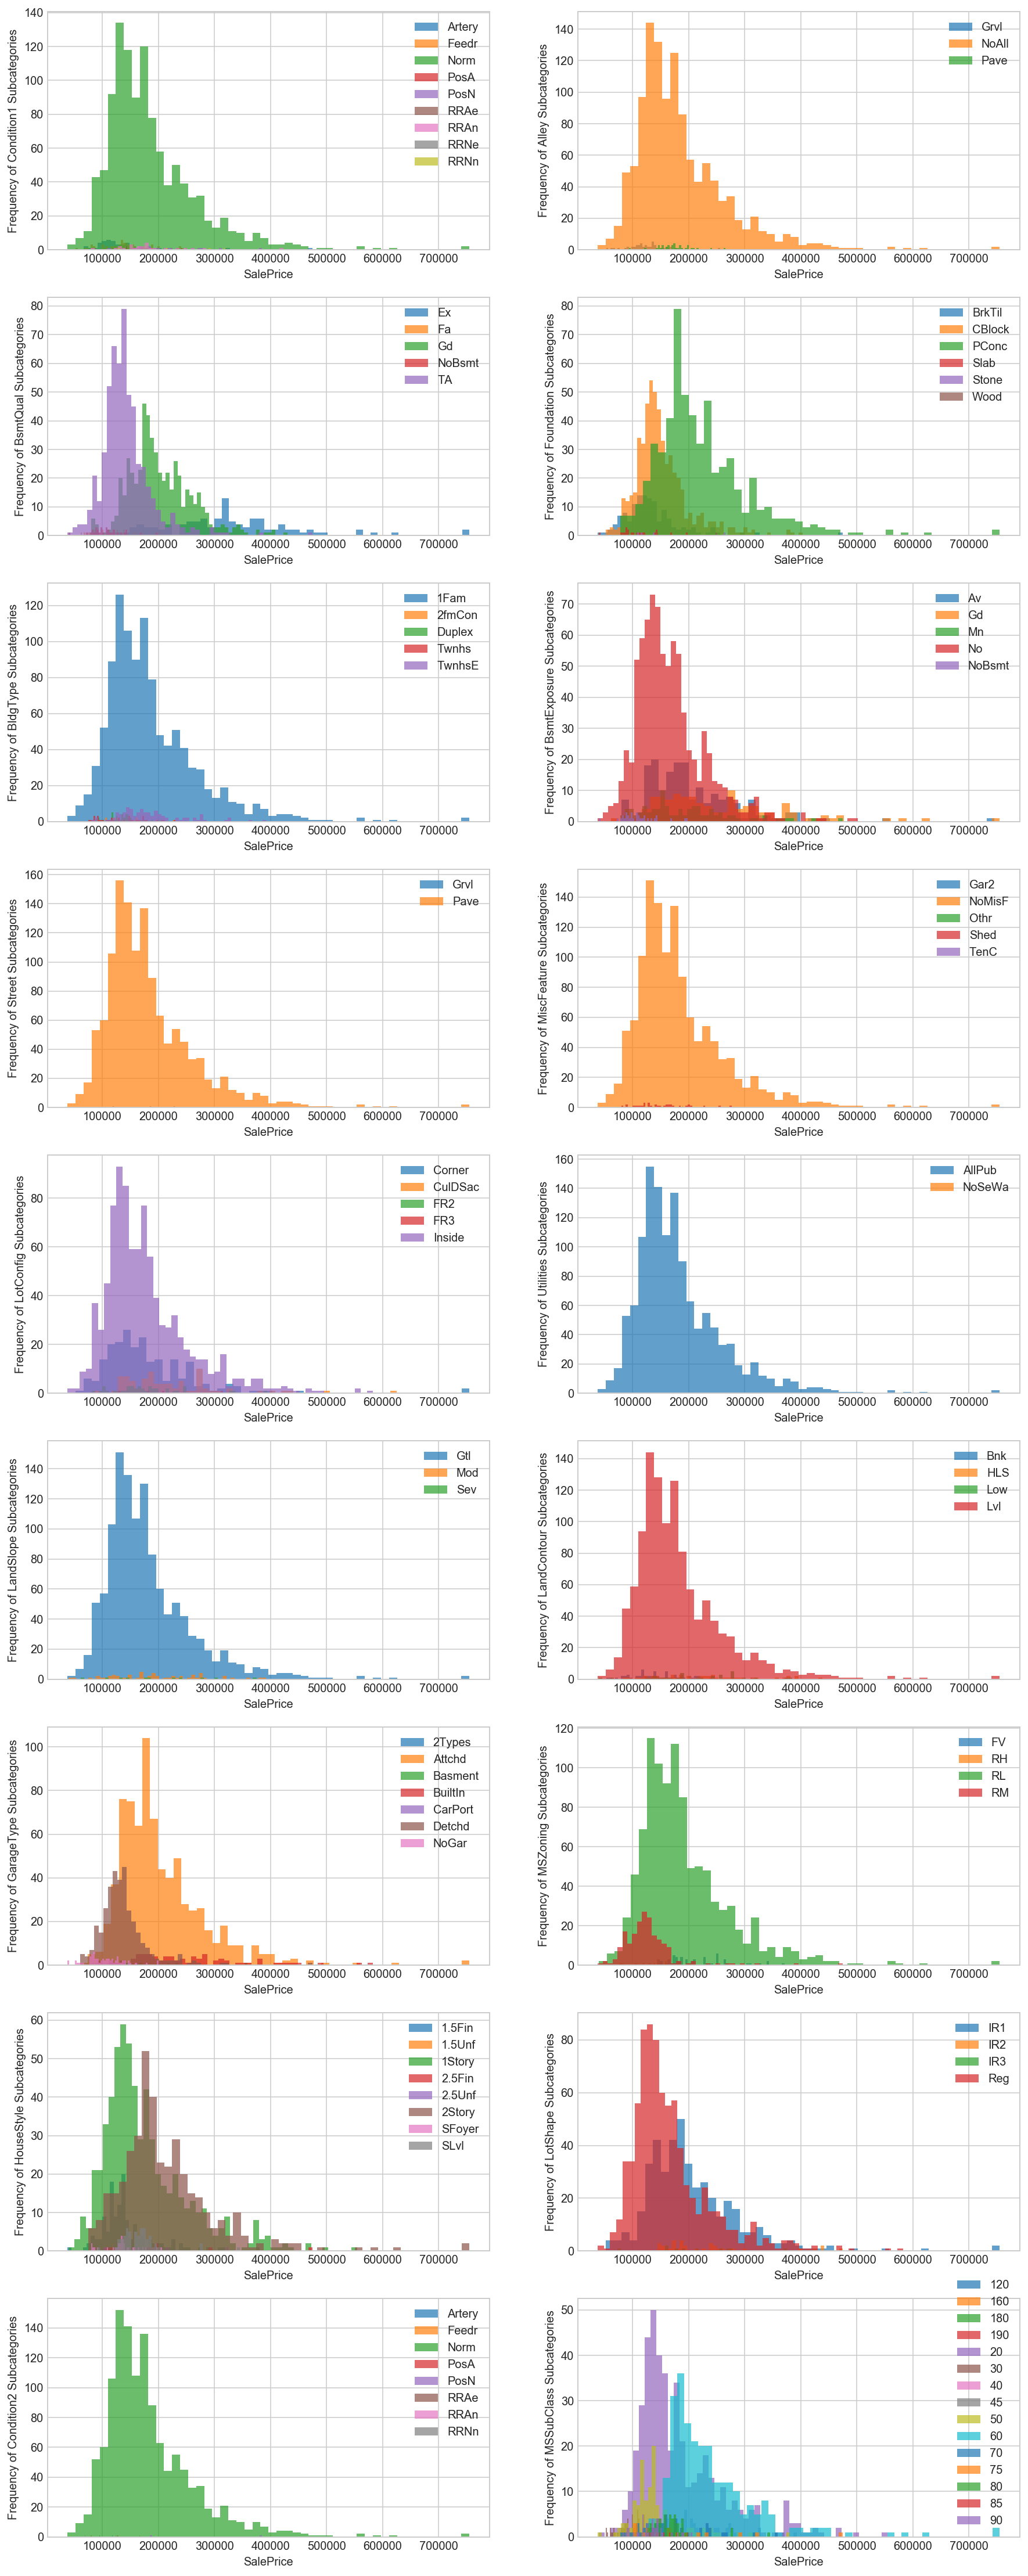

In [19]:
# 2.1.1 Categorical features
    # Plot histplots of 'SalePrice' grouped by each unique categorical fixed feature
    
# Obtain fixed and categorical variable list
fx_and_cat = list((set(fx_ft).intersection(set(cat_ft))).difference(set(date_cols)))
print(fx_and_cat, '\n', 'No. of fixed-categoricals: ', len(fx_and_cat)) # 19 in total

# Remove 'Neighborhood' for separate evaluation later
fxcat_lessneigh = [elem for elem in fx_and_cat if elem != 'Neighborhood']

# Examine histplots of the 'SalePrice' w.r.t. each of these fixed-categorical variables
_ = plt.figure(figsize=(15, 40))
for plot, var in enumerate(fxcat_lessneigh):
    _ = plt.subplot(9, 2, (plot+1))
    temp_df = resident_pre2010[['SalePrice', var]]
    temp_df_grouped = temp_df.groupby(by=var)
    temp_df_grouped['SalePrice'].plot(kind='hist', bins=50, alpha=0.7, legend='best')
    _ = plt.xlabel('SalePrice'); _ = plt.ylabel('Frequency of ' + var + ' Subcategories')

In [20]:
# 2.1.2 Narrowing down to suitable categorical variables for regression later
# Visually determined and likely varies across users

- Less interesting categorical variables
    - These are the variables that have the least difference within their subcategories and would not be useful in helping to predict differences if any OR the subcategories are highly imbalanced in representation
        - 'Condition1', 'Utilities', 'LandSlope', 'Street', 'BldgType', 'LandContour',
        - 'MiscFeature', 'Condition2', 'Alley'

- Features that need to have subcategories regrouped
    - These are those that have a mixture of subcategories that are either extremely significant or otherwise
    - Then, we shall group the insignificant subcategories together and specify which dummy features of the categories each should be used (the dominant ones)
        - [1] 'MSSubClass' - '20', '60', '50'
        - [2] 'GarageType' - 'Attchd', 'Detchd'
        - [3] 'MSZoning' - 'RM', 'RL'
        - [4] 'LotConfig' - 'Inside', 'Corner'
        - [5] 'Foundation' - (KIV for closer inspection)
        - [6] 'HouseStyle' - (KIV for closer inspection)
        - [7] 'LotShape' - 'IR1', 'Reg'
    
- Features used as it is, subcategories are relatively balanced or significant enough 'BsmtQual' & 'BsmtExposure'

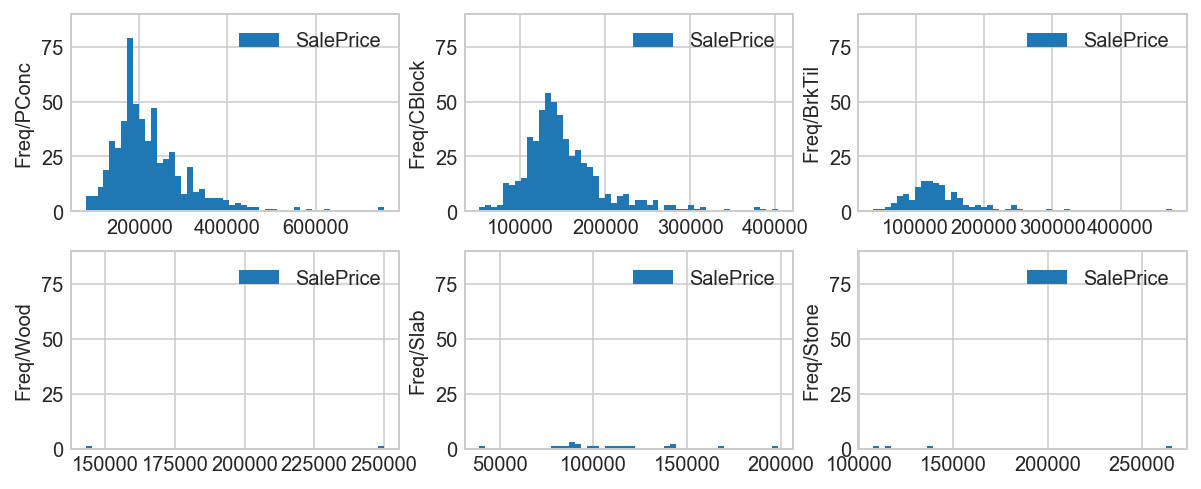

In [21]:
# 2.1.3.1 Plotting 'Foundation' in detail

# Create mask for subcategories of 'Foundation'
mask = list(resident_pre2010['Foundation'].unique())

_ = plt.figure(figsize=(10, 4))
for idx, sub in enumerate(mask):
    _ = plt.subplot(2, 3, (idx+1))
    temp_df = resident_pre2010[resident_pre2010['Foundation'] == sub][['SalePrice', 'Foundation']]
    temp_df['SalePrice'].plot(kind='hist', bins=50, legend='top', ylim=(0, 90))
    _ = plt.ylabel('Freq/'+sub)
    
# It seems for 'Foundation' we only need to specify - 'BrkTil', 'CBlock', 'PConc'

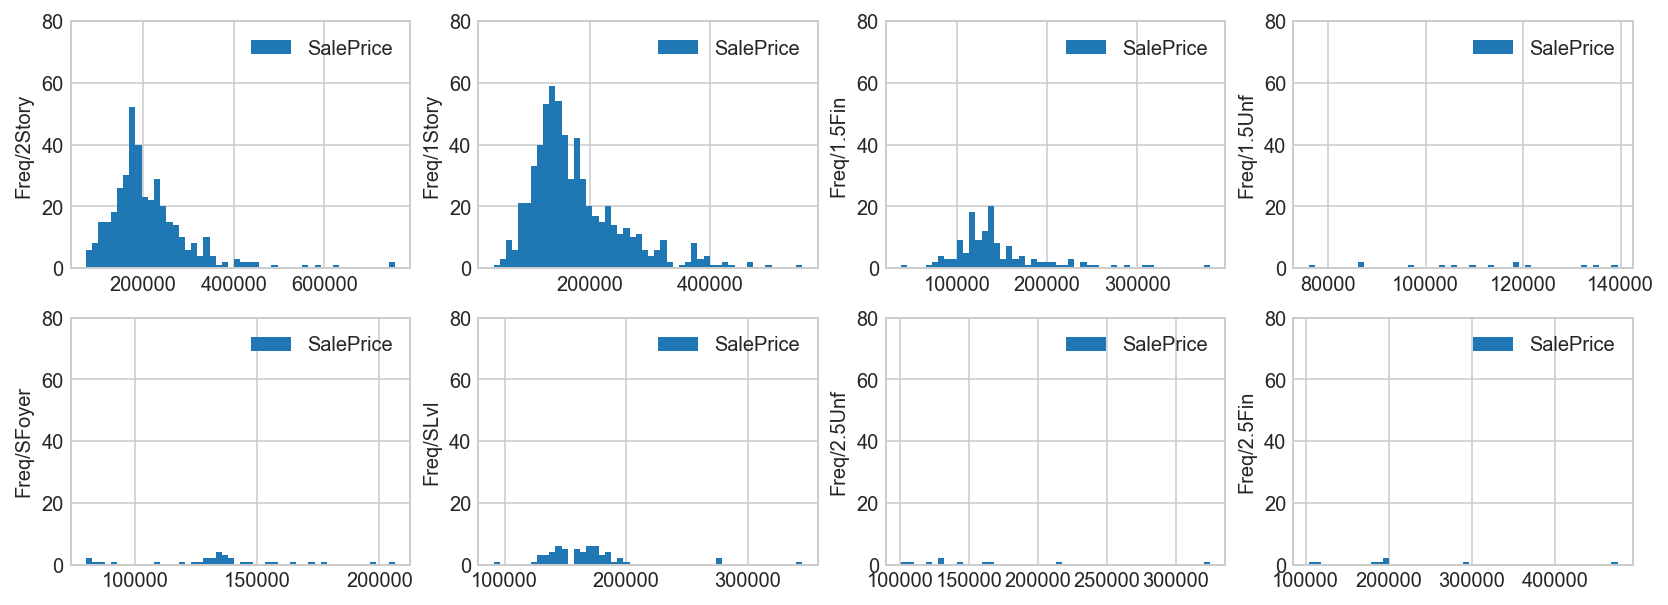

In [22]:
# 2.1.3.2 Plotting 'HouseStyle' in detail

# Create mask for subcategories of 'Foundation'
mask = list(resident_pre2010['HouseStyle'].unique())

_ = plt.figure(figsize=(14, 5))
for idx, sub in enumerate(mask):
    _ = plt.subplot(2, 4, (idx+1))
    temp_df = resident_pre2010[resident_pre2010['HouseStyle'] == sub][['SalePrice', 'HouseStyle']]
    temp_df['SalePrice'].plot(kind='hist', bins=50, legend='top right', ylim=(0, 80))
    _ = plt.ylabel('Freq/'+sub)
    
# It seems for 'HouseStyle' we only need to specify - '1.5Fin', '1Story', '2Story'

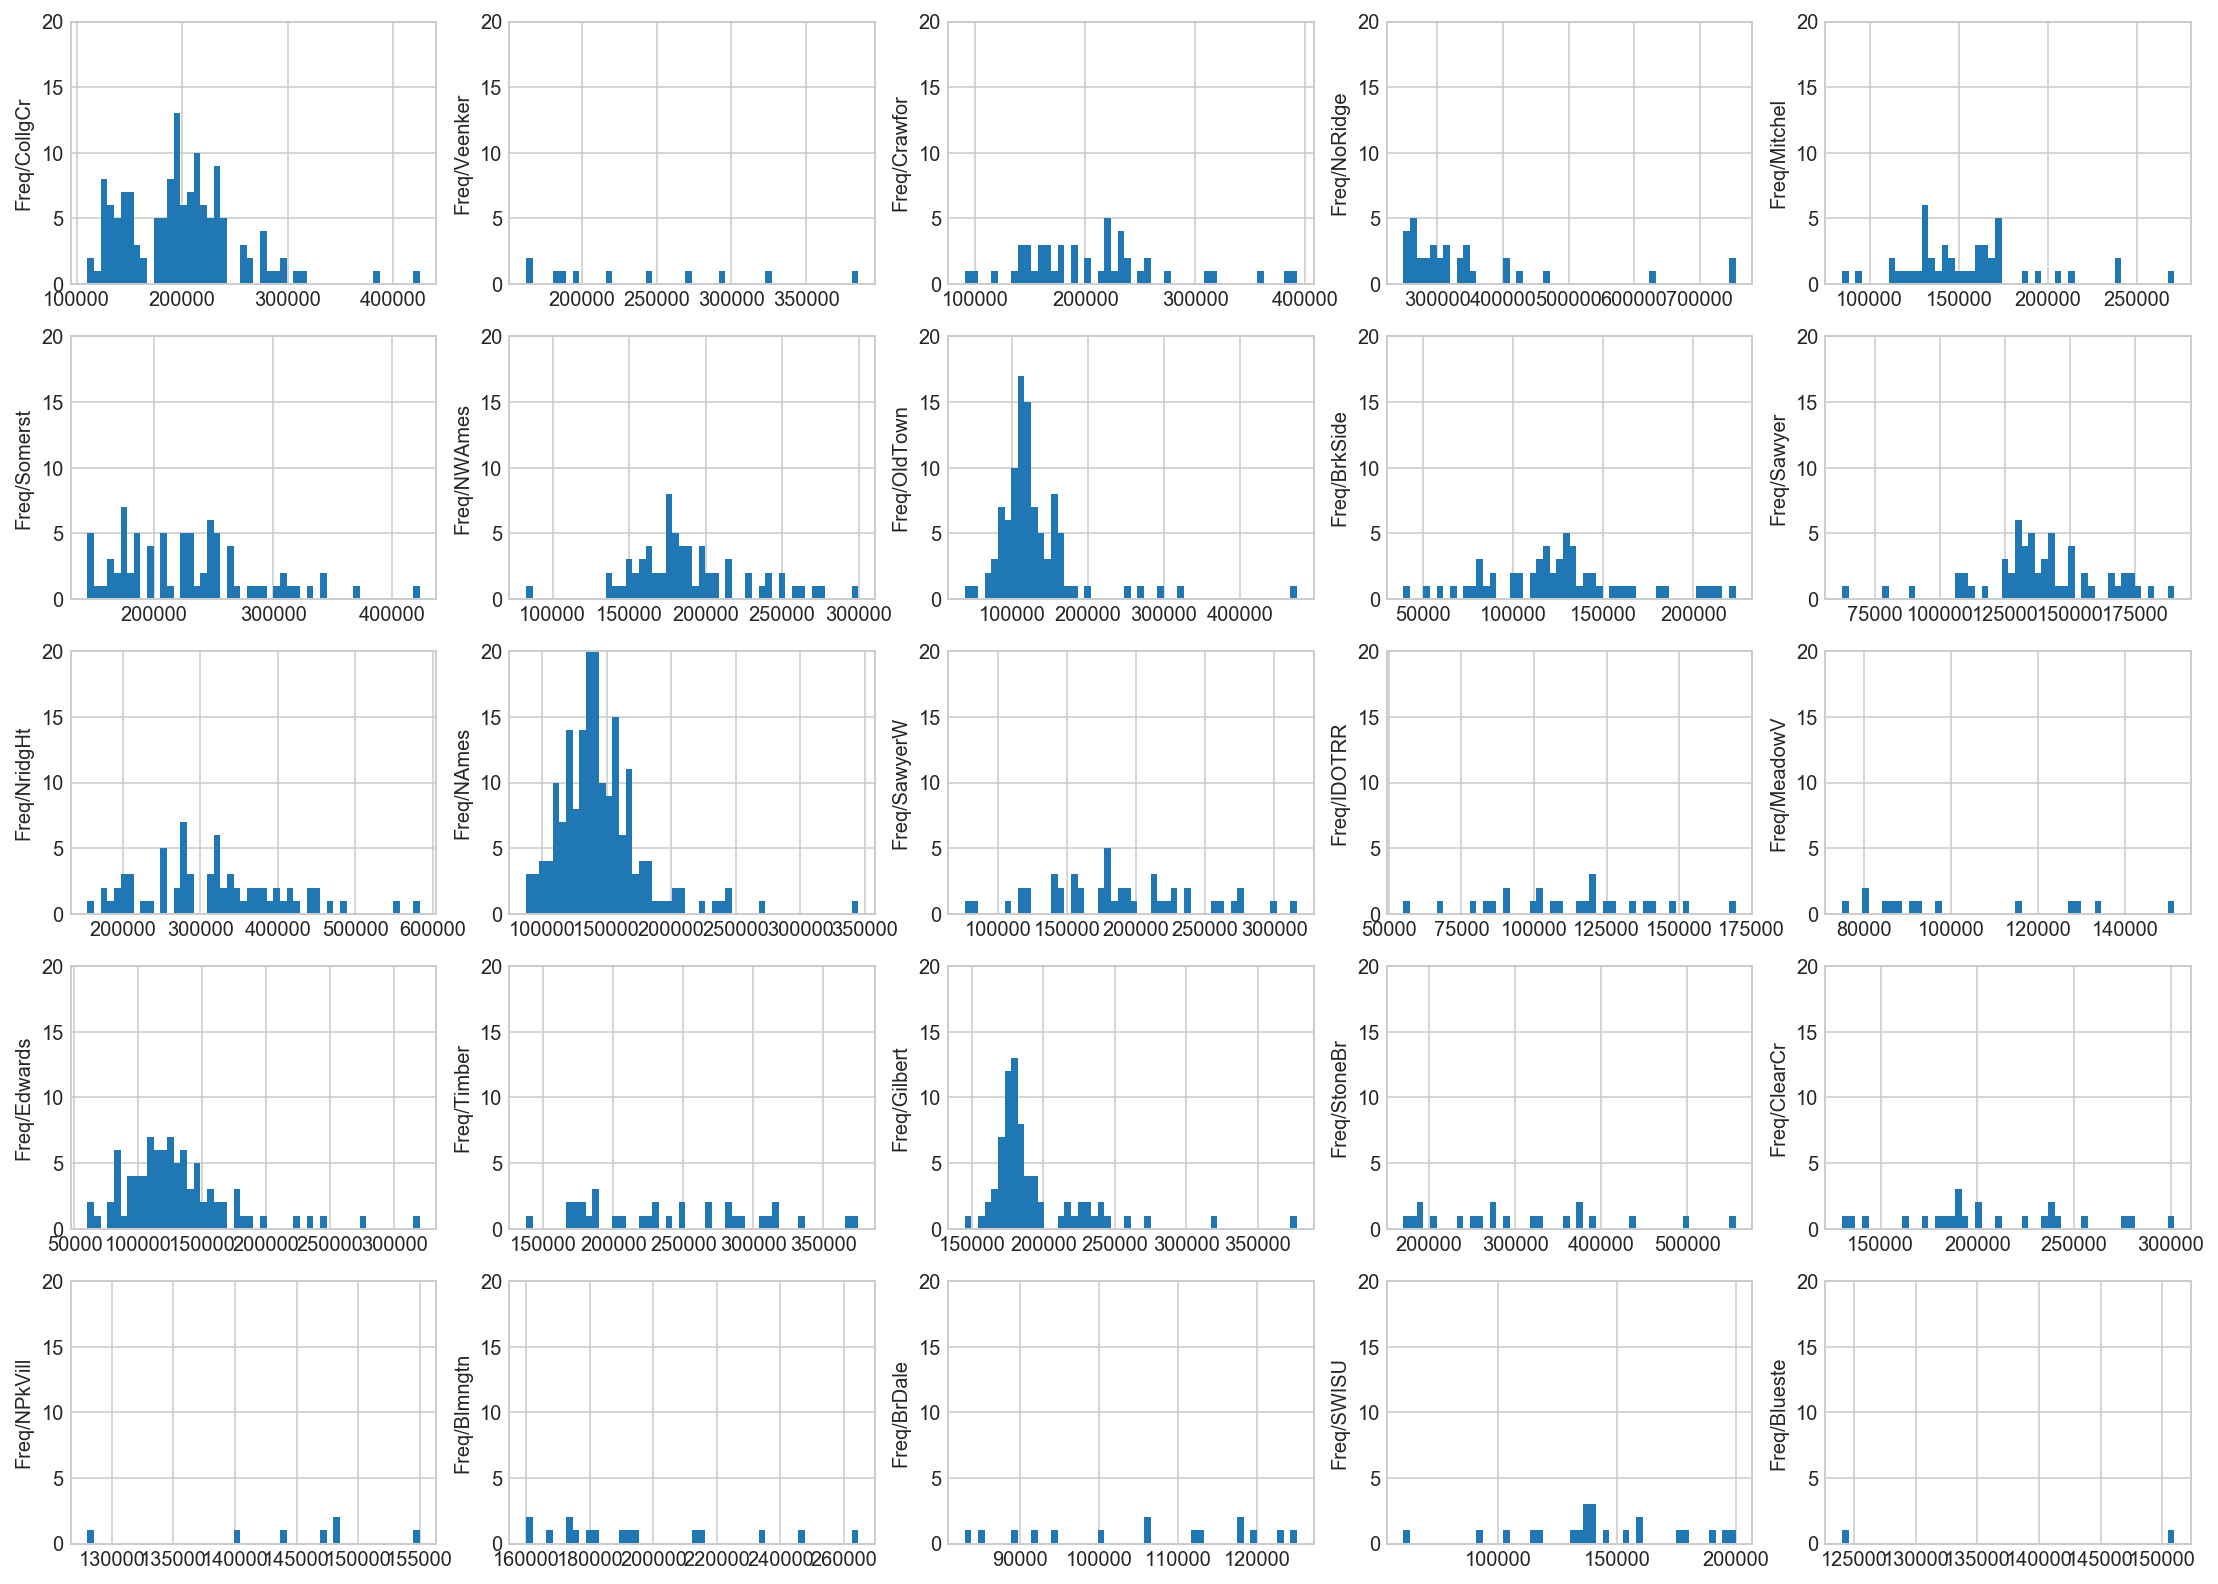

In [23]:
# 2.1.3.3 Plotting 'Neighborhood' in detail

# Create mask for subcategories of 'Foundation'
mask = list(resident_pre2010['Neighborhood'].unique())

_ = plt.figure(figsize=(19, 14))
for idx, sub in enumerate(mask):
    _ = plt.subplot(5, 5, (idx+1))
    temp_df = resident_pre2010[resident_pre2010['Neighborhood'] == sub][['SalePrice', 'Neighborhood']]
    temp_df['SalePrice'].plot(kind='hist', bins=50, ylim=(0, 20)) # Use 'ylim=(0, 20)' as the max count is approximately 20
    _ = plt.ylabel('Freq/'+sub)
    
# We shall take for 'Neighborhood':
    # 'CollgCr', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt',
    # 'NAmes', 'SaywerW', 'Edwards', 'Gilbert'

['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'] 
 No. of datetime fixed-categoricals:  5


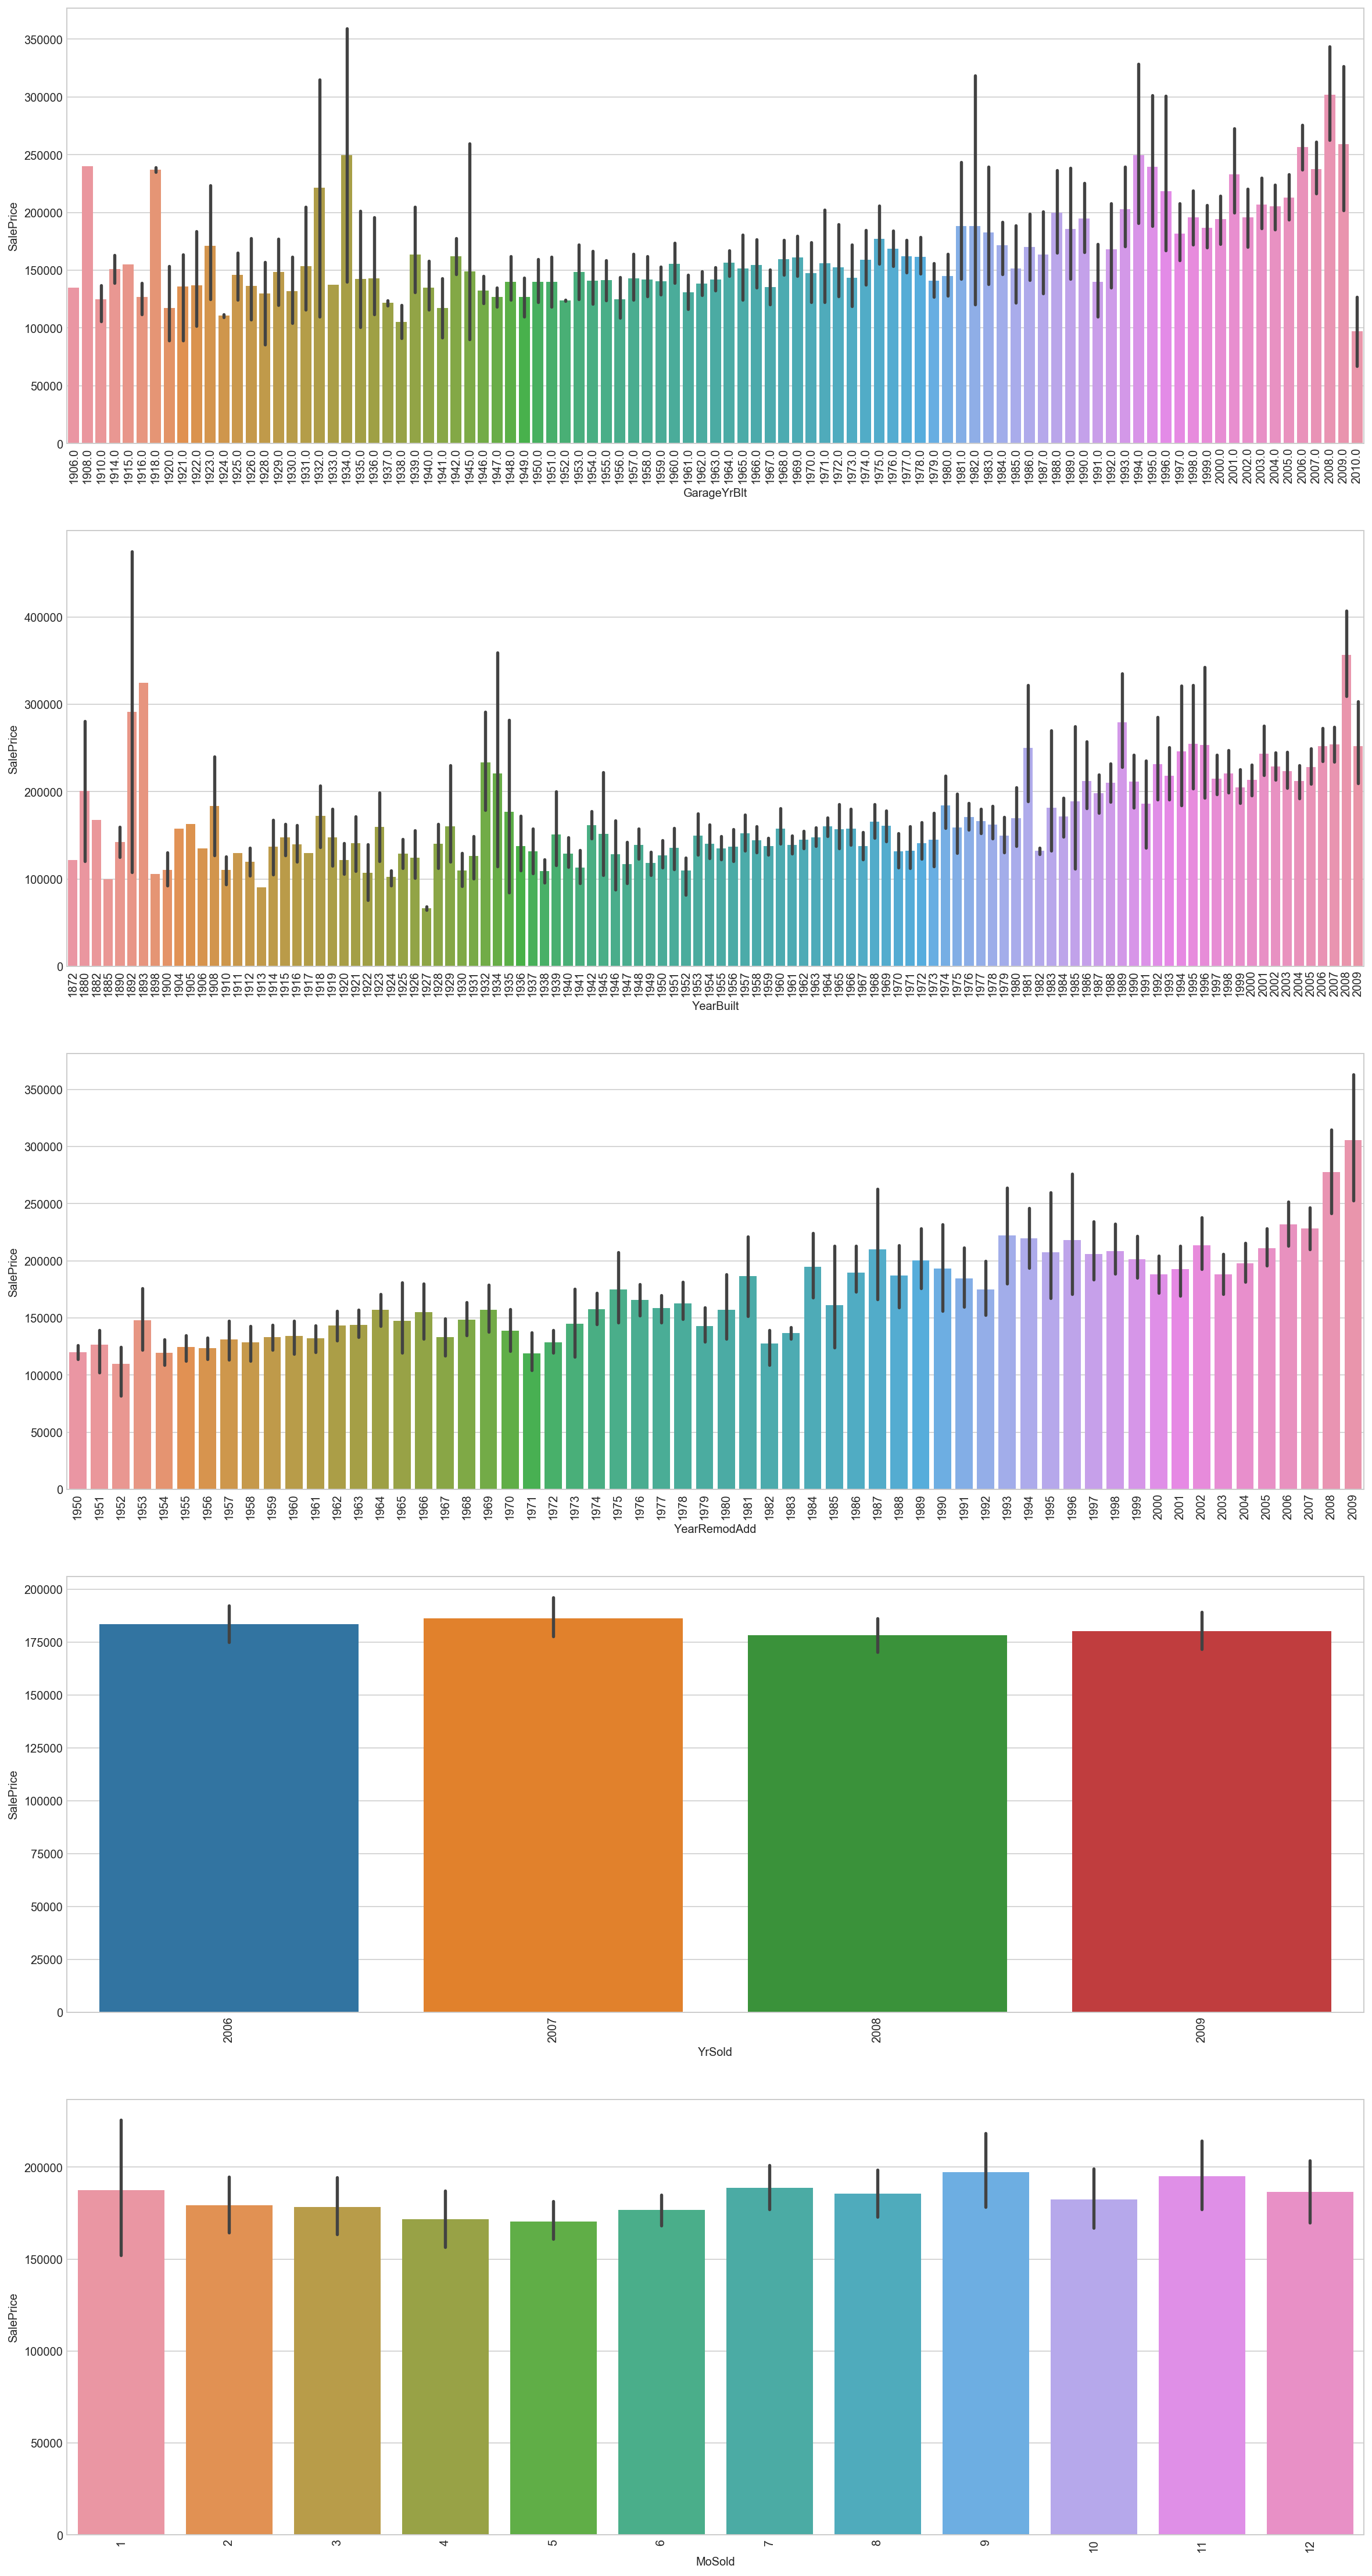

In [24]:
# 2.2.1 Categorical datetime features
# Plot barplots of 'SalePrice' grouped by each unique categorical datetime fixed feature

# Obtain fixed datetime categorical list
fx_date_and_cat = list((set(fx_ft).intersection(set(cat_ft))).intersection(set(date_cols)))
print(fx_date_and_cat, '\n', 'No. of datetime fixed-categoricals: ', len(fx_date_and_cat)) # 5 in total

# Examine barplots of the 'SalePrice' w.r.t. each of these datetime fixed-categorical variables
_ = plt.figure(figsize=(20, 40))
for plot, var in enumerate(fx_date_and_cat):
    _ = plt.subplot(5, 1, (plot+1))
    _ = sns.barplot(y='SalePrice', x=var, data=resident_pre2010)
        # 'sns.barplot' provides us with the measurement of central tendency - mean
    _ = plt.xticks(rotation=90)  

Based on 'YrSold', we have verified that the data of home transaction is between 2006 to 2010 (data contains up to 2009 and 2010 was removed).
    
From 'YearBuilt', it seems that the more recent the house was built, the higher the sale price it would fetch with the exception of years 1890s and 1930s. These homes could have historical values which explains the higher relative prices.
    - As the more recent modifications were added to the homes, the higher the sale prices were too. This could be one of the strategies to improve a housing's value.
    - This trend is similarly replicated in 'GarageYrBlt'.
        - Random spikes before the 1940s could be due to the fact that these houses were remodelled.
        - Older houses tend to be remodelled towards the millennium. This could be verified by checking whether 'YearRemodAdd' is high compared to 'GarageYrBlt' year spikes.

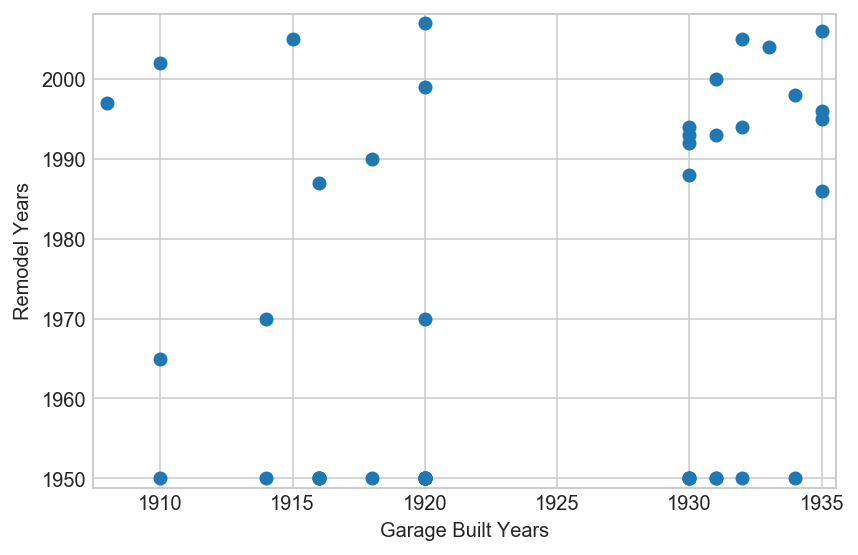

In [25]:
# 2.2.1.1 Investigating the spikes in 'GarageYrBlt'
# Evaluate garages built between 1930-1935 & 1908-1920, against year remodelled and plot the relationship
# If the spike in garage years are caused by the year of remodelling, then all the data points should lie near the top

b4_1935 = ((resident_pre2010['GarageYrBlt'] >= 1930) & (resident_pre2010['GarageYrBlt'] <= 1935)) \
            | ((resident_pre2010['GarageYrBlt'] >= 1908) & (resident_pre2010['GarageYrBlt'] <= 1920))
temp_df = pd.concat([resident_pre2010[b4_1935]['GarageYrBlt'], resident_pre2010[b4_1935]['YearRemodAdd']], axis='columns')

_ = plt.scatter(x=temp_df['GarageYrBlt'], y=temp_df['YearRemodAdd'])
_, _ = plt.xlabel('Garage Built Years'), plt.ylabel('Remodel Years')
plt.tight_layout(); plt.margins(0.02)
    # It seems the majority of the data points lie on the upper half of the graph which does not contradict our conjecture

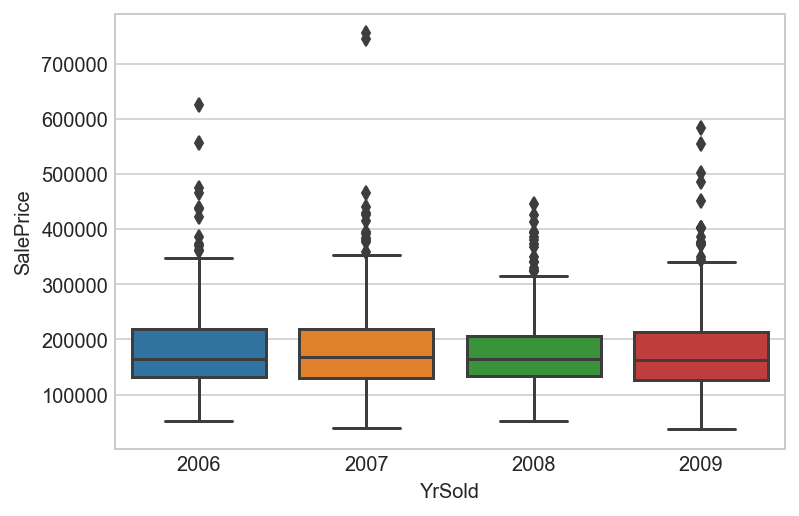

In [26]:
# 2.2.2 Evaluating 'YrSold'
# Examine boxplots of the 'SalePrice' w.r.t. 'YrSold' to evaluate if there are better transaction months
_ = sns.boxplot(x='YrSold', y='SalePrice', data=resident_pre2010)

It appears that the variation falls during a recessionary period although a little recovery effect is seen from
2009 onwards with higher 'SalePrice' outliers. 
This falls in line with expectations that a gloomy economic outlook has less consumers spending on big ticket items.

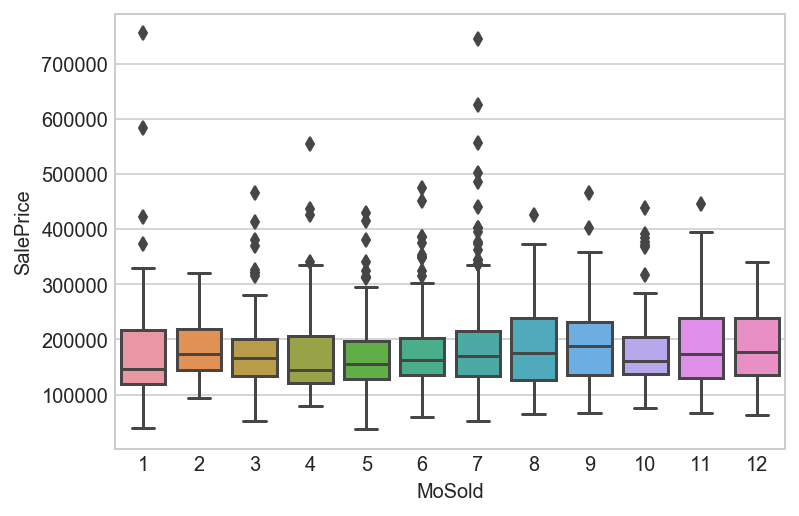

In [27]:
# 2.2.3 Evaluating 'MoSold'
# Examine boxplots of the 'SalePrice' w.r.t. 'MoSold' to evaluate if there are better transaction months

_ = sns.boxplot(x='MoSold', y='SalePrice', data=resident_pre2010)
    # 'sns.barplot' provides us with the measurement of central tendency - mean    

From the barplots, it seems that the best months to transact is during March to July while sales become slower
towards the end of the year - Perhaps due to the weather, summer being the best time to view homes while winter the worst.
    - March to July happens to coincide with spring/summer in Iowa, this may not happen to be coincidental in the variations of 'SalePrice' during these periods.

In [28]:
# 2.2.4 Concluding EDA from datetime variables

While we may perform panel regressions, it may not be ideal as the key dates are found in 'YrSold', which would reflect how the other variables change over time. However, the data covers between 2006 to 2010 only which is not representative enough. Moreover with the subprime mortage crisis occuring within this time frame, conclusions drawn from the panel regression may not be representative of the home consumers' behaviour in Iowa.

Conclusions from EDA of the 5 datetime variables
    - [1] Best time to conduct housing transactions falls during March to July
    - [2] As the house gets remodelled later, the likelier it would fetch a higher price
        - [2a] The more recent the garage was built (if any), the higher price it would also fetch
        - [2b] Logically, sale of houses would be worst during recessions as supported by the barplots in 'YrSold'

['LotArea', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 'BsmtFullBath', 'TotRmsAbvGrd', 'MasVnrArea', 'GarageCars', 'HalfBath', 'TotalBsmtSF', 'Fireplaces', 'KitchenAbvGr', '3SsnPorch', 'OpenPorchSF', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'PoolArea', 'BsmtHalfBath', 'LotFrontage', 'EnclosedPorch', 'FullBath', 'GrLivArea'] 
 No. of fixed non-categoricals:  23


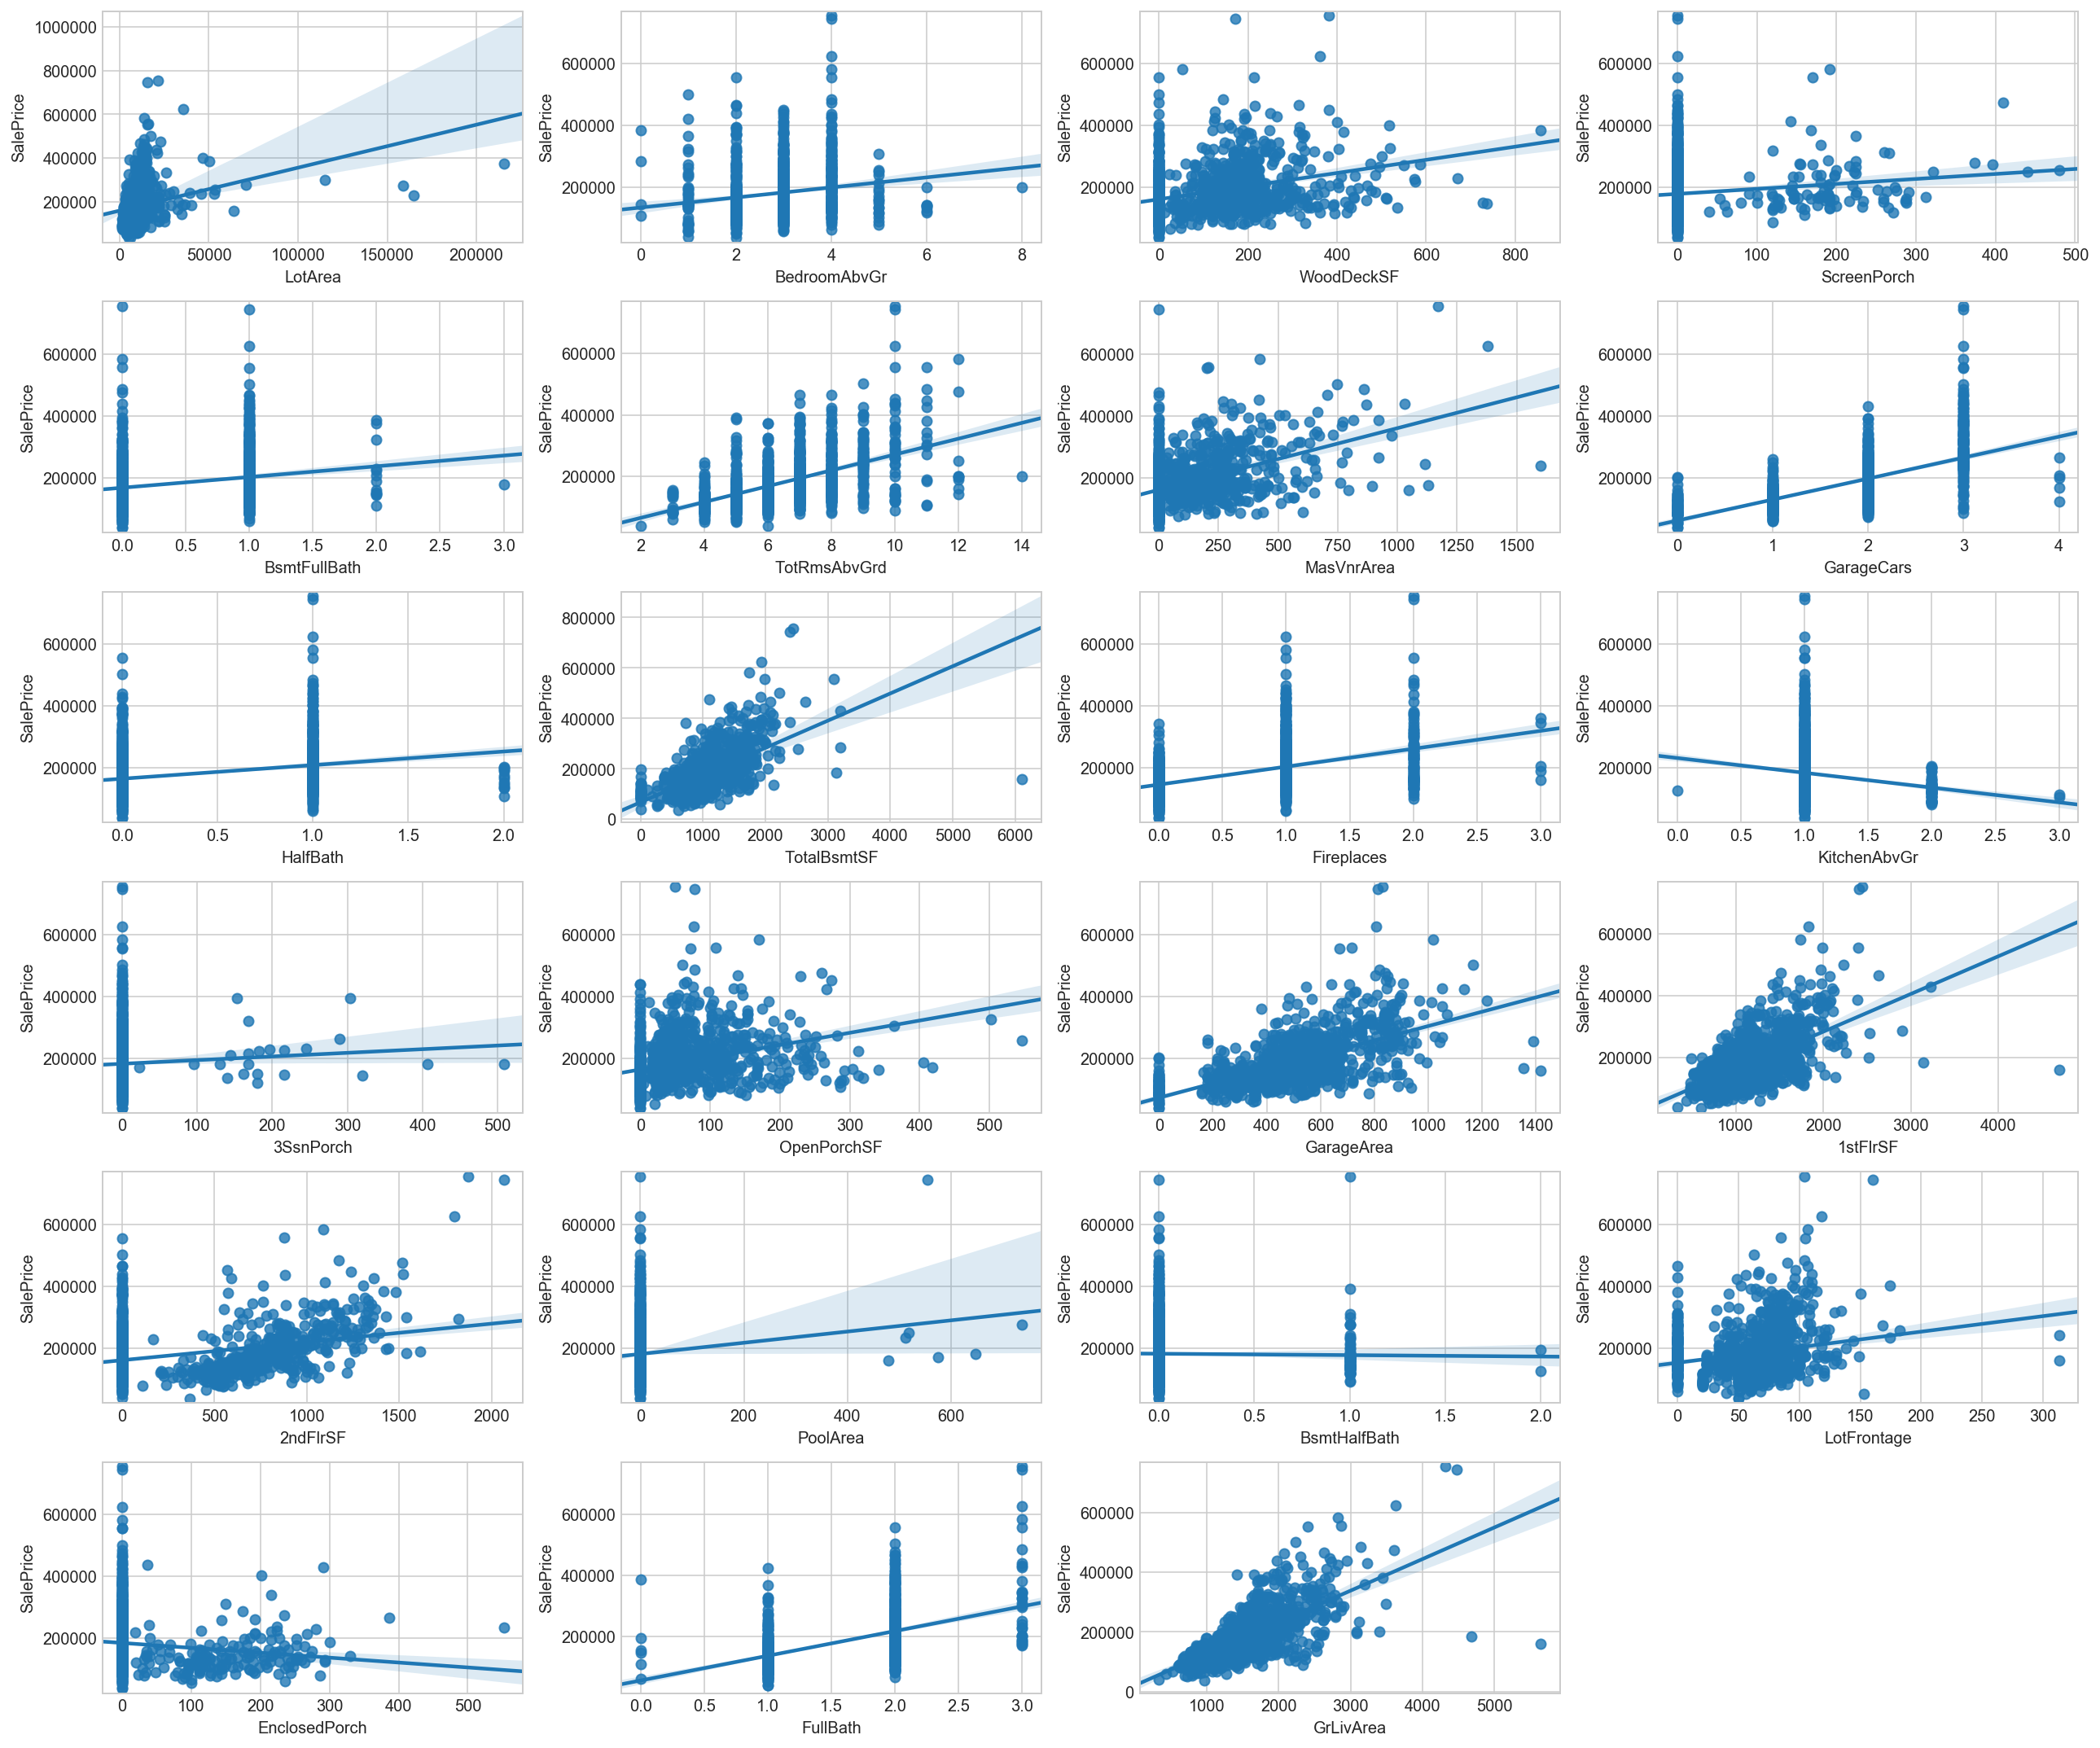

In [29]:
# 2.3.1 Non-categorical features
    # Plot scatterplots of 'SalePrice' against each unique non-categorical fixed feature

# Obtain fixed and non-categorical variable list
fx_and_noncat = list(set(fx_ft).difference(set(cat_ft)))
print(fx_and_noncat, '\n', 'No. of fixed non-categoricals: ', len(fx_and_noncat)) # 23 in total

# Examine scatterplots of the 'SalePrice' w.r.t. each of these fixed non-categorical variables
_ = plt.figure(figsize=(18, 15))
for plot, var in enumerate(fx_and_noncat):
    _ = plt.subplot(6, 4, (plot+1))
    _ = sns.regplot(y='SalePrice', x=var, data=resident_pre2010)
    _ = plt.xlabel(var); plt.ylabel('SalePrice'); plt.tight_layout(); plt.margins(0.02)

In [30]:
# 2.3.2 Analysis of scatter relations (possibly non-linearity) Part I

From the scatter relations, it is observed that there are generally no non-linear relationship between the non-categorical
fixed features from the dataset w.r.t. 'SalePrice'.
A case of possibly non-linearity relation; Confer the following discrete variables:
    - 'HalfBath', 'BsmtFullBath', 'BedroomAbvGr', 'Fireplaces' and 'GarageCars'
    
As the values for each these variables increase beyond a certain point, the data points appear to cluster downwards. If we could fit a curve with a maximum point, it would appear to fit nicely However, we would continue to regard these variables as linear in relation w.r.t. 'SalePrice' for these reasons:
    - [1] Beyond a certain point (after the 'maximum point'), the number of datapoints appear to be very little and thus may not be representative of the true home buyers' (consumers') behaviour. Proving this maximum exist would require either upsampling(downsampling) higher(lower) values or obtain more data points for the higher values.
    
    - [2] This maxima-curved nature may be a result of another variable - measurements of square feet of the house. For instance, holding the square feet size of the house constant, as the number of rooms increase, intuitively we know that the room sizes decrease too and likewise the kitchen, living room etc. This could be proven if we obtain a negative relationship between a house size sq. ft. measurement and these discrete variables.

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


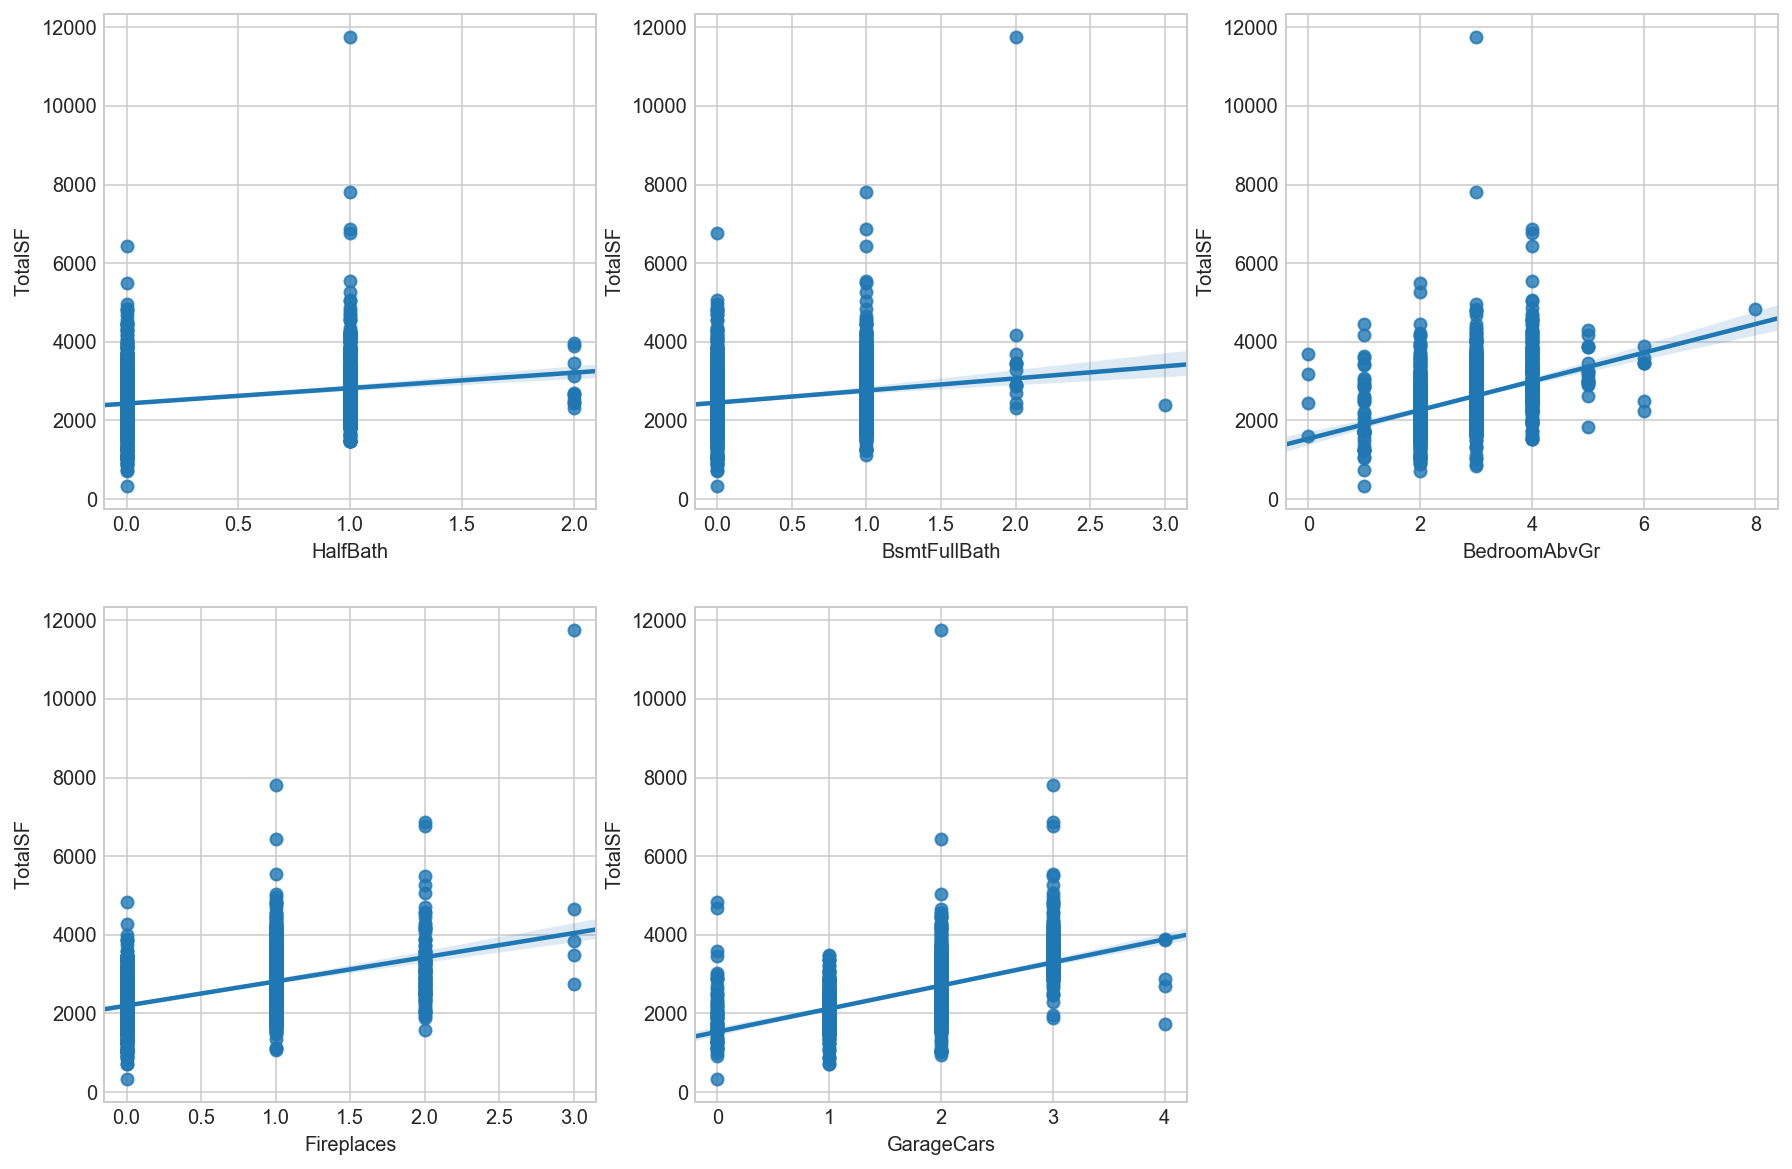

In [31]:
# 2.3.3 Analysis of scatter relations (possibly non-linearity) Part II
# Plot pairplots for the 5 mentioned variables against 'GrLivArea' + 'TotalBsmtSF' to denote the total area of the house
# Create this variable and label as 'TotalSF'
resident_pre2010['TotalSF'] = resident_pre2010['GrLivArea'].add(resident_pre2010['TotalBsmtSF'])
pos_nonlin_dvars = ['HalfBath', 'BsmtFullBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars']

_ = plt.figure(figsize=(15, 10))
for plot, var in enumerate(pos_nonlin_dvars):
    _ = plt.subplot(2, 3, (plot+1))
    _ = sns.regplot(x=var, y='TotalSF', data=resident_pre2010)   

It seems that they are all positively correlated with the size of the house, then we may conclude that the 'nonlinear' shape observed could either be caused by the imbalanced data or by some other unobservable reasons

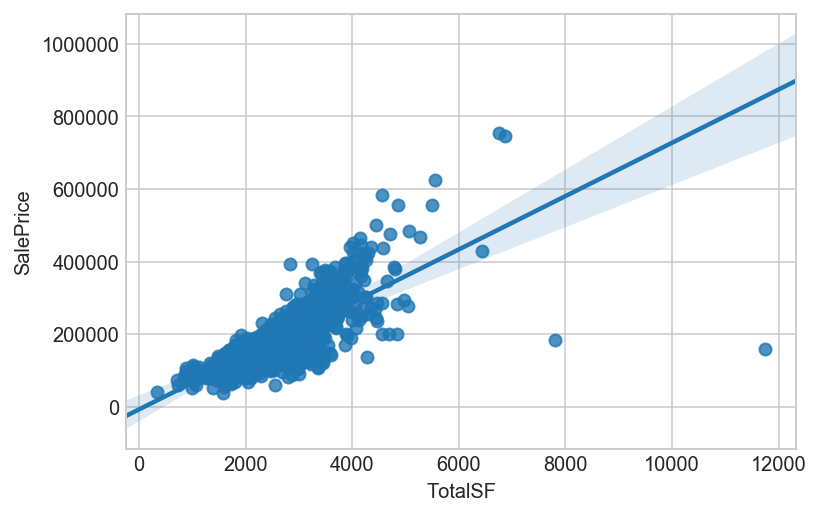

In [32]:
# 2.3.4 Analysis of scatter relations (possibly non-linearity) Part III
# Nonetheless, the results raises an important caveat which is bed/bathrooms, garage size and fireplaces are all positively
# correlated with the size of the house. Therefore, we may infer that house size does raises 'SalePrice' - intuitively
# logical but we shall prove it!
    # 'TotalSF' needs to be positively correlated with 'SalePrice'; if true, then in a regression together with variables in
    # 'pos_nonlin_dvars', their explanatory powers may be weakened or become insignificant

_ = sns.regplot(x='TotalSF', y='SalePrice', data=resident_pre2010)
    # Result reveal high correlations, therefore in the subsequent analyses, we may need to examine variables that are
    # highly correlated with 'TotalSF' when regressing 'SalePrice' on these variables closer

In [33]:
# 2.3.5 Analysis of imbalanced ('0's) variables

There appears to be clustering at the 0-point for a few of the variables which could be the result of filling 'NaN's with '0's earlier on or it could be the nature of the houses in the dataset.
- i.e. apartments would not have basements and therefore a predominant number of 0's exists for variables such as 'PoolArea' and 'ScreenPorch' OR these houses lack these facilities to begin with.
    
Regardless, we may ignore these '0' clustering since the general scatter distributions are positively linear, the regression line appear unaffected except it may be skewed downwards. With the exeception of 'EnclosedPorch', the '0' points are clearly skewing the regression line towards negativity when the datapoints appear to be weakly correlated with 'SalePrice'.

In [34]:
# We shall see whether 'SalePrice' is weakly negatively correlated with 'EnclosedPorch' after dropping the '0's
temp_df = pd.concat([resident_pre2010['SalePrice'], resident_pre2010['EnclosedPorch'].map(lambda x: np.nan if x==0 else x)], axis='columns')
print(temp_df.corr())
    # It seems that the correlation is mildly positive
    
# Number of 0's in 'EnclosedPorch'
print('No.of Zeros: ', resident_pre2010['EnclosedPorch'].value_counts()[0], '\n')
    # '0' in 'value_counts()[0]' is not an index, rather the actual value itself from the data
    # With 1104 '0's, this occupys more than 85% of the dataset, hence, we shall not use this variable for any regressions

               SalePrice  EnclosedPorch
SalePrice        1.00000        0.24229
EnclosedPorch    0.24229        1.00000
No.of Zeros:  1104 



In [35]:
# Furthering on this finding, '3SsnPorch', 'ScreenPorch' 'PoolArea', may not be good regressors too
# '3SsnPorch'
temp_df = pd.concat([resident_pre2010['SalePrice'], resident_pre2010['3SsnPorch'].map(lambda x: np.nan if x==0 else x)], axis='columns')
print(temp_df.corr())  
# Number of 0's in '3SsnPorch'
print('No.of Zeros: ', resident_pre2010['3SsnPorch'].value_counts()[0], '\n')

# 'ScreenPorch'
temp_df = pd.concat([resident_pre2010['SalePrice'], resident_pre2010['ScreenPorch'].map(lambda x: np.nan if x==0 else x)], axis='columns')
print(temp_df.corr())
# Number of 0's in 'ScreenPorch'
print('No.of Zeros: ', resident_pre2010['ScreenPorch'].value_counts()[0], '\n')

# 'PoolArea'
temp_df = pd.concat([resident_pre2010['SalePrice'], resident_pre2010['PoolArea'].map(lambda x: np.nan if x==0 else x)], axis='columns')
print(temp_df.corr())
# Number of 0's in 'ScreenPorch'
print('No.of Zeros: ', resident_pre2010['PoolArea'].value_counts()[0], '\n')

           SalePrice  3SsnPorch
SalePrice   1.000000   0.068724
3SsnPorch   0.068724   1.000000
No.of Zeros:  1256 

             SalePrice  ScreenPorch
SalePrice     1.000000     0.257502
ScreenPorch   0.257502     1.000000
No.of Zeros:  1177 

           SalePrice  PoolArea
SalePrice   1.000000 -0.014092
PoolArea   -0.014092  1.000000
No.of Zeros:  1271 



Therefore, these 4 variables 'EnclosedPorch', '3SsnPorch', 'ScreenPorch' and 'PoolArea' are highly imbalanced in nature and would not make good regressors

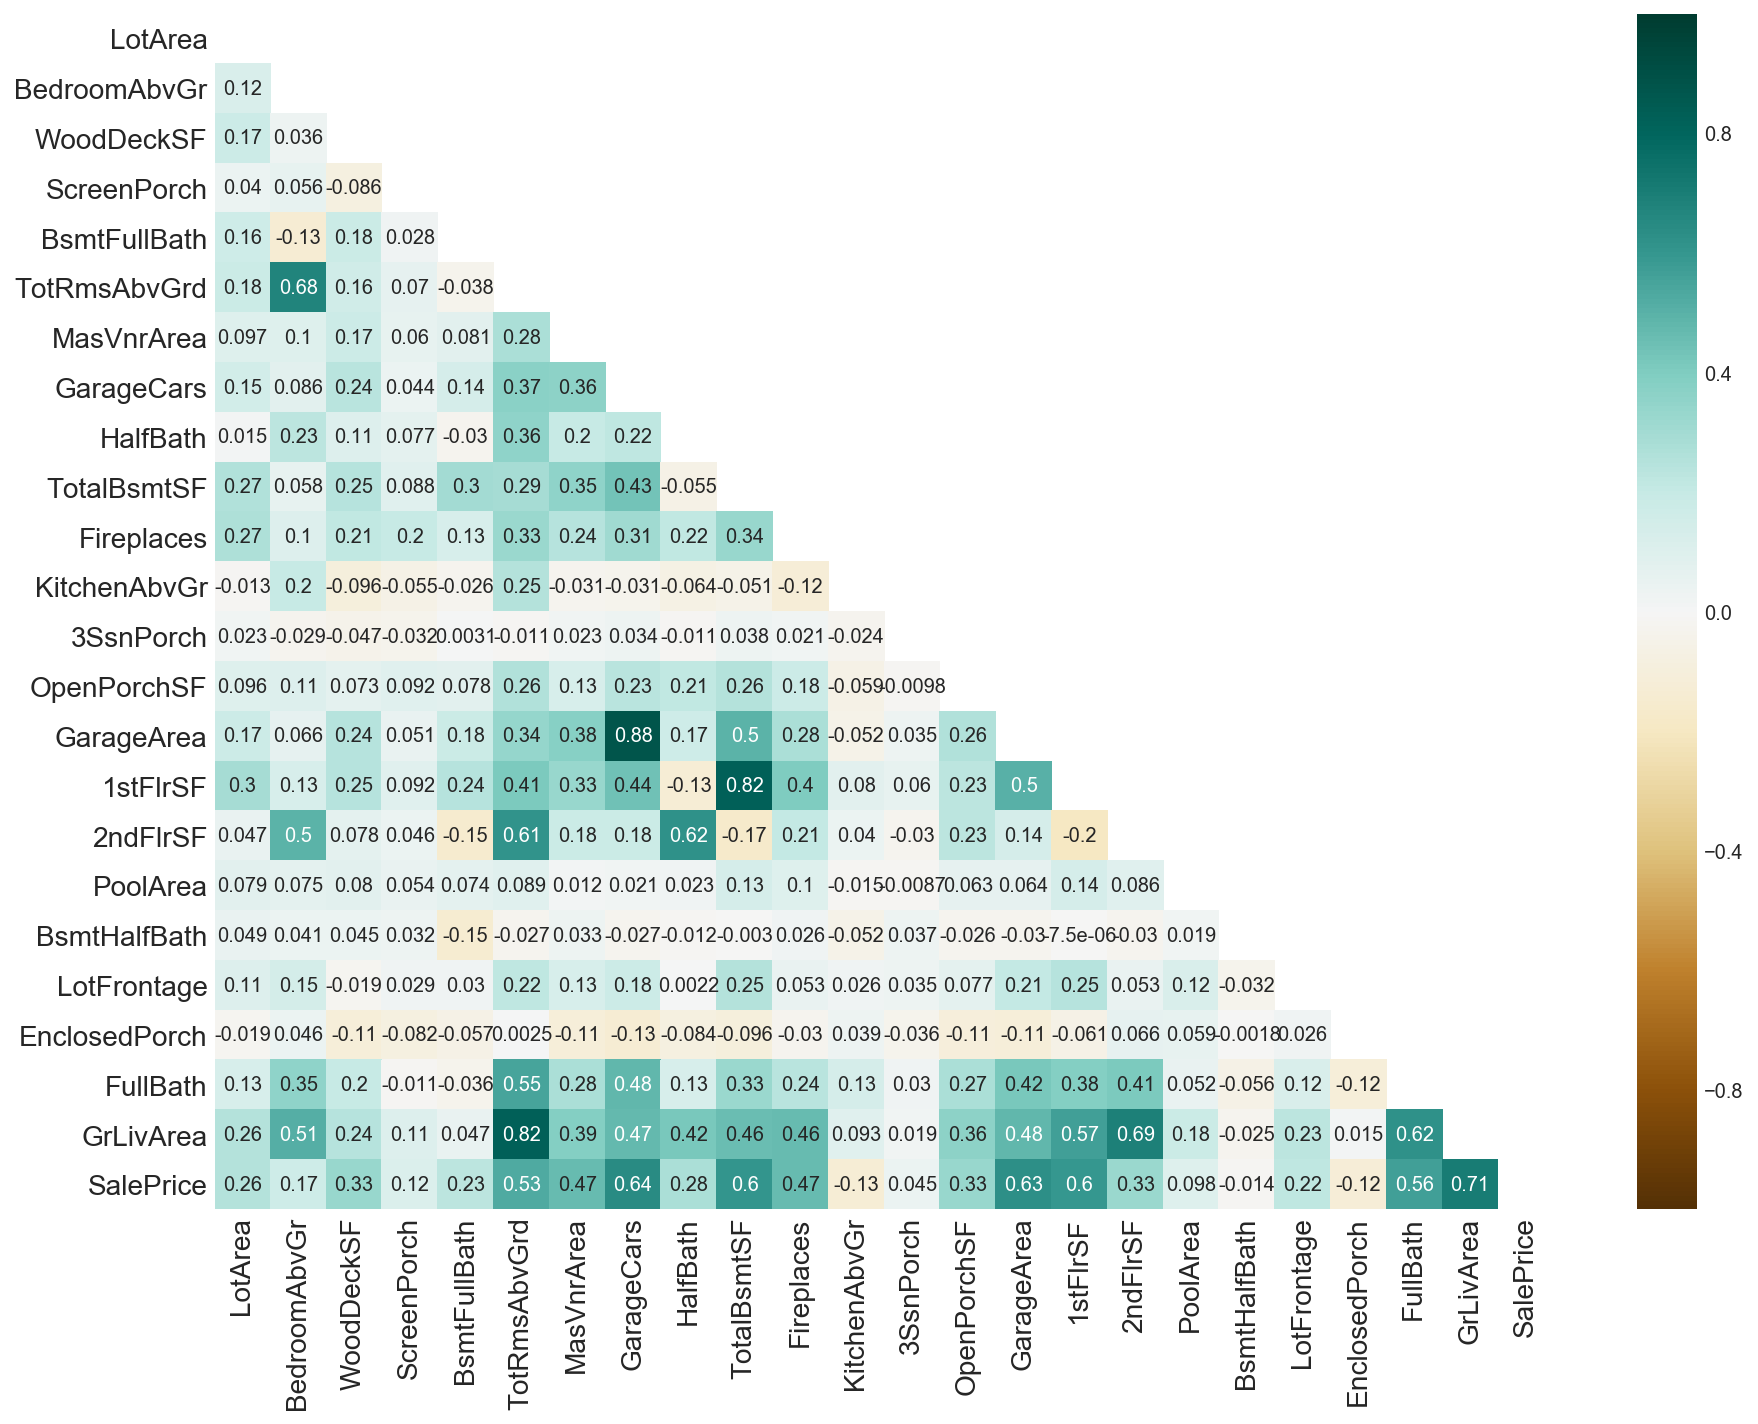

In [36]:
# 2.3.6 Correlation heatmap of all non-categorical fixed features against 'SalePrice'
# A correlation heatmap would be quite informative since the relations appear linear visually w.r.t. 'SalePrice'

corr = resident_pre2010[(fx_and_noncat+['SalePrice'])].corr()

fig, ax = plt.subplots(figsize=(15,11))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='BrBG', vmin=-1, vmax=1)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

We shall set +/- 0.7 as a filtering criteria to ensure reasonable explanatory powers of each regressors and to avoid over-specification/over-fitted model. Then, we shall have preference for:

> - 'GarageArea' over 'GarageCars'; rho=0.88: Because area is the ultimate consideration by consumers when deciding the purpose of the garage

> - 'GrdLivArea' over 'TotRmsAbvGrd'; rho=0.82: Since rooms above grade are a subset of living area above grade, and 'GrdLivArea' has a higher correlation coef. with 'SalePrice', we exclude 'TotRmsAbvGrd' rho=0.71 vs. rho=0.53, 'GrdLivArea' would probably explain the variation in 'SalePrice' better
        
> - 'TotalBsmtSF' over '1stFlrSF'; rho=0.82: '1stFlrSF' is already captured in 'GrdLivArea' which will be used for regression analysis, specifying it in model would duplicate things. That being said, '2ndFlrSF' is still included without fear of overspecification because some homes may bemapartments or single-storey based.

In [37]:
### [2] END OF EDA / CONCLUSION OF SECTION 2 ###

For regression analysis purposes, we shall set some criteria based on the findings so far:
    - [1] Exclude 'EnclosedPorch', '3SsnPorch', 'ScreenPorch' and 'PoolArea' since they are highly imbalanced with a dominant number of '0's (for the case of chosen continuous/discrete variables)
    
    - [2] Based on the correlation heatmap of continuous/discrete variables, we set +/-0.7 as a filtering criteria to avoid multicollinearity and weakened explanatory powers between two highly correlated variables. Then, we shall have preference for:
        - 'GarageArea' over 'GarageCars'
        - 'GrdLivArea' over 'TotRmsAbvGrd'
        - 'TotalBsmtSF' over '1stFlrSF'
    - [3] When regressing against 'SalePrice'; 'HalfBath', 'BsmtFullBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars' need to be inspected closer in the event they lack statistical power to explain 'SalePrice' since there may be a causal effect by the components of 'TotalSF'('GrdLivArea' and 'TotalBsmtSF') on these 5 variables. 'GarageCars' has been superseded by 'GarageArea', only need to check for 4 variables
    
    - [4] It may not be wise to perform panel regressions using datetime features as the only possible time indexing may be 'YrSold' which stretches for only a small time period. The EDA on the 5 datetime variables appear insightful enough for the purpose of identifying when to sell. Sales on those recently built, during good weather and economic times tend to fetch higher prices. If we wish to include these 5 datetime features into the regression, we could perform groupby objects and observe changes in how 'SalePrice' is explained
    
    - [5a] For categorical features that we will use all of their subcategories 'BsmtQual' & 'BsmtExposure'
    - [5b] For categorical features that we will specify only the dominant subcategories and group the rest as others
        1. 'MSSubClass' - '20', '60', '50'
        2. 'GarageType' - 'Attchd', 'Detchd'
        3. 'MSZoning' - 'RM', 'RL'
        4. 'LotConfig' - 'Inside', 'Corner'
        5. 'LotShape' - 'IR1', 'Reg'
        6. 'Foundation' - 'BrkTil', 'CBlock', 'PConc'
        7. 'HouseStyle' - '1.5Fin', '1Story', '2Story'
        8. 'Neighborhood' - 'CollgCr', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgeHt', 'NAmes', 'SaywerW', 'Edwards', 'Gilbert' <br>
    The rest of the categorical features will not be used since they have near/non-exsitent subcategories within themselves.
    
    - [6] a linear regression with these continous/discrete fixed factors may not yield precise estimators since we can observe heteroskedastic behaviour in most of the x's. Nonetheless, they should remain unbiased based on the precautionary steps taken above, we may take White-corrected standard errors if necessary to address the estimators' precision issue.  

In [38]:
# To sum the variables of interest into a list:
fx_var_reg_all = ['BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtQual_Fa', 'BsmtQual_NoBsmt',
              'BsmtExposure_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_NoBsmt',
              'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_50',
              'GarageType_Attchd', 'GarageType_Detchd', 
              'MSZoning_RM', 'MSZoning_RL', 
              'LotConfig_Inside', 'LotConfig_Corner', 
              'LotShape_IR1', 'LotShape_Reg', 
              'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
              'HouseStyle_1.5Fin', 'HouseStyle_1Story', 'HouseStyle_2Story',
              'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel',
              'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide',
              'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW',
              'Neighborhood_Edwards', 'Neighborhood_Gilbert',
              'MasVnrArea', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'GrLivArea',
              'FullBath', 'BsmtHalfBath', '2ndFlrSF', 'BsmtFullBath', 'OpenPorchSF', 'GarageArea', 'WoodDeckSF',
              'TotalBsmtSF'
             ]

# Length of investigated variables
print('No. of Regressors (before correcting for overspecification): ', len(fx_var_reg_all))

# Points to note for fixed categorical variables, absence of some categories in the feature
    # BsmtQual - 'Po'
    # 'MSSubClass' - '150'
    # 'MSZoning' - 'A', 'C', 'I', 'RP' (Partly due to filtering)
        # When interpreting dummy variables for these variables, exclude these subcategories out as they are not present

# Length of investigated (adjusted for dummy) variables
    # Only 'BsmtQual' and 'BsmtExposure' required for adjustment, other categorical variables were already adjusted for
fx_var_reg_adjst = ['BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtQual_Fa',
              'BsmtExposure_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No',
              'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_50',
              'GarageType_Attchd', 'GarageType_Detchd', 
              'MSZoning_RM', 'MSZoning_RL', 
              'LotConfig_Inside', 'LotConfig_Corner', 
              'LotShape_IR1', 'LotShape_Reg', 
              'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
              'HouseStyle_15Fin', 'HouseStyle_1Story', 'HouseStyle_2Story',
              'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel',
              'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide',
              'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW',
              'Neighborhood_Edwards', 'Neighborhood_Gilbert',
              'MasVnrArea', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'GrLivArea',
              'FullBath', 'BsmtHalfBath', 'Flr2ndSF', 'BsmtFullBath', 'OpenPorchSF', 'GarageArea', 'WoodDeckSF',
              'TotalBsmtSF'
             ]

# 'HouseStyle_1.5Fin' renamed as 'HouseStyle_15Fin' as statsmodels would have issues parsing the name
resident_pre2010.rename(index=str, columns={'HouseStyle_1.5Fin': 'HouseStyle_15Fin'}, inplace=True)
# '2ndFlrSF' renamed as 'Flr2ndSF' - variable names should not start with numerals, statsmodels would encounter errors too
resident_pre2010.rename(index=str, columns={'2ndFlrSF': 'Flr2ndSF'}, inplace=True)

print('No. of Regressors (aft. correcting for overspecification): ', len(fx_var_reg_adjst))

No. of Regressors (before correcting for overspecification):  57
No. of Regressors (aft. correcting for overspecification):  55


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [39]:
### [3] REGRESSION ANALYSIS ###

- We shall perform a top down approach of regression analysis
    - Regress all variables
    - Remove insignificant ones
    - Regress on remaining variables
    - Repeat 2-3 until all remaining variables are significant
    - Interpret model

In [40]:
# 3.1.1 Final correlation check (cont/discrete features were not checked against categorical data yet)
# Perform one last correlation check of the model variables to ensure no high collinearity
    # If there is, re-adjust model
    # Ideally we would have ran auxillary regressions but there are many variables to check for and will be inefficient
        # i.e. x_i = a0 + a1x_j + ... + akx_k + v

# Iterate through the variables list
    # For each variables, if coef >/< +/- 0.7 in coefficient
        # Flag out and collect variable pair

# Source: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_fx = resident_pre2010[(fx_var_reg_adjst)].corr(method='spearman').abs()
corr_fx_pdSr = corr_fx.unstack()
corr_fx_pdSr_sort = corr_fx_pdSr.sort_values(ascending=False)

pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 1000)
print(corr_fx_pdSr_sort.head(80))

TotalBsmtSF           TotalBsmtSF             1.000000
Neighborhood_Crawfor  Neighborhood_Crawfor    1.000000
Neighborhood_Somerst  Neighborhood_Somerst    1.000000
Neighborhood_NWAmes   Neighborhood_NWAmes     1.000000
Neighborhood_OldTown  Neighborhood_OldTown    1.000000
Neighborhood_BrkSide  Neighborhood_BrkSide    1.000000
Neighborhood_Sawyer   Neighborhood_Sawyer     1.000000
Neighborhood_NridgHt  Neighborhood_NridgHt    1.000000
Neighborhood_NAmes    Neighborhood_NAmes      1.000000
Neighborhood_SawyerW  Neighborhood_SawyerW    1.000000
Neighborhood_Edwards  Neighborhood_Edwards    1.000000
Neighborhood_Gilbert  Neighborhood_Gilbert    1.000000
MasVnrArea            MasVnrArea              1.000000
HalfBath              HalfBath                1.000000
KitchenAbvGr          KitchenAbvGr            1.000000
Fireplaces            Fireplaces              1.000000
LotFrontage           LotFrontage             1.000000
LotArea               LotArea                 1.000000
BedroomAbv

In [41]:
# 3.1.2 Removal of highly correlated variables, to avoid multicollinearity issues
# Highly correlated variables, threshold == +/- 0.70

[Var_1] ||              [Var_2]    ||             [abs. rho value] <br>
- HouseStyle_15Fin        ||  MSSubClass_50             ||  0.945596
- LotShape_IR1            ||  LotShape_Reg              ||  0.926076
- MSZoning_RM             ||  MSZoning_RL               ||  0.823752
- Flr2ndSF                ||  HouseStyle_1Story         ||  0.819500
- Flr2ndSF                ||  HouseStyle_2Story         ||  0.819164
- Foundation_CBlock       ||  Foundation_PConc          ||  0.776082
- MSSubClass_60           ||  HouseStyle_2Story         ||  0.767008
- BsmtQual_TA             ||  BsmtQual_Gd               ||  0.760305
- HouseStyle_1Story       ||  MSSubClass_20             ||  0.760299
- LotConfig_Corner        ||  LotConfig_Inside          ||  0.750104
- GarageType_Detchd       ||  GarageType_Attchd         ||  0.736297

We shall drop the following variables:
    - 'HouseStyle_15Fin': This is equivalently 'MSSubClass50'
    - 'LotShape_IR1': Interpreting regular lot shape is easier to understand against the rest of the irregularities
    - 'MSZoning_RM': Ease of interpretation, low residential density against the rest rather than medium against high/low 
    - 'Flr2ndSF': Highly corr. with 'HouseStyle_1Story' & 'HouseStyle_2Story'. Moreover it is a subset of 'GrLivArea'
    - 'Foundation_CBlock': 'Foundation_PConc' has more datapoints - from combined distribution charts in 2.1.1
    - 'BsmtQual_Gd': Ease of interpreting results, typical basement quality (bsmt. height) compared to the rest
    - 'HouseStyle_2Story': 'MSSubClass_60' is explicit in terms of it describes a 2-storey building 1946 and newer. 'HouseStyle_2Story' encompasses all and is thus less informative/detailed
    - 'HouseStyle_1Story': 'MSSubClass_20' is explicit in terms of it describes a 1-storey building 1946 and newer. 'HouseStyle_1Story' encompasses all and is thus less informative/detailed
    - 'LotConfig_Corner': There are more datapoints in 'LotConfig_Inside' than the other, from 2.1.1
    - 'GarageType_Detchd': There are more datapoints in 'GarageType_Attchd' than the other, from 2.1.1

In [42]:
# With information above, redefine final X on y('SalePrice') variables
final_fx = ['BsmtQual_Ex', 'BsmtQual_TA', 'BsmtQual_Fa',
            'BsmtExposure_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No',
            'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_50',
            'GarageType_Attchd',
            'MSZoning_RL',
            'LotConfig_Inside',
            'LotShape_Reg',
            'Foundation_BrkTil', 'Foundation_PConc',
            'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel',
            'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide',
            'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW',
            'Neighborhood_Edwards', 'Neighborhood_Gilbert',
            'MasVnrArea', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'GrLivArea',
            'FullBath', 'BsmtHalfBath', 'BsmtFullBath', 'OpenPorchSF', 'GarageArea', 'WoodDeckSF', 'TotalBsmtSF'
             ]
print('No. of fixed regressors: ', len(final_fx))

No. of fixed regressors:  45


In [43]:
# 3.2.1 Defining model and performing linear regression - First Iteration
# Converting X to patsy-styled formula
X_var_str = ''
for idx, var in enumerate(final_fx):
    if idx == len(final_fx) - 1:
        X_var_str += var
    else:
        X_var_str += var + ' + '

formula = 'SalePrice ~ ' + X_var_str

# Create y, X using patsy
pat_y, pat_X = patsy.dmatrices(formula, data=resident_pre2010)

# Perform Regression using statsmodels
model_sm = sm.OLS(pat_y, pat_X).fit()
    # Correct for heteroskedasticity - White-robust standard errors
    # There are many corrected s.e. methodologies, refer to documentation:
        # http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html
        # http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html

# Perform fit then correct the standard errors
model_sm.get_robustcov_results(cov_type='HC0', use_t=None).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     125.7
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:48:23   Log-Likelihood:                -15118.
No. Observations:                1278   AIC:                         3.033e+04
Df Residuals:                    1232   BIC:                         3.056e+04
Df Model:                          45                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              3.33e+04   1.69e+04      1.970      0.049     137.766    6.65e+04
BsmtQual_Ex           5.139e+04   7442.742      6.904      0.000    3.68e+04     6.6e+04
BsmtQual_TA          -4808.7162   3100.101     -1.551      0.121   -1.09e+04    1273.345
BsmtQual_Fa          -1.496e+04   5672.890     -2.636      0.008   -2.61e+04   -3826.760
BsmtExposure_Gd       4.356e+04   2.22e+04      1.964      0.050      49.800    8.71e+04
BsmtExposure_Av       2.873e+04    2.1e+04      1.371      0.171   -1.24e+04    6.98e+04
BsmtExposure_Mn       2.112e+04   2.09e+04      1.013      0.311   -1.98e+04     6.2e+04
BsmtExposure_No       1.481e+04   1.94e+04      0.762      0.446   -2.33e+04    5.29e+04
MSSubClass_20         1.935e+04   6193.063      3.124      0.002    7196.055    3.15e+04
MSSubClass_60         6933.7839   5555.546      1.248      0.212   -3965.595    1.78e+04
MSSubClass_50         -523.2174   3695.656     -0.142      0.887   -7773.694    6727.259
GarageType_Attchd     1983.6710   2873.060      0.690      0.490   -3652.961    7620.303
MSZoning_RL           1.254e+04   4220.042      2.972      0.003    4264.181    2.08e+04
LotConfig_Inside       982.4623   2515.259      0.391      0.696   -3952.202    5917.126
LotShape_Reg         -2325.9618   2228.954     -1.044      0.297   -6698.928    2047.004
Foundation_BrkTil      111.1919   3543.488      0.031      0.975   -6840.746    7063.130
Foundation_PConc      7923.6529   2685.536      2.950      0.003    2654.922    1.32e+04
Neighborhood_CollgCr -1199.5460   4857.349     -0.247      0.805   -1.07e+04    8330.045
Neighborhood_Crawfor  1.947e+04   6743.118      2.887      0.004    6237.638    3.27e+04
Neighborhood_NoRidge  5.864e+04   1.62e+04      3.619      0.000    2.68e+04    9.04e+04
Neighborhood_Mitchel -1.797e+04   5441.707     -3.303      0.001   -2.87e+04   -7298.765
Neighborhood_Somerst  2.577e+04   6260.195      4.117      0.000    1.35e+04    3.81e+04
Neighborhood_NWAmes  -1.067e+04   4540.484     -2.351      0.019   -1.96e+04   -1766.800
Neighborhood_OldTown -1987.3064   3916.981     -0.507      0.612   -9671.997    5697.384
Neighborhood_BrkSide  6743.7271   4245.014      1.589      0.112   -1584.529    1.51e+04
Neighborhood_Sawyer  -1.274e+04   5652.584     -2.254      0.024   -2.38e+04   -1653.163
Neighborhood_NridgHt  4.097e+04    1.1e+04      3.716      0.000    1.93e+04    6.26e+04
Neighborhood_NAmes   -1.119e+04   4261.079     -2.626      0.009   -1.95e+04   -2830.435
Neighborhood_SawyerW -1347.4472   4704.298     -0.286      0.775   -1.06e+04    7881.875
Neighborhood_Edwards -2.363e+04   7722.583     -3.059      0.002   -3.88e+04   -8476.051
Neighborhood_Gilbert -9025.8999   6393.388     -1.412      0.158   -2.16e+04    3517.232
MasVnrArea               8.5213     10.073      0.846    

In [44]:
# 3.2.2 Refining regression model after first round of regression

Variables which are not significant at 5% level
    - 'BsmtQual_TA',
    - 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No'
        - 'BsmtExposure_Gd' has p-value of 0.05, we shall keep it and see how the result changes for the first truncated model
    - 'MSSubClass_50', MSSubClass_60'
    - 'GarageType_Attchd'
    - 'LotConfig_Inside'
    - 'LotShape_Reg'
    - 'Foundation_BrkTil'
    - 'Neighborhood_CollgCr', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_SawyerW', 'Neighborhood_Gilbert
    - 'MasVnrArea', 'LotFrontage', 'LotArea', 'BsmtHalfBath', 'OpenPorchSF', 'WoodDeckSF', 'TotalBsmtSF'
        
It seems none of the 4 variables: 'HalfBath', 'BsmtFullBath', 'BedroomAbvGr', 'Fireplaces' are affected by 'GrLivArea', in fact 'TotalBsmtSF' becomes irrelevant in explaining 'SalePrice'

'GrLivArea' and 'TotalBsmtSF' were merged earlier to produce 'TotalSF' during EDA 2.3.3      

In [45]:
# Obtain new regression model
final_fx2 = ['BsmtQual_Ex', 'BsmtQual_Fa',
            'BsmtExposure_Gd',
            'MSSubClass_20',
            'MSZoning_RL',
            'Foundation_PConc',
            'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst',
            'Neighborhood_NWAmes', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes',
            'Neighborhood_Edwards',
            'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'BedroomAbvGr', 'GrLivArea',
            'FullBath', 'BsmtFullBath', 'GarageArea'
             ]
print('No. of fixed regressors (truncate 1): ', len(final_fx2))

No. of fixed regressors (truncate 1):  23


In [46]:
# 3.2.3 Regression analysis on refined model - Second Iteration
# Converting X to patsy-styled formula
X_var_str2 = ''
for idx, var in enumerate(final_fx2):
    if idx == len(final_fx2) - 1:
        X_var_str2 += var
    else:
        X_var_str2 += var + ' + '

formula2 = 'SalePrice ~ ' + X_var_str2

# Create y, X using patsy
pat_y2, pat_X2 = patsy.dmatrices(formula2, data=resident_pre2010)

# Perform Regression using statsmodels
model_sm2 = sm.OLS(pat_y2, pat_X2).fit()
    # Correct for heteroskedasticity - White-robust standard errors

# Perform fit then correct the standard errors
model_sm2.get_robustcov_results(cov_type='HC0', use_t=None).summary()
    # Evidence of model decency:
    # After correcting for heteroskedasticity, the adjusted R^2 does not fall by too much
    # While AIC increased marginally, BIC (which is more stringent than AIC ) decreased marginally

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     167.9
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:48:23   Log-Likelihood:                -15150.
No. Observations:                1278   AIC:                         3.035e+04
Df Residuals:                    1254   BIC:                         3.047e+04
Df Model:                          23                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5.041e+04   6761.590      7.456      0.000    3.71e+04    6.37e+04
BsmtQual_Ex           5.435e+04   7153.605      7.597      0.000    4.03e+04    6.84e+04
BsmtQual_Fa          -1.355e+04   4277.683     -3.167      0.002   -2.19e+04   -5155.489
BsmtExposure_Gd       2.856e+04   4655.446      6.135      0.000    1.94e+04    3.77e+04
MSSubClass_20         1.769e+04   2187.306      8.089      0.000    1.34e+04     2.2e+04
MSZoning_RL           1.747e+04   2765.111      6.319      0.000     1.2e+04    2.29e+04
Foundation_PConc      1.037e+04   2570.326      4.036      0.000    5330.296    1.54e+04
Neighborhood_Crawfor  1.598e+04   6545.011      2.441      0.015    3136.351    2.88e+04
Neighborhood_NoRidge  6.337e+04   1.43e+04      4.441      0.000    3.54e+04    9.14e+04
Neighborhood_Mitchel -1.724e+04   4562.597     -3.779      0.000   -2.62e+04   -8290.602
Neighborhood_Somerst  2.878e+04   4774.598      6.029      0.000    1.94e+04    3.82e+04
Neighborhood_NWAmes  -7261.8570   3657.316     -1.986      0.047   -1.44e+04     -86.724
Neighborhood_Sawyer  -1.376e+04   4334.311     -3.176      0.002   -2.23e+04   -5260.491
Neighborhood_NridgHt  4.286e+04   8837.438      4.850      0.000    2.55e+04    6.02e+04
Neighborhood_NAmes   -1.348e+04   3287.502     -4.100      0.000   -1.99e+04   -7028.318
Neighborhood_Edwards -2.772e+04   7407.326     -3.742      0.000   -4.22e+04   -1.32e+04
HalfBath              5585.5962   3012.431      1.854      0.064    -324.364    1.15e+04
KitchenAbvGr         -3.032e+04   4340.569     -6.986      0.000   -3.88e+04   -2.18e+04
Fireplaces            8407.9109   2055.591      4.090      0.000    4375.135    1.24e+04
BedroomAbvGr         -5418.7768   3074.658     -1.762      0.078   -1.15e+04     613.264
GrLivArea               60.1465     13.489      4.459      0.000      33.683      86.610
FullBath              1.496e+04   4899.799      3.052      0.002    5343.311    2.46e+04
BsmtFullBath           1.22e+04   2108.349      5.784      0.000    8059.010    1.63e+04
GarageArea              38.8825      7.067      5.502      0.000      25.018      52.747
==============================================================================
Omnibus:                      471.404   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35399.493
Skew:                          -0.804   Prob(JB):                         0.00
Kurtosis:                      28.733   Cond. No.                     1.31e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# 3.2.3 Regression analysis on refined model - Third Iteration

final_fx3 = [feat for feat in final_fx2 if feat not in ('HalfBath', 'BedroomAbvGr')]

# Converting X to patsy-styled formula
X_var_str2_3 = ''
for idx, var in enumerate(final_fx3):
    if idx == len(final_fx3) - 1:
        X_var_str2_3 += var
    else:
        X_var_str2_3 += var + ' + '

formula2_3 = 'SalePrice ~ ' + X_var_str2_3

# Create y, X using patsy
pat_y2_3, pat_X2_3 = patsy.dmatrices(formula2_3, data=resident_pre2010)

# Perform Regression using statsmodels
model_sm2_3 = sm.OLS(pat_y2_3, pat_X2_3).fit()
    # Correct for heteroskedasticity - White-robust standard errors

# Perform fit then correct the standard errors
model_sm2_3.get_robustcov_results(cov_type='HC0', use_t=None).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     169.0
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:48:23   Log-Likelihood:                -15159.
No. Observations:                1278   AIC:                         3.036e+04
Df Residuals:                    1256   BIC:                         3.048e+04
Df Model:                          21                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.605e+04   9065.639      5.080      0.000    2.83e+04    6.38e+04
BsmtQual_Ex           5.608e+04   7489.035      7.489      0.000    4.14e+04    7.08e+04
BsmtQual_Fa          -1.295e+04   4221.651     -3.067      0.002   -2.12e+04   -4664.584
BsmtExposure_Gd       2.925e+04   4872.934      6.002      0.000    1.97e+04    3.88e+04
MSSubClass_20          1.53e+04   2212.762      6.914      0.000     1.1e+04    1.96e+04
MSZoning_RL           1.792e+04   3019.259      5.937      0.000     1.2e+04    2.38e+04
Foundation_PConc      1.193e+04   2591.380      4.602      0.000    6841.214     1.7e+04
Neighborhood_Crawfor  1.549e+04   6500.673      2.383      0.017    2737.725    2.82e+04
Neighborhood_NoRidge  6.423e+04   1.41e+04      4.549      0.000    3.65e+04    9.19e+04
Neighborhood_Mitchel -1.902e+04   4433.506     -4.290      0.000   -2.77e+04   -1.03e+04
Neighborhood_Somerst  3.092e+04   4767.228      6.485      0.000    2.16e+04    4.03e+04
Neighborhood_NWAmes  -6657.8765   3638.984     -1.830      0.068   -1.38e+04     481.280
Neighborhood_Sawyer  -1.523e+04   3907.892     -3.897      0.000   -2.29e+04   -7563.105
Neighborhood_NridgHt  4.284e+04   8541.648      5.015      0.000    2.61e+04    5.96e+04
Neighborhood_NAmes   -1.469e+04   3030.126     -4.847      0.000   -2.06e+04   -8742.542
Neighborhood_Edwards -2.932e+04   7226.316     -4.057      0.000   -4.35e+04   -1.51e+04
KitchenAbvGr         -3.262e+04   4541.051     -7.183      0.000   -4.15e+04   -2.37e+04
Fireplaces            9336.4044   1872.682      4.986      0.000    5662.475     1.3e+04
GrLivArea               57.0437      9.552      5.972      0.000      38.304      75.784
FullBath              1.215e+04   4644.051      2.615      0.009    3035.484    2.13e+04
BsmtFullBath          1.286e+04   2238.247      5.744      0.000    8464.849    1.72e+04
GarageArea              42.0394      7.402      5.679      0.000      27.517      56.561
==============================================================================
Omnibus:                      423.127   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29973.717
Skew:                          -0.627   Prob(JB):                         0.00
Kurtosis:                      26.692   Cond. No.                     1.29e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# 3.2.3 Regression analysis on refined model - 4th Iteration

final_fx4 = [feat for feat in final_fx3 if feat != 'Neighborhood_NWAmes']

# Converting X to patsy-styled formula
X_var_str2_4 = ''
for idx, var in enumerate(final_fx4):
    if idx == len(final_fx4) - 1:
        X_var_str2_4 += var
    else:
        X_var_str2_4 += var + ' + '

formula2_4 = 'SalePrice ~ ' + X_var_str2_4

# Create y, X using patsy
pat_y2_4, pat_X2_4 = patsy.dmatrices(formula2_4, data=resident_pre2010)

# Perform Regression using statsmodels
model_sm2_4 = sm.OLS(pat_y2_4, pat_X2_4).fit()
    # Correct for heteroskedasticity - White-robust standard errors

# Perform fit then correct the standard errors
model_sm2_4.get_robustcov_results(cov_type='HC0', use_t=None).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     174.7
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:48:23   Log-Likelihood:                -15160.
No. Observations:                1278   AIC:                         3.036e+04
Df Residuals:                    1257   BIC:                         3.047e+04
Df Model:                          20                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.609e+04   9055.156      5.090      0.000    2.83e+04    6.39e+04
BsmtQual_Ex           5.622e+04   7510.796      7.485      0.000    4.15e+04     7.1e+04
BsmtQual_Fa          -1.255e+04   4201.194     -2.986      0.003   -2.08e+04   -4303.835
BsmtExposure_Gd       2.971e+04   4848.659      6.126      0.000    2.02e+04    3.92e+04
MSSubClass_20         1.514e+04   2208.649      6.853      0.000    1.08e+04    1.95e+04
MSZoning_RL           1.726e+04   3000.724      5.753      0.000    1.14e+04    2.31e+04
Foundation_PConc      1.299e+04   2426.706      5.352      0.000    8228.034    1.77e+04
Neighborhood_Crawfor   1.65e+04   6397.138      2.579      0.010    3950.661    2.91e+04
Neighborhood_NoRidge  6.495e+04   1.41e+04      4.604      0.000    3.73e+04    9.26e+04
Neighborhood_Mitchel  -1.83e+04   4421.703     -4.139      0.000    -2.7e+04   -9627.968
Neighborhood_Somerst  3.103e+04   4765.260      6.513      0.000    2.17e+04    4.04e+04
Neighborhood_Sawyer  -1.413e+04   3831.782     -3.689      0.000   -2.17e+04   -6617.425
Neighborhood_NridgHt  4.346e+04   8509.371      5.108      0.000    2.68e+04    6.02e+04
Neighborhood_NAmes   -1.353e+04   2900.566     -4.663      0.000   -1.92e+04   -7835.332
Neighborhood_Edwards -2.854e+04   7216.991     -3.955      0.000   -4.27e+04   -1.44e+04
KitchenAbvGr         -3.234e+04   4514.731     -7.164      0.000   -4.12e+04   -2.35e+04
Fireplaces            9227.6526   1868.691      4.938      0.000    5561.555    1.29e+04
GrLivArea               56.9754      9.548      5.967      0.000      38.244      75.707
FullBath              1.173e+04   4649.601      2.523      0.012    2610.073    2.09e+04
BsmtFullBath          1.291e+04   2237.463      5.770      0.000    8519.578    1.73e+04
GarageArea              41.5426      7.360      5.644      0.000      27.102      55.983
==============================================================================
Omnibus:                      419.195   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29945.554
Skew:                          -0.607   Prob(JB):                         0.00
Kurtosis:                      26.683   Cond. No.                     1.29e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model has stabilised at the 4th iterated removal of variables that are statistically indifferent from zero at 5% significance.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 2.070e-13
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               1.00
Time:                        13:48:24   Log-Likelihood:                -15160.
No. Observations:                1278   AIC:                         3.032e+04
Df Residuals:                    1276   BIC:                         3.033e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.373e-08   2635.411     -9e-12      1.000   -5170.214    5170.214
fitted_values  2.109e-14      0.013   1.56e-12      1.000      -0.026       0.026
==============================================================================
Omnibus:                      419.195   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29945.554
Skew:                          -0.607   Prob(JB):                         0.00
Kurtosis:                      26.683   Cond. No.                     5.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

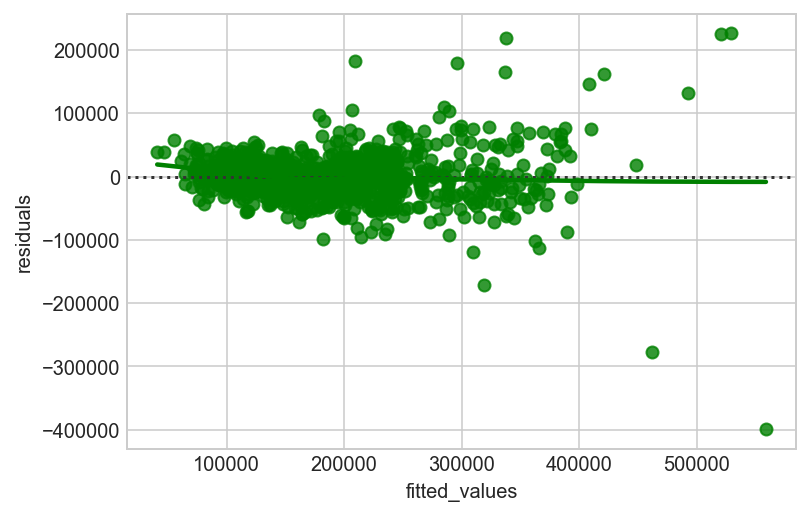

In [49]:
# 3.3 Least squares model stability check
# Plot the residuals against fitted values, they should fluctuate about 0
resid = (model_sm2_4.resid).reshape((1278, 1))
fitted = (model_sm2_4.fittedvalues).reshape((1278, 1))
resfit_data = pd.DataFrame(data=np.concatenate((resid, fitted), axis=1), columns=['residuals', 'fitted_values'])

_ = sns.residplot(x='fitted_values', y='residuals', lowess=True, color="g", data=resfit_data)
    
# Proceed to check it formally
formula3 = 'residuals ~ fitted_values'
pat_y3, pat_X3 = patsy.dmatrices(formula3, data=resfit_data)

zero_cond = sm.OLS(pat_y3, pat_X3).fit()
zero_cond.summary()
    # Visually, the plot appears symmetrical and clustered to values between 100000 and 200000 which indicates some
    # form of stability of the model. However, there's a fan-like trend which indicates persisting heteroskedastic errors
    # Other forms of corrected standard errors may be implemented, however the current model is adequately stable enough
    # for evaluations
    
# Our least squares estimators are likely to be unbiased since filtering was done before regressions to avoid multicollinear
# issues

In [50]:
# 3.4 Sanity check using cross-validation
# For sanity check, perform 5/10 fold Cross-Validation on Data to verify model obtained is decent enough
    # If so, we can proceed to predict 'SalePrice' in 2010 using data before then

# Perform regular, standardised and min-max adjusted CV. regression.
lm = LinearRegression()

X = resident_pre2010[final_fx4]
y = resident_pre2010['SalePrice'].values

# X-validate with 10 folds, no holdout
r2_10F = cross_val_score(lm, X, y, cv=10)
print('Mean 10 fold X-validated R-sq Score:', np.mean(r2_10F), 's.d. of R-sq:', np.std(r2_10F))

# X-validate with 5 folds, no holdout
r2_5F = cross_val_score(lm, X, y, cv=5)
print('Mean 5 fold X-validated R-sq Score:', np.mean(r2_5F), 's.d. of R-sq:', np.std(r2_5F))

# Deviations in the R-squared values are minimal regardless of 5 or 10 X-validation, the model is stable enough

Mean 10 fold X-validated R-sq Score: 0.80356862048 s.d. of R-sq: 0.0645247661567
Mean 5 fold X-validated R-sq Score: 0.798218334938 s.d. of R-sq: 0.0418796846765


In [51]:
# 3.5 Using built model to predict 2010 'SalePrice' and evaluate accuracy of model
# Split the data into 2010 and pre-2010

# Using 'fx_date_and_cat', we have 5 datetime variables
print('Datetime features: ', fx_date_and_cat)
    # We only need 'SalePrice' to be before 2010, whether the house was modified later in 2010 or not should not matter as
    # 'SalePrice' ought to be captured during its time of transaction - We shall use 'YrSold' as the filter
        # It is an assumption that we shall hold it as true

# Pre-2010 data
mask_pre2010 = resident['YrSold'] < 2010
resident_pre_2010 = resident[mask_pre2010]

X_pre2010 = resident_pre_2010[final_fx4]
y_pre2010 = resident_pre_2010['SalePrice'].values

# 2010 data
mask_2010 = resident['YrSold'] == 2010
resident_2010 = resident[mask_2010]

X_2010 = resident_2010[final_fx4]
y_2010 = resident_2010['SalePrice'].values

# Obtain prediction accuracy
model3 = lm.fit(X_pre2010, y_pre2010)
predictions = model3.predict(X_2010)
print('R-squared score: ', metrics.r2_score(y_2010, predictions))
    # While the R-squared scores are high, 0.824, we should also check for the prediction accuracy

# To evaluate how well the predicted values model variations seen in 'y_2010'
print('Explained variance score', metrics.explained_variance_score(y_2010, predictions))
    # Since the explained variance is near similar to the r-squared value, the mean of the errors are near zero
    # Source: https://stats.stackexchange.com/questions/210168/what-is-the-difference-between-r2-and-variance-score-in-scikit-learn

Datetime features:  ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']
R-squared score:  0.816582023825
Explained variance score 0.817494445526


In [52]:
### [3] END OF REGRESSION ANALYSIS / CONCLUSION OF SECTION 3 ###

We have built a fairly robust model that is capable of predicting 2010 'SalePrice' values with R-squared value of 0.8166 and explained variance by approximately 81.75%.

For added robustness checks, we could perform a Ramsey's RESET to check if the explained ('SalePrice') could be explained by higher powers of the x_i's as part of checking for omitted variable errors.

For added robust checks, we performed 5 and 10-fold cross validations and see that the deviations of the R-squared values are near 0 value.

While efforts to filter out variables with high collinearity against others as well as correcting for heteroskedasticity were made, the residual plots still indicate a heteroskedastic behaviour. Further investigations in the future may include exploring other forms of White-corrected standard errors on top of the vanilla version implemented

Possible extensions include using SMOTE to generate synthetic data for features that are imbalanced. Perhaps results would be different both in terms of which explanatory variables can help predict price as well as the accuracy of the model.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [53]:
# A:

In [54]:
### Preliminary ###
# Remaining unexplained variances are captured in the residuals
    # While the residuals are on average 0, we shall see if variable features are capable of explaining 'SalePrice'
    # All features used for analysis against the residuals from part 1 will be controllable features

residuals = (model_sm2_4.resid).reshape((1278, 1))

# Non-fixed features
    # We will not be using 'var_ft_unc' == ['MiscVal', 'SaleType', 'SaleCondition', 'SalePrice'] since 'SalePrice' is used
    # as the explained variable while the rest are either uncontrollable or make no direct economic sense in affecting the
    # value of the house
print('No. of variable features (controllable): ', len(var_ft_c))
print('Variable features (controllable): ', var_ft_c, '\n')

# Variable and categorical
var_ft_c_cat = list(set(var_ft_c).intersection(set(cat_ft)))
print('No. of variable controllable categoricals: ', len(var_ft_c_cat))
print('Variable controllable categoricals: ', var_ft_c_cat, '\n')

# Variable and non-categorical
var_ft_c_noncat = list(set(var_ft_c).difference(set(cat_ft)))
print('No. of variable controllable non-categoricals: ', len(var_ft_c_noncat))
print('Variable controllable non-categoricals: ', var_ft_c_noncat, '\n')

No. of variable features (controllable):  29
Variable features (controllable):  ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'] 

No. of variable controllable categoricals:  23
Variable controllable categoricals:  ['CentralAir', 'PoolQC', 'ExterCond', 'GarageQual', 'Exterior1st', 'MasVnrType', 'Electrical', 'RoofMatl', 'KitchenQual', 'Functional', 'HeatingQC', 'PavedDrive', 'BsmtFinType1', 'GarageFinish', 'BsmtCond', 'Heating', 'Exterior2nd', 'Fence', 'GarageCond', 'FireplaceQu', 'RoofStyle', 'ExterQual', 'BsmtFinType2'] 

No. of variable controllable non-categoricals:  6
Variable controllable non-categoricals:  ['BsmtFinSF2', 'OverallCond'

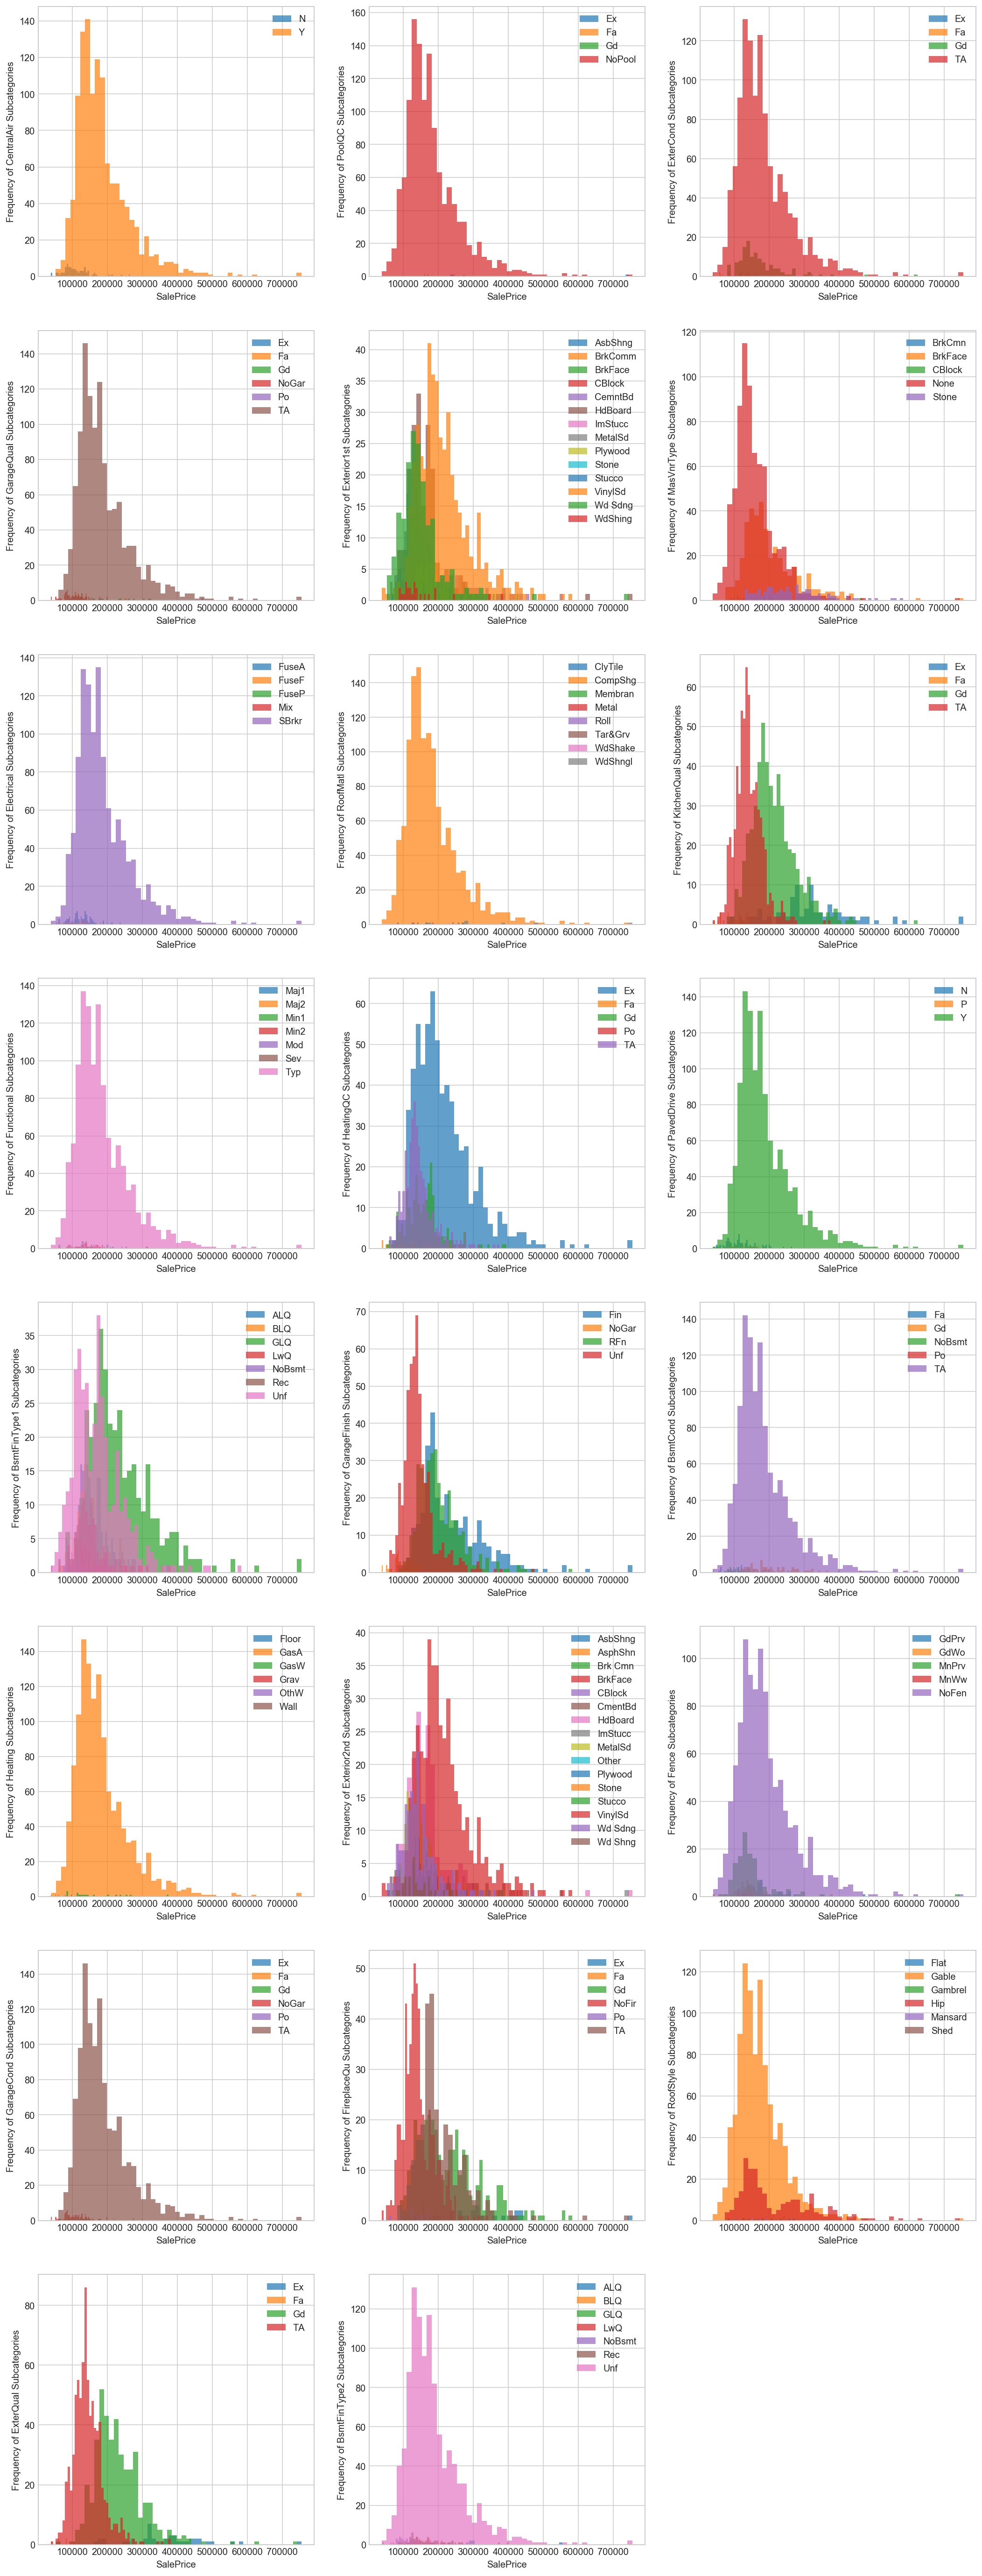

In [55]:
### [1] EDA ###
# 1.1.1 Categorical variable features
    # Obtain histplots against 'SalePrice'
_ = plt.figure(figsize=(18,50))
for plot, var in enumerate(var_ft_c_cat):
    _ = plt.subplot(8, 3, (plot+1))
    temp_df2 = resident_pre2010[['SalePrice', var]]
    temp_df_grouped2 = temp_df2.groupby(by=var)
    temp_df_grouped2['SalePrice'].plot(kind='hist', bins=50, alpha=0.7, legend='best')
    _ = plt.xlabel('SalePrice'); _ = plt.ylabel('Frequency of ' + var + ' Subcategories')

In [56]:
# 1.1.2 Categorical variable feature selection
# Exclude features for near negligible alternate subcategories to the dominant subcateogry
    # 'PavedDrive', 'BsmtCond', 'GarageCond', 'BsmtFinType2', 'CentralAir', 'PoolQC',
    # 'RoofMatl', 'GarageQual', 'Functional', 'Heating', 'Electrical'
excl_varft_cat = ['PavedDrive', 'BsmtCond', 'GarageCond', 'BsmtFinType2', 'CentralAir', 'PoolQC', 'RoofMatl',
              'GarageQual', 'Functional', 'Heating', 'Electrical']

In [57]:
# 1.1.3 Disambiguate unclear overlapping histogram plots
# Investigate the rest of the variables via individual distribution plots (the hist-overlaps make it hard to distinguish)
remnant_varft_cat = [feat for feat in var_ft_c_cat if feat not in excl_varft_cat]
print(remnant_varft_cat)

def plot_cat(feat, y_var, data, img_w, img_h, subplot_rows, subplot_columns, y_max):
    """ Plotting subcategories of categorical variables """
    sub_cat = list(data[feat].unique())
    _ = plt.figure(figsize=(img_w, img_h))
    
    for plot, subc in enumerate(sub_cat):
        mask = data[feat] == subc
        temp_df = data[mask][[y_var, feat]]
        
        _ = plt.subplot(subplot_rows, subplot_columns, (plot+1))
        temp_df['SalePrice'].plot(kind='hist', bins=50, alpha=0.7, legend='best', ylim=(0, y_max))
        _ = plt.ylabel('Freq/' + subc); _ = plt.xlabel(y_var)

['ExterCond', 'Exterior1st', 'MasVnrType', 'KitchenQual', 'HeatingQC', 'BsmtFinType1', 'GarageFinish', 'Exterior2nd', 'Fence', 'FireplaceQu', 'RoofStyle', 'ExterQual']


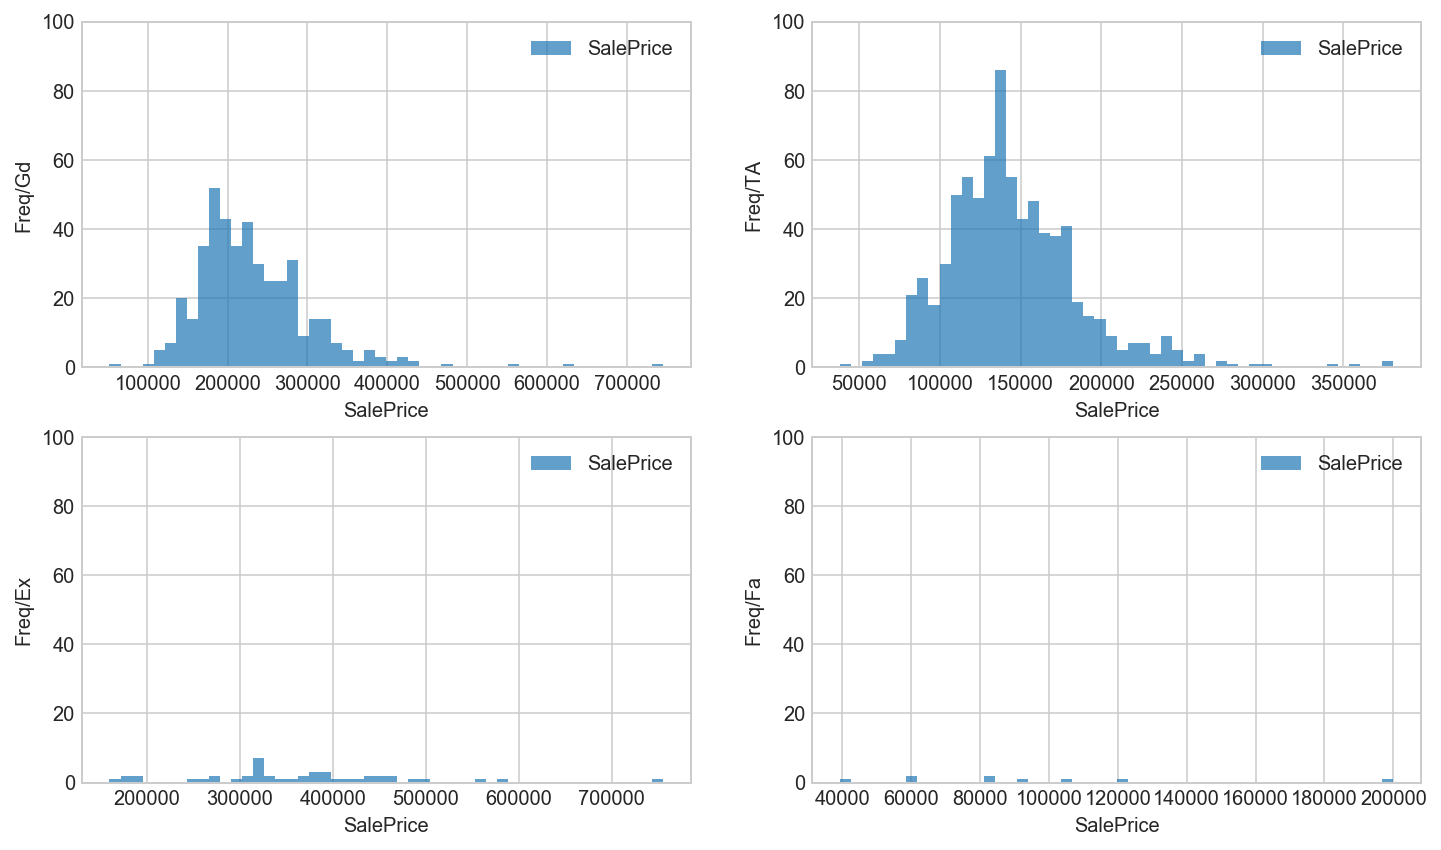

In [58]:
# 1.1.3.1 'ExterQual'
plot_cat('ExterQual', 'SalePrice', resident_pre2010, 12, 7, 2, 2, 100)
    # Use 'TA', 'Gd'

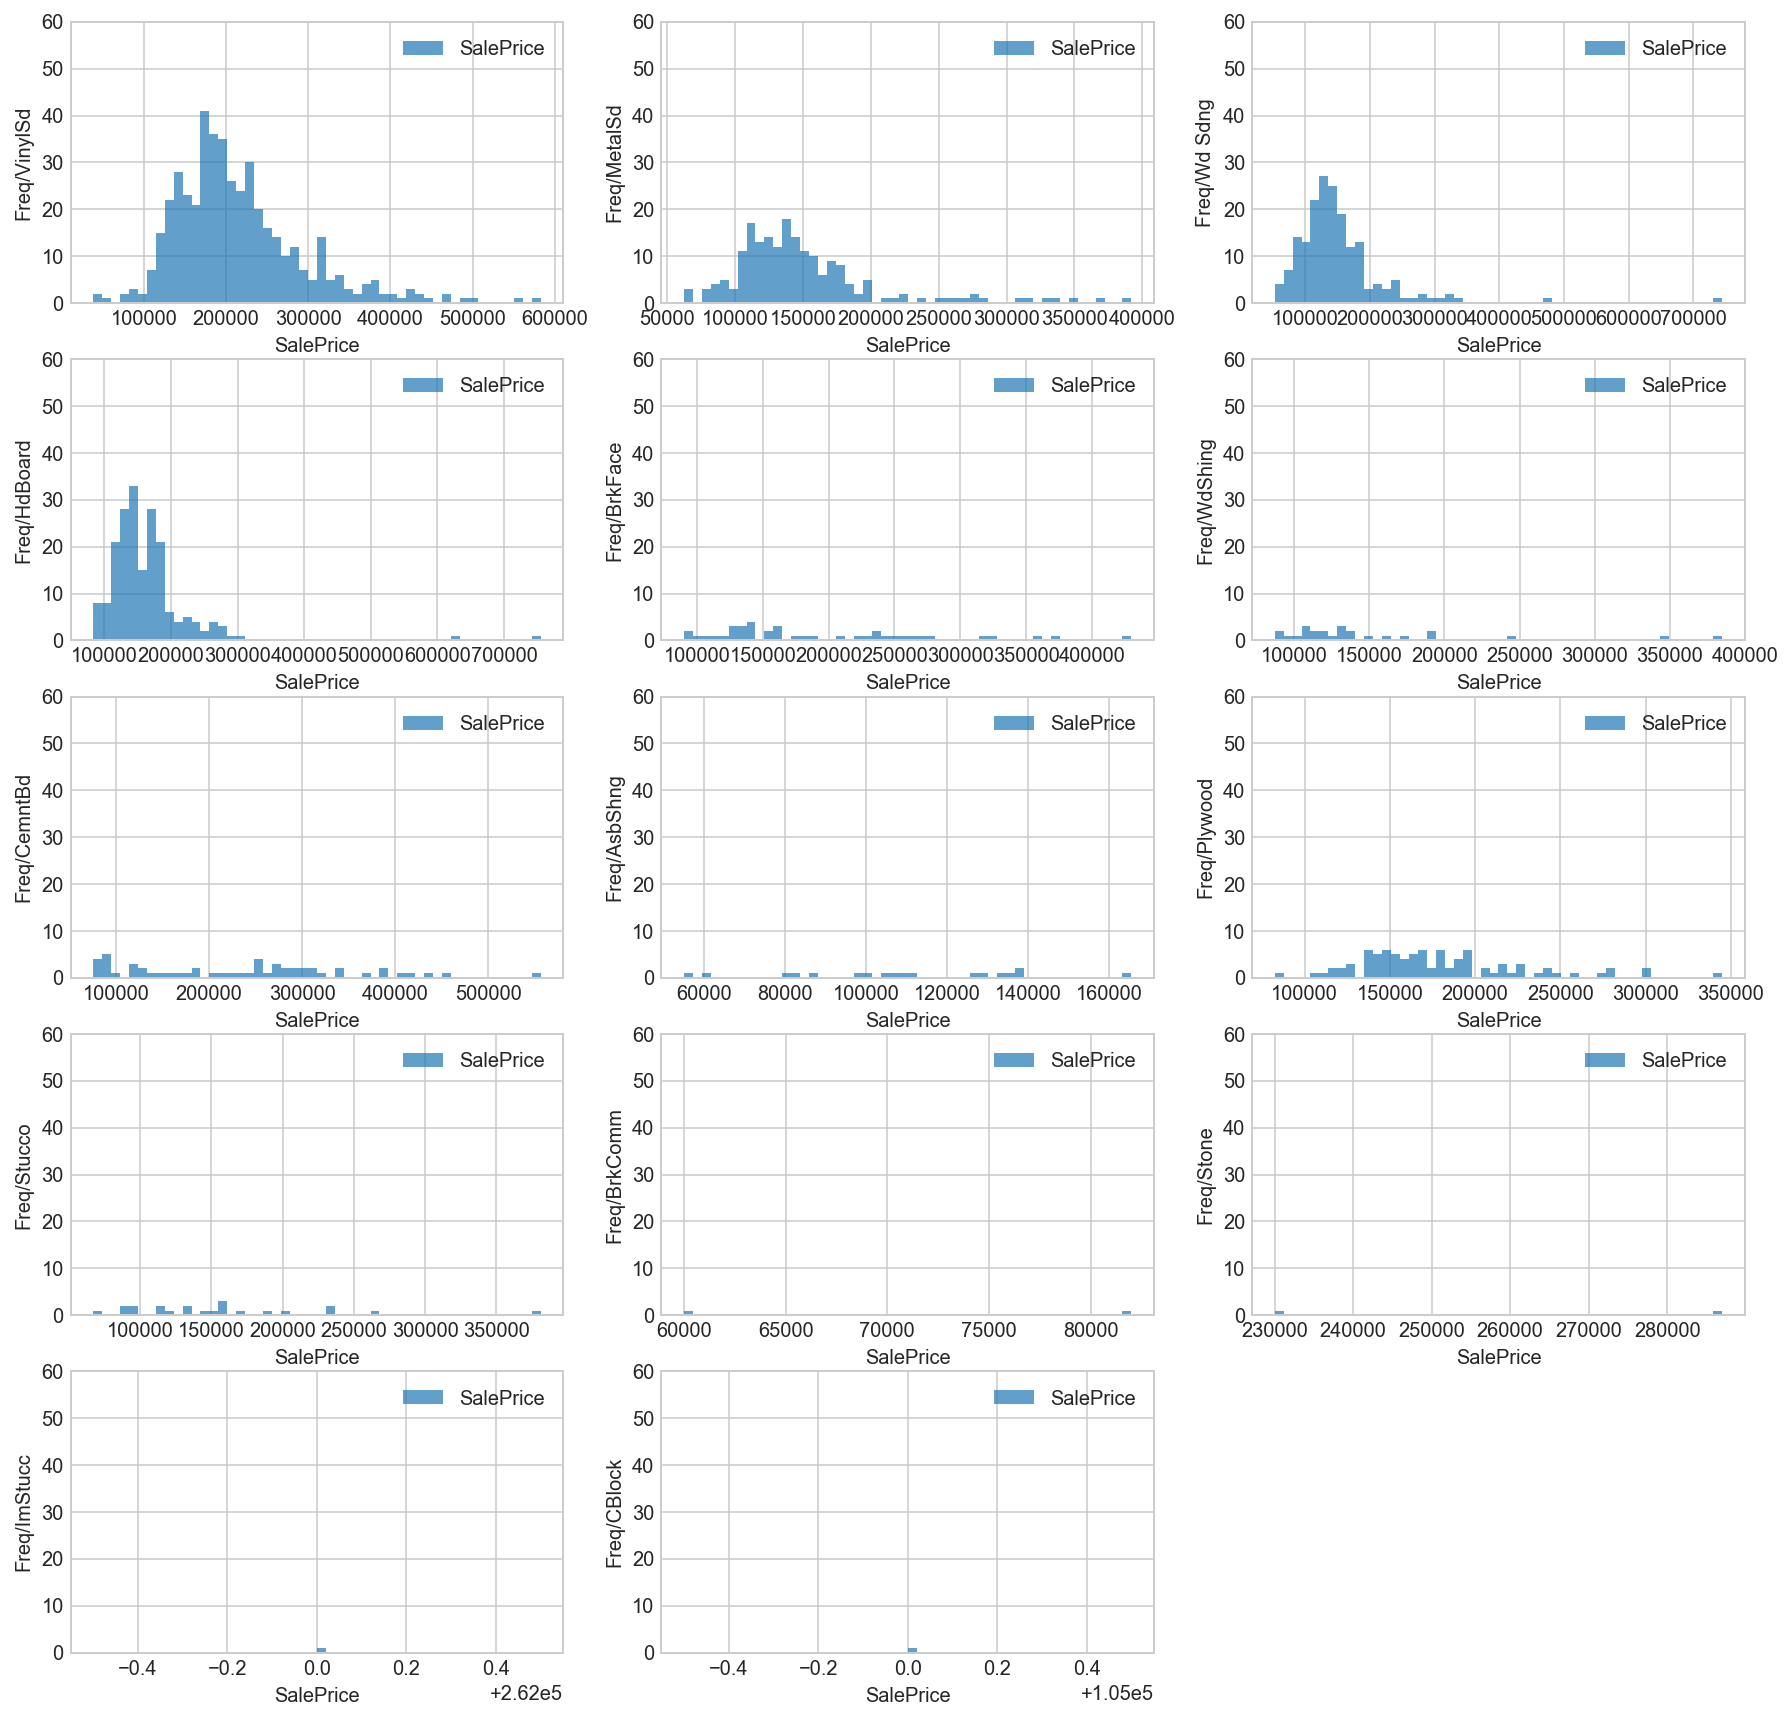

In [59]:
# 1.1.3.2 'Exterior1st'
plot_cat('Exterior1st', 'SalePrice', resident_pre2010, 15, 15, 5, 3, 60)
    # Use 'VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'Plywood'

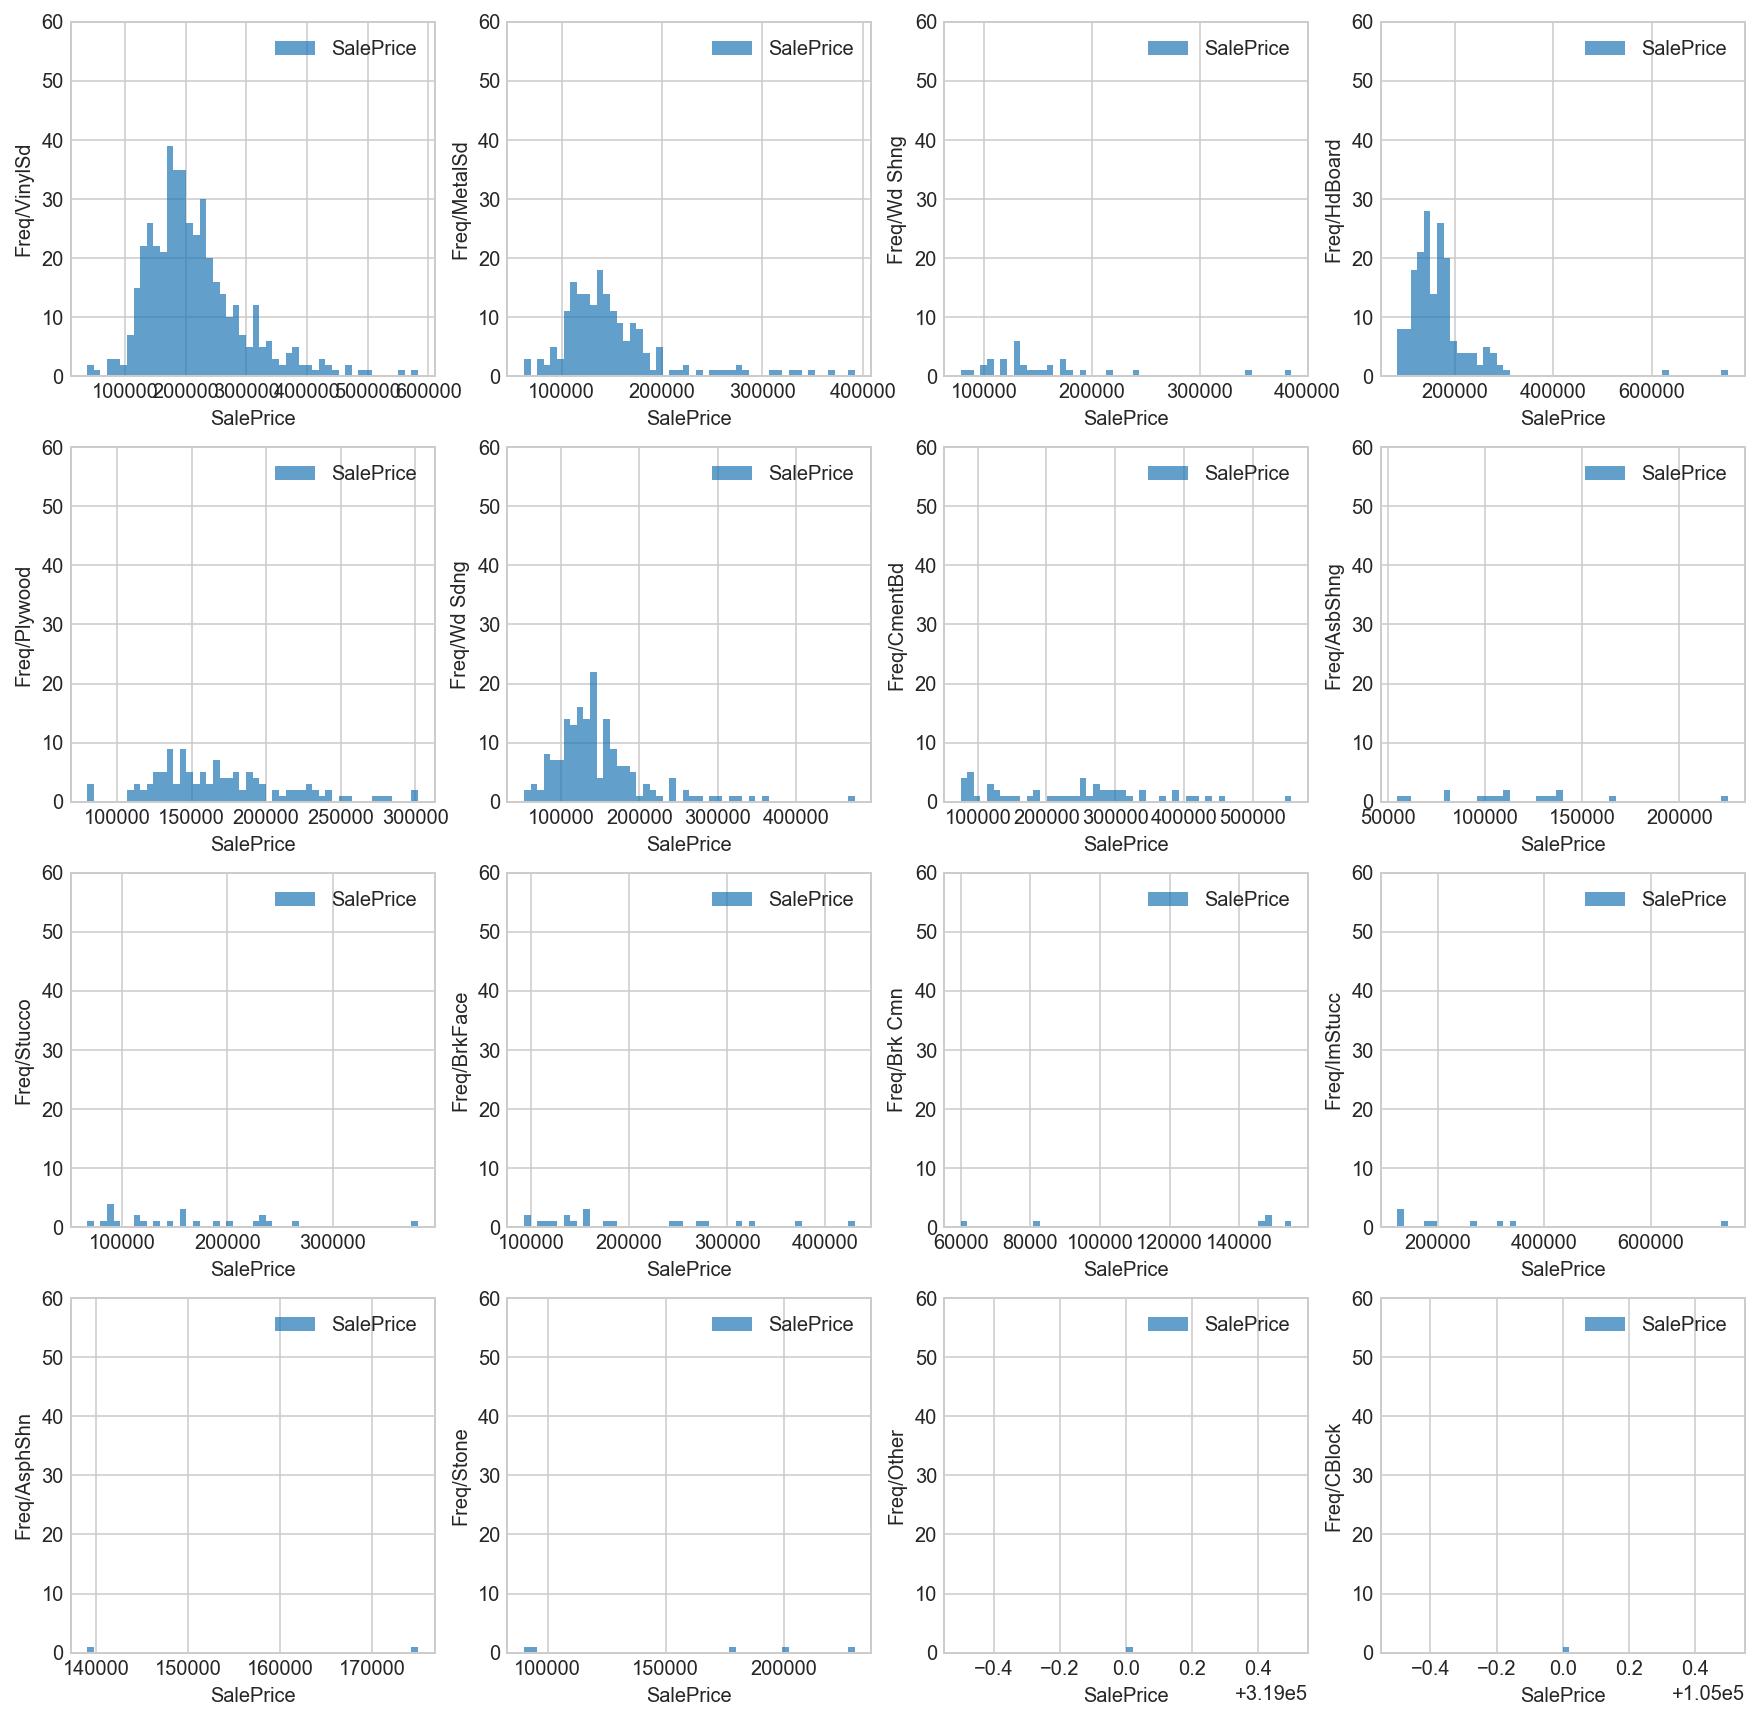

In [60]:
# 1.1.3.3 'Exterior2nd'
plot_cat('Exterior2nd', 'SalePrice', resident_pre2010, 15, 15, 4, 4, 60)
    # Use 'VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng'
        # 'Wd Shng' was labelled as 'WdShing' in the data dictionary

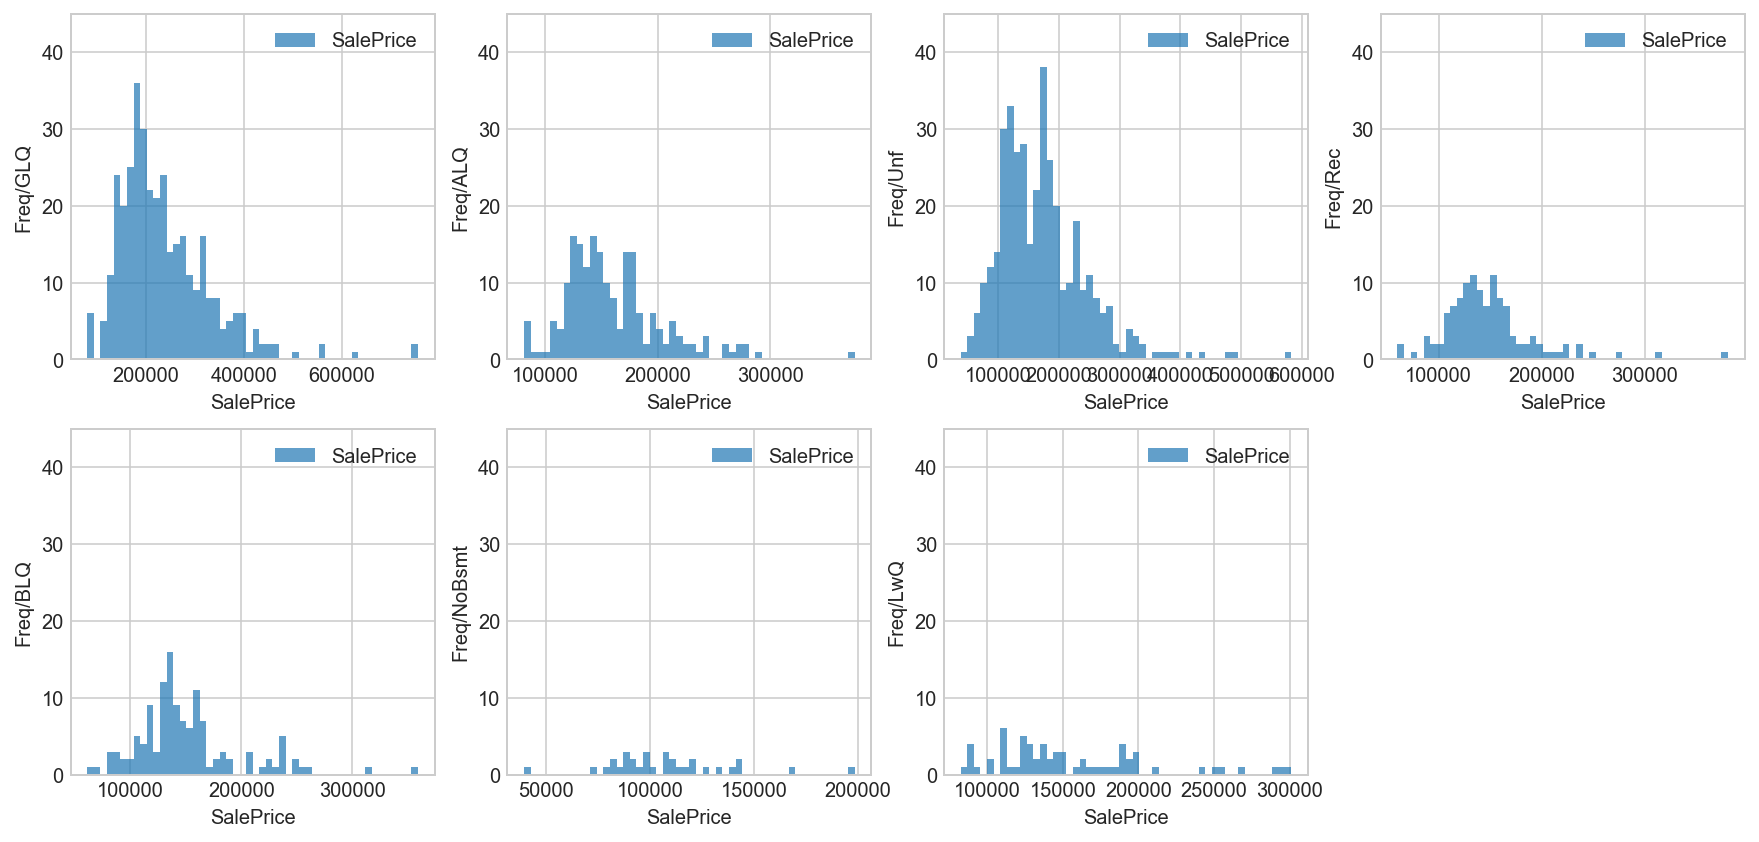

In [61]:
# 1.1.3.4 'BsmtFinType1'
plot_cat('BsmtFinType1', 'SalePrice', resident_pre2010, 15, 7, 2, 4, 45)
    # Use 'GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ'

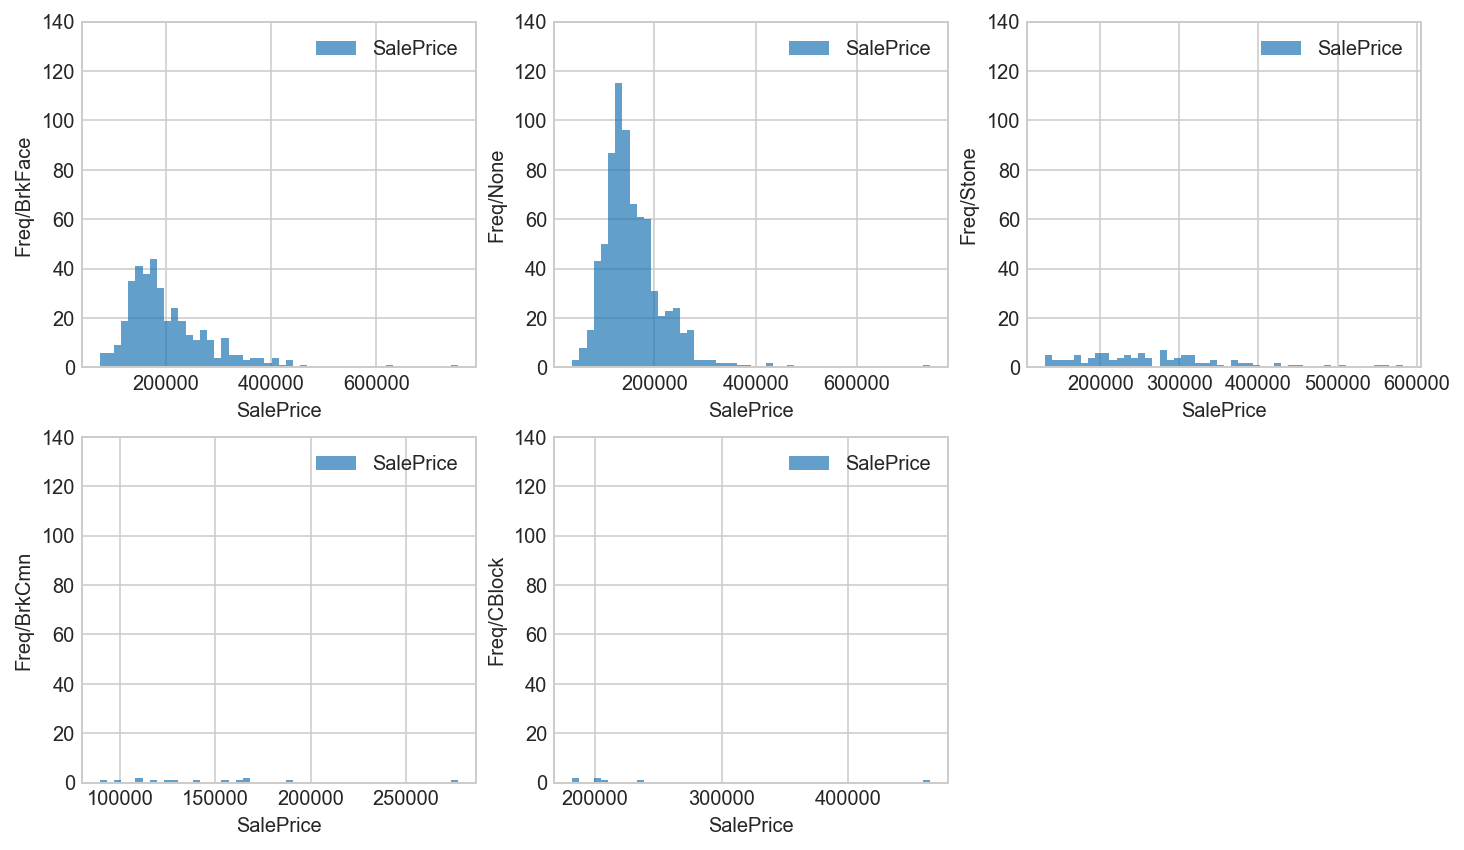

In [62]:
# 1.1.3.5 'MasVnrType'
plot_cat('MasVnrType', 'SalePrice', resident_pre2010, 12, 7, 2, 3, 140)
    # Use 'BrkFace', 'None', 'Stone'

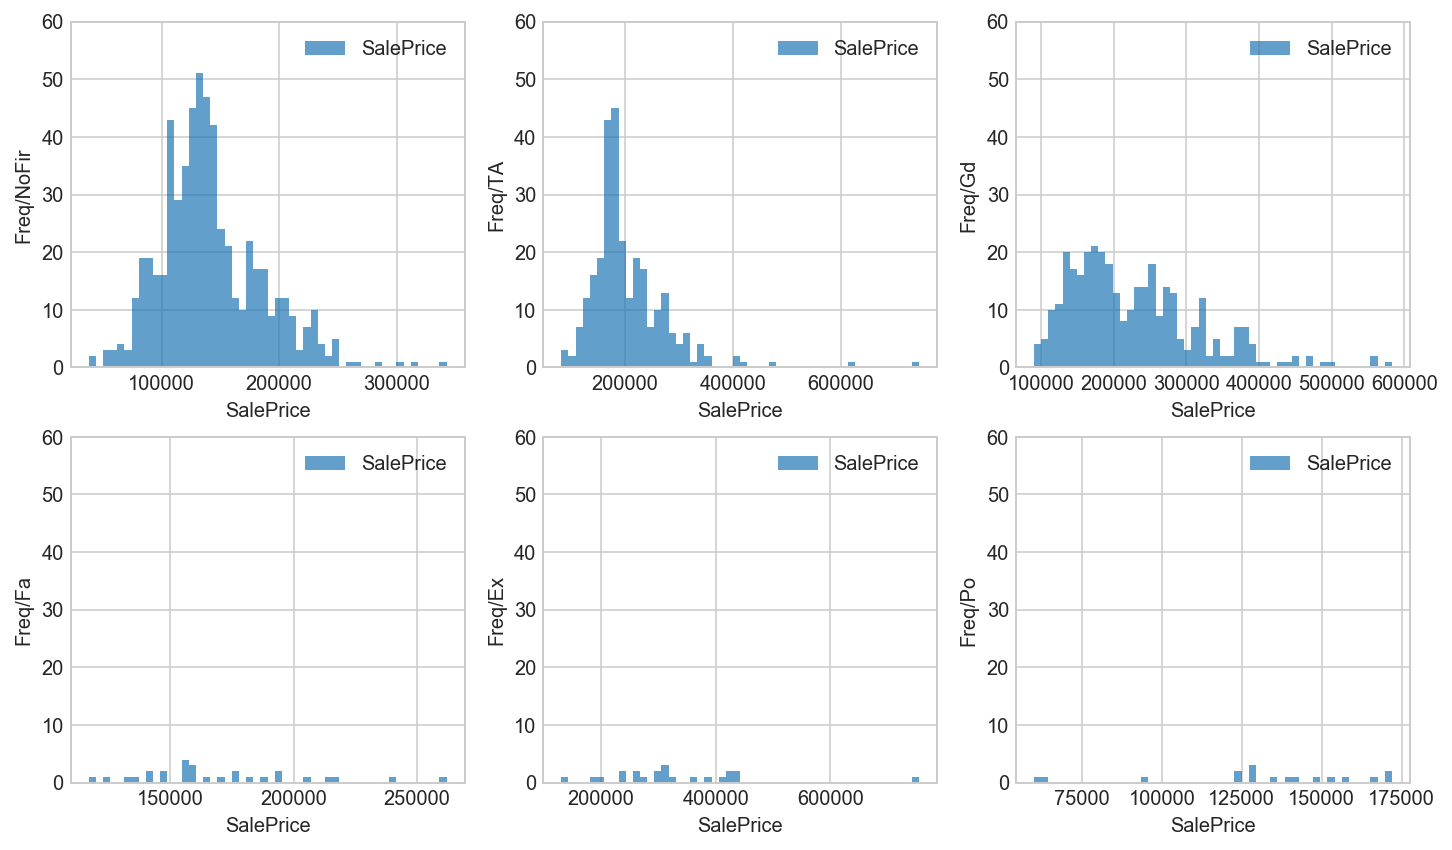

In [63]:
# 1.1.3.6 'FireplaceQu'
plot_cat('FireplaceQu', 'SalePrice', resident_pre2010, 12, 7, 2, 3, 60)
    # Use 'NoFir', 'TA', 'Gd'

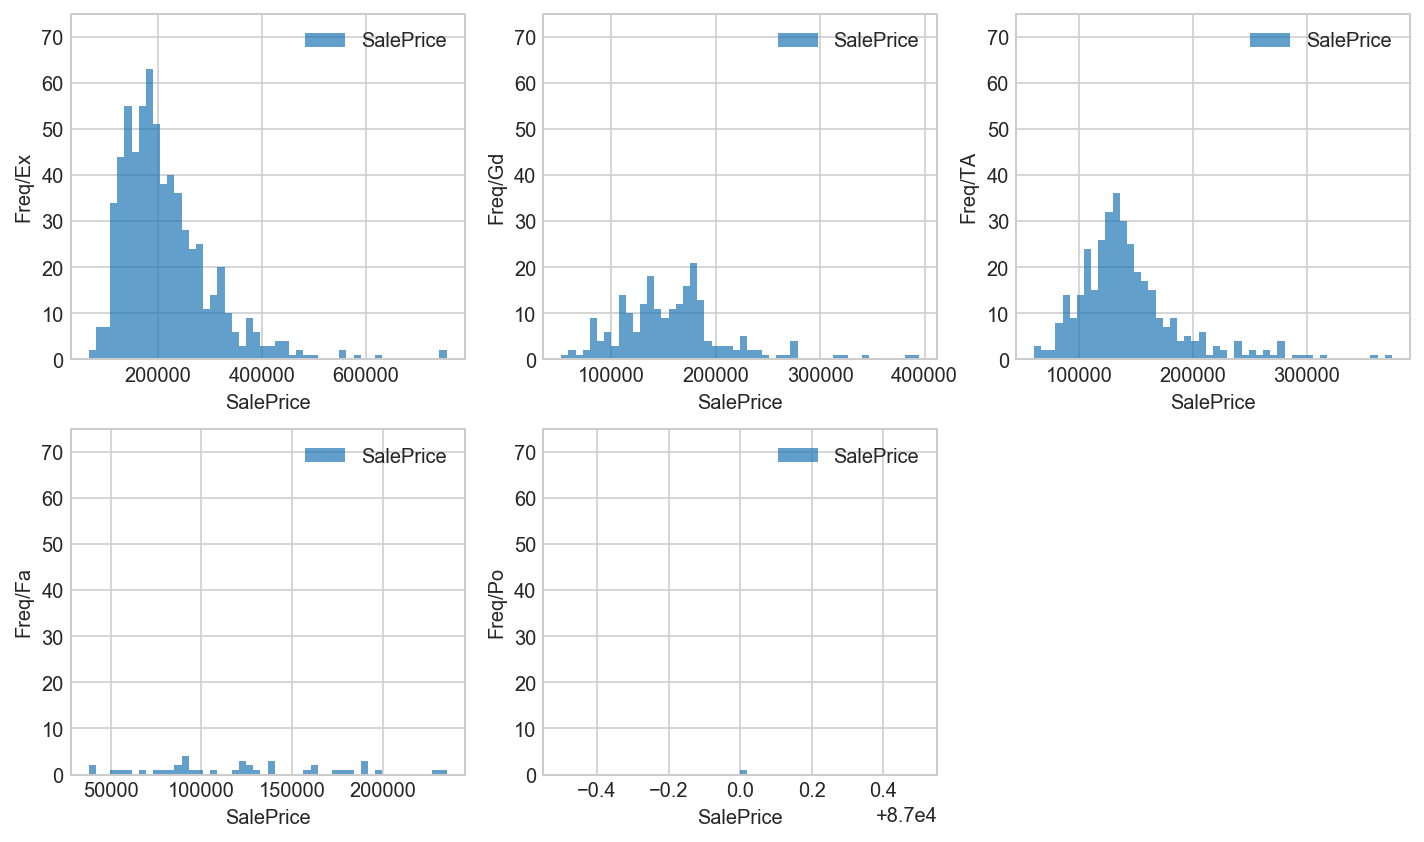

In [64]:
# 1.1.3.7 'HeatingQC'
plot_cat('HeatingQC', 'SalePrice', resident_pre2010, 12, 7, 2, 3, 75)
    # Use 'Ex', 'Gd', 'TA'

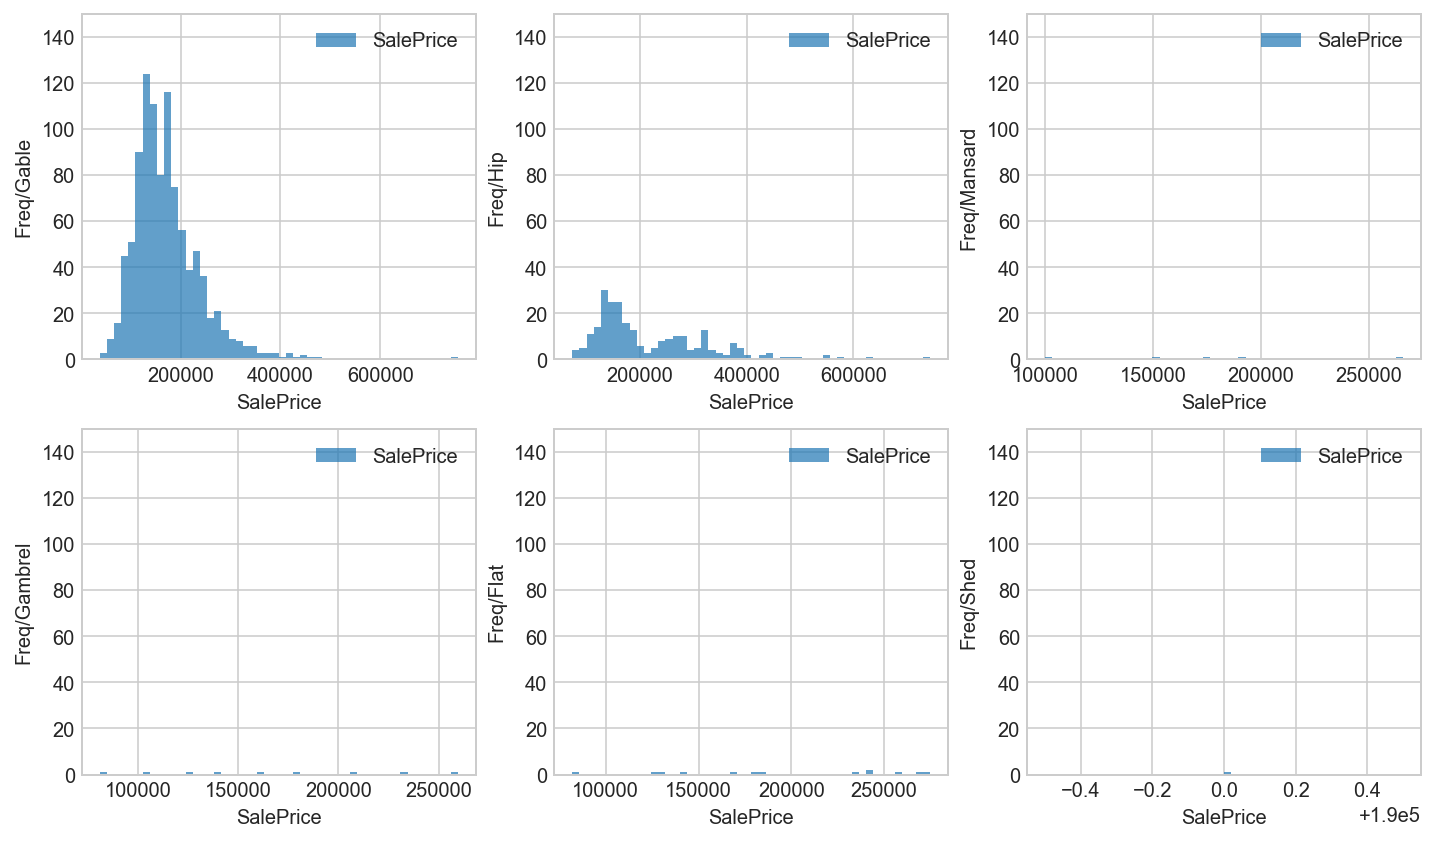

In [65]:
# 1.1.3.8 'RoofStyle'
plot_cat('RoofStyle', 'SalePrice', resident_pre2010, 12, 7, 2, 3, 150)
    # Use 'Gable', 'Hip'

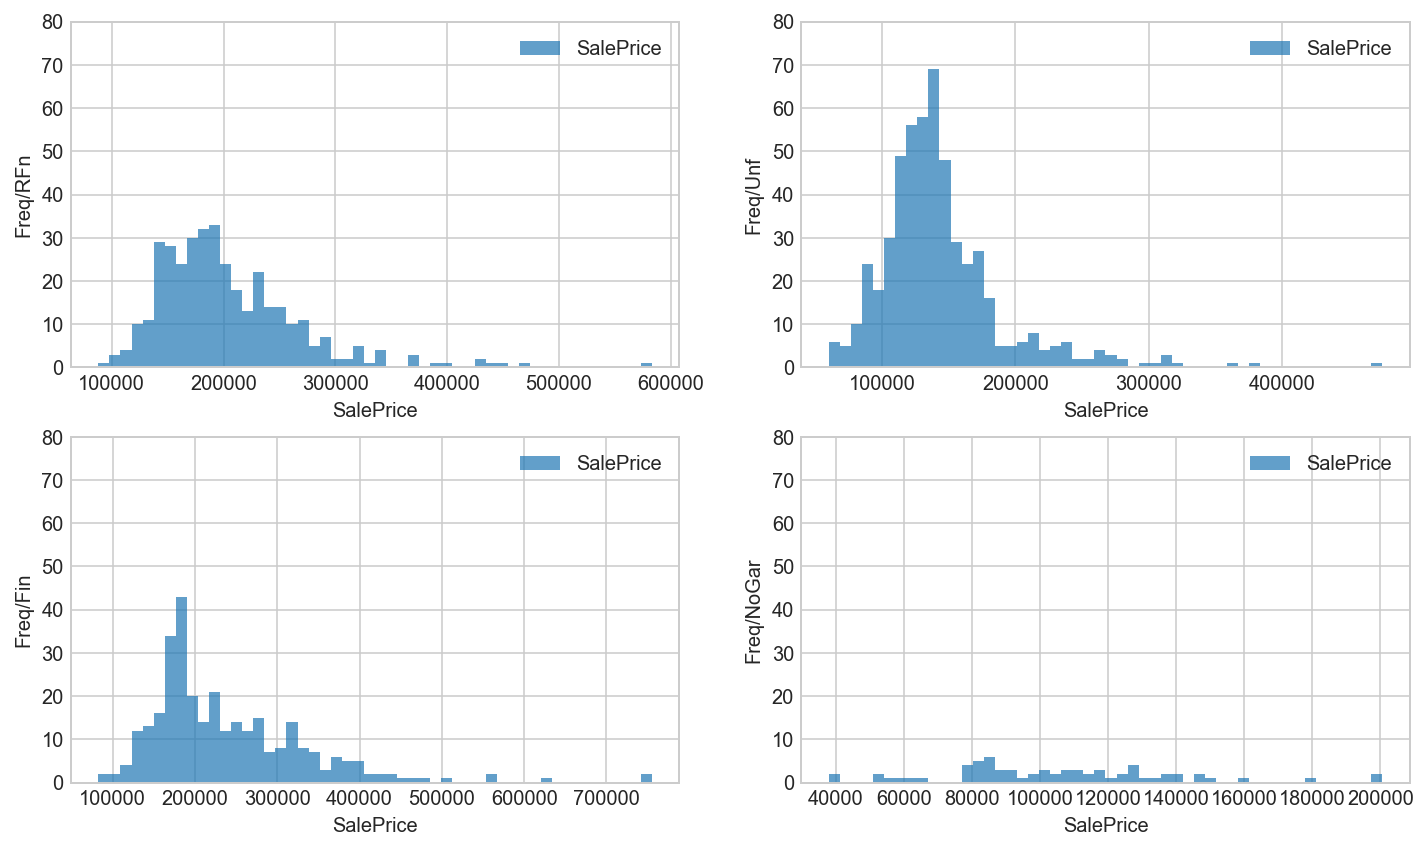

In [66]:
# 1.1.3.9 'GarageFinish'
plot_cat('GarageFinish', 'SalePrice', resident_pre2010, 12, 7, 2, 2, 80)
    # Use 'RFn', 'Unf', 'Fin'

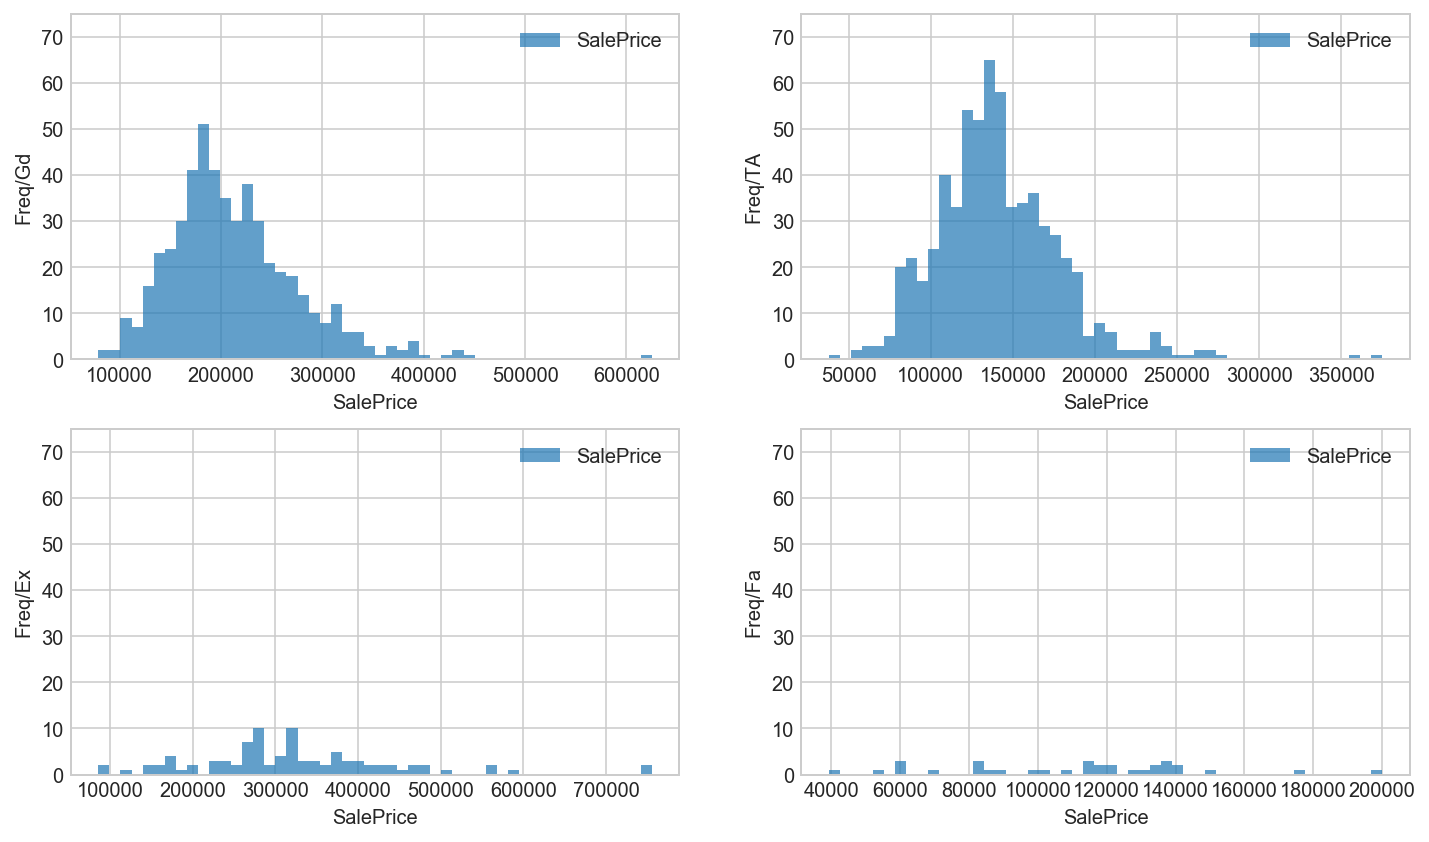

In [67]:
# 1.1.3.10 'KitchenQual'
plot_cat('KitchenQual', 'SalePrice', resident_pre2010, 12, 7, 2, 2, 75)
    # Use 'TA', 'Gd'

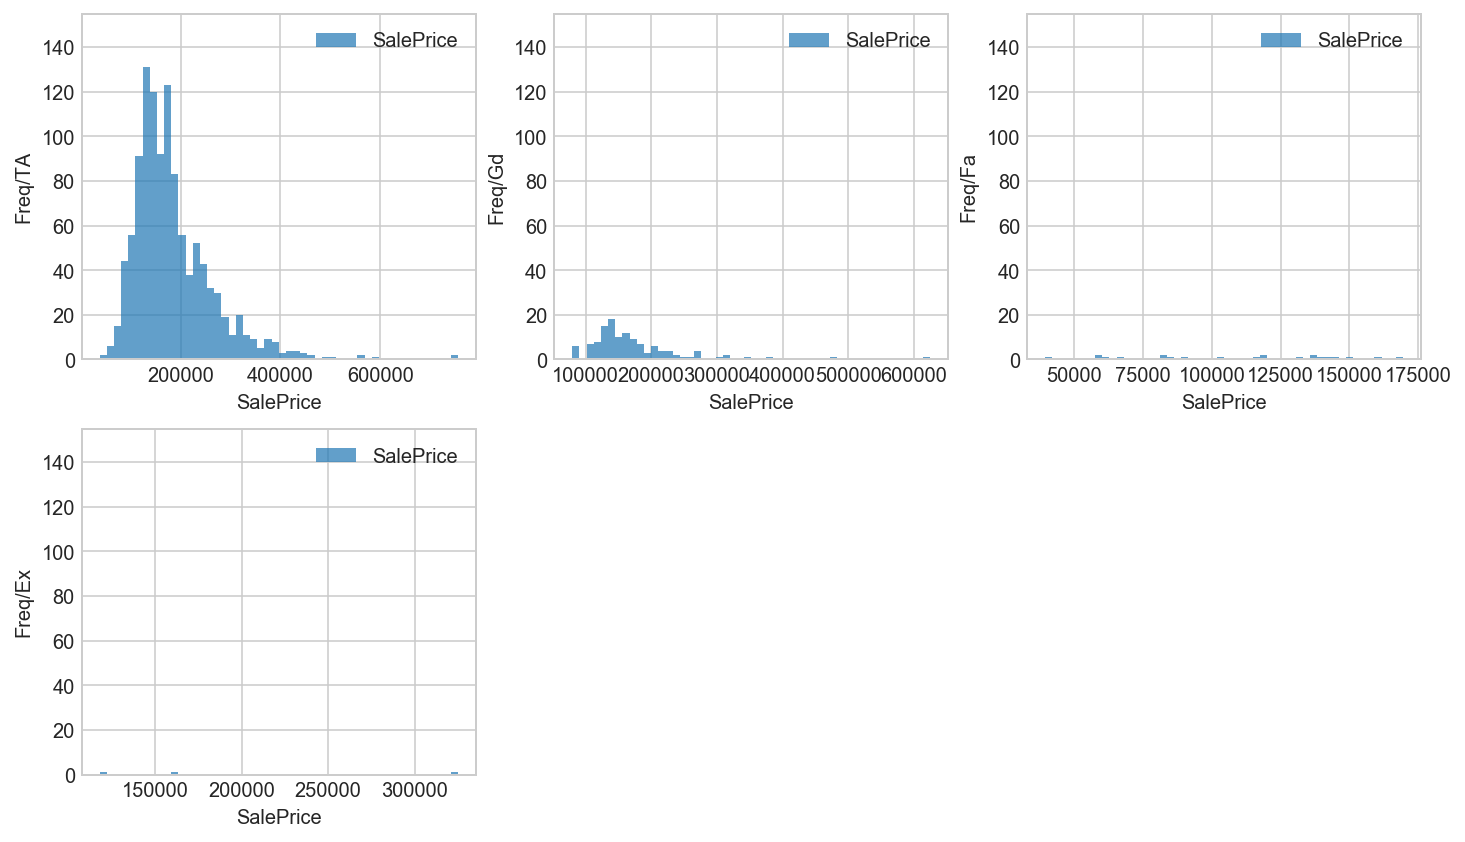

In [68]:
# 1.1.3.11 'ExterCond'
plot_cat('ExterCond', 'SalePrice', resident_pre2010, 12, 7, 2, 3, 155)
    # Use 'TA', 'Gd'

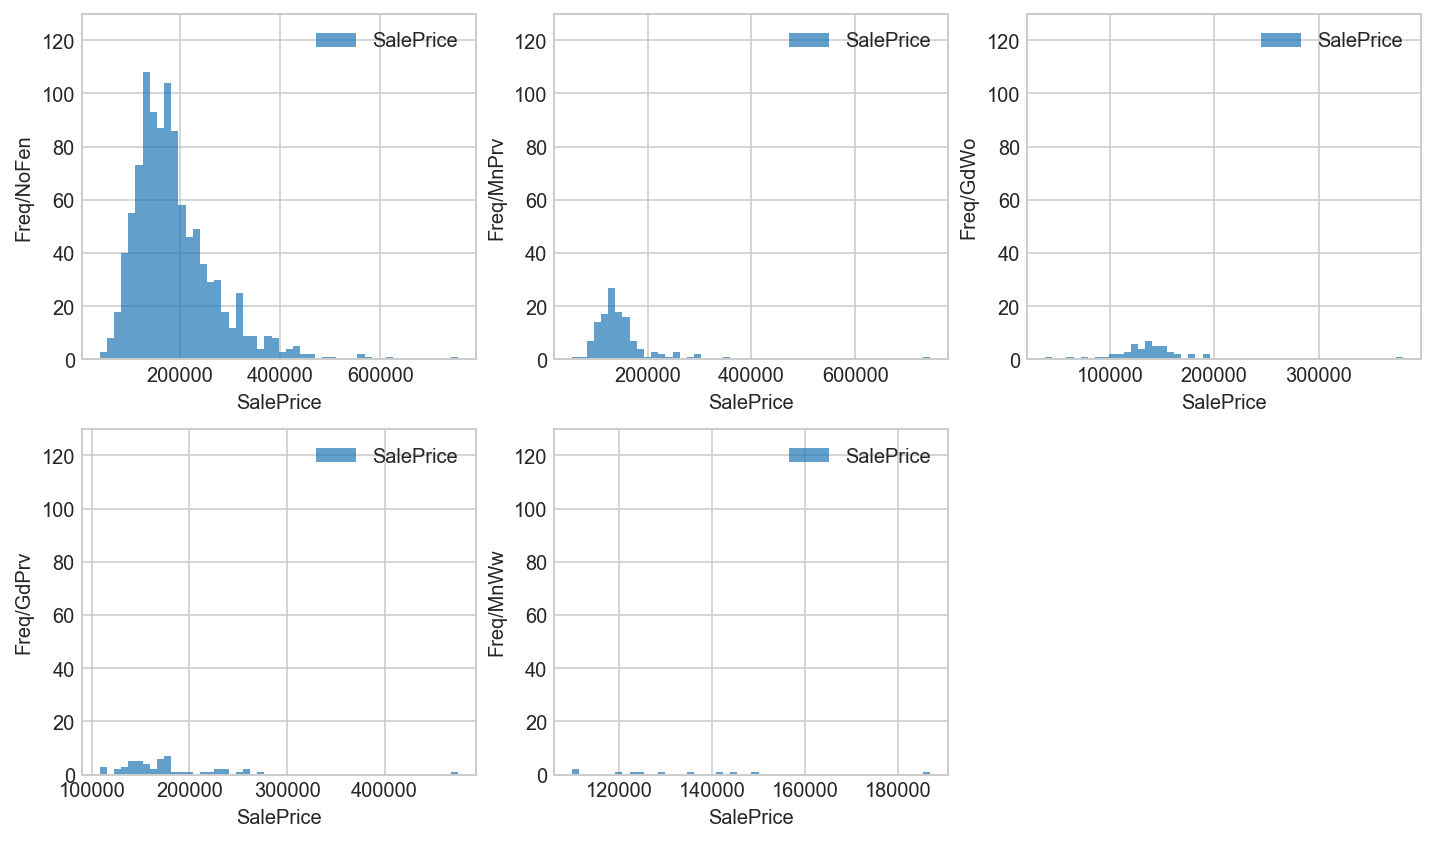

In [69]:
# 1.1.3.12 'Fence'
plot_cat('Fence', 'SalePrice', resident_pre2010, 12, 7, 2, 3, 130)
    # Use 'NoFen', 'MnPrv'

In [70]:
# 1.1.4 Summary of chosen variable features, categorical
# Based on the histogram plots above, the following subcategories are chosen for their significance and variation
    # 'Fence' - 'NoFen', 'MnPrv'
    # 'ExterCond' - 'TA', 'Gd'
    # 'KitchenQual' - 'TA', 'Gd'
    # 'GarageFinish' - 'RFn', 'Unf', 'Fin'
    # 'RoofStyle' - 'Gable', 'Hip'
    # 'HeatingQC' - 'Ex', 'Gd', 'TA'
    # 'FireplaceQu' - 'NoFir', 'TA', 'Gd'
    # 'MasVnrType' - 'BrkFace', 'None', 'Stone'
    # 'BsmtFinType1' - 'GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ'
    # 'Exterior2nd' - 'VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng'
        # 'Wd Shng' was labelled as 'WdShing' in the data dictionary
    # 'Exterior1st' - 'VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'Plywood'
    # 'ExterQual' - 'TA', 'Gd'
    
# Labels to rename for parsing through statsmodels/sklearn regression models later
resident_pre2010.rename(columns={'Exterior2nd_Wd Shng': 'Exterior2nd_WdShng', 'Exterior2nd_Wd Sdng': 'Exterior2nd_WdSdng'}, 
                index=str, inplace=True)
resident_pre2010.rename(columns={'Exterior1st_Wd Sdng': 'Exterior1st_WdSdng'}, index=str, inplace=True)

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


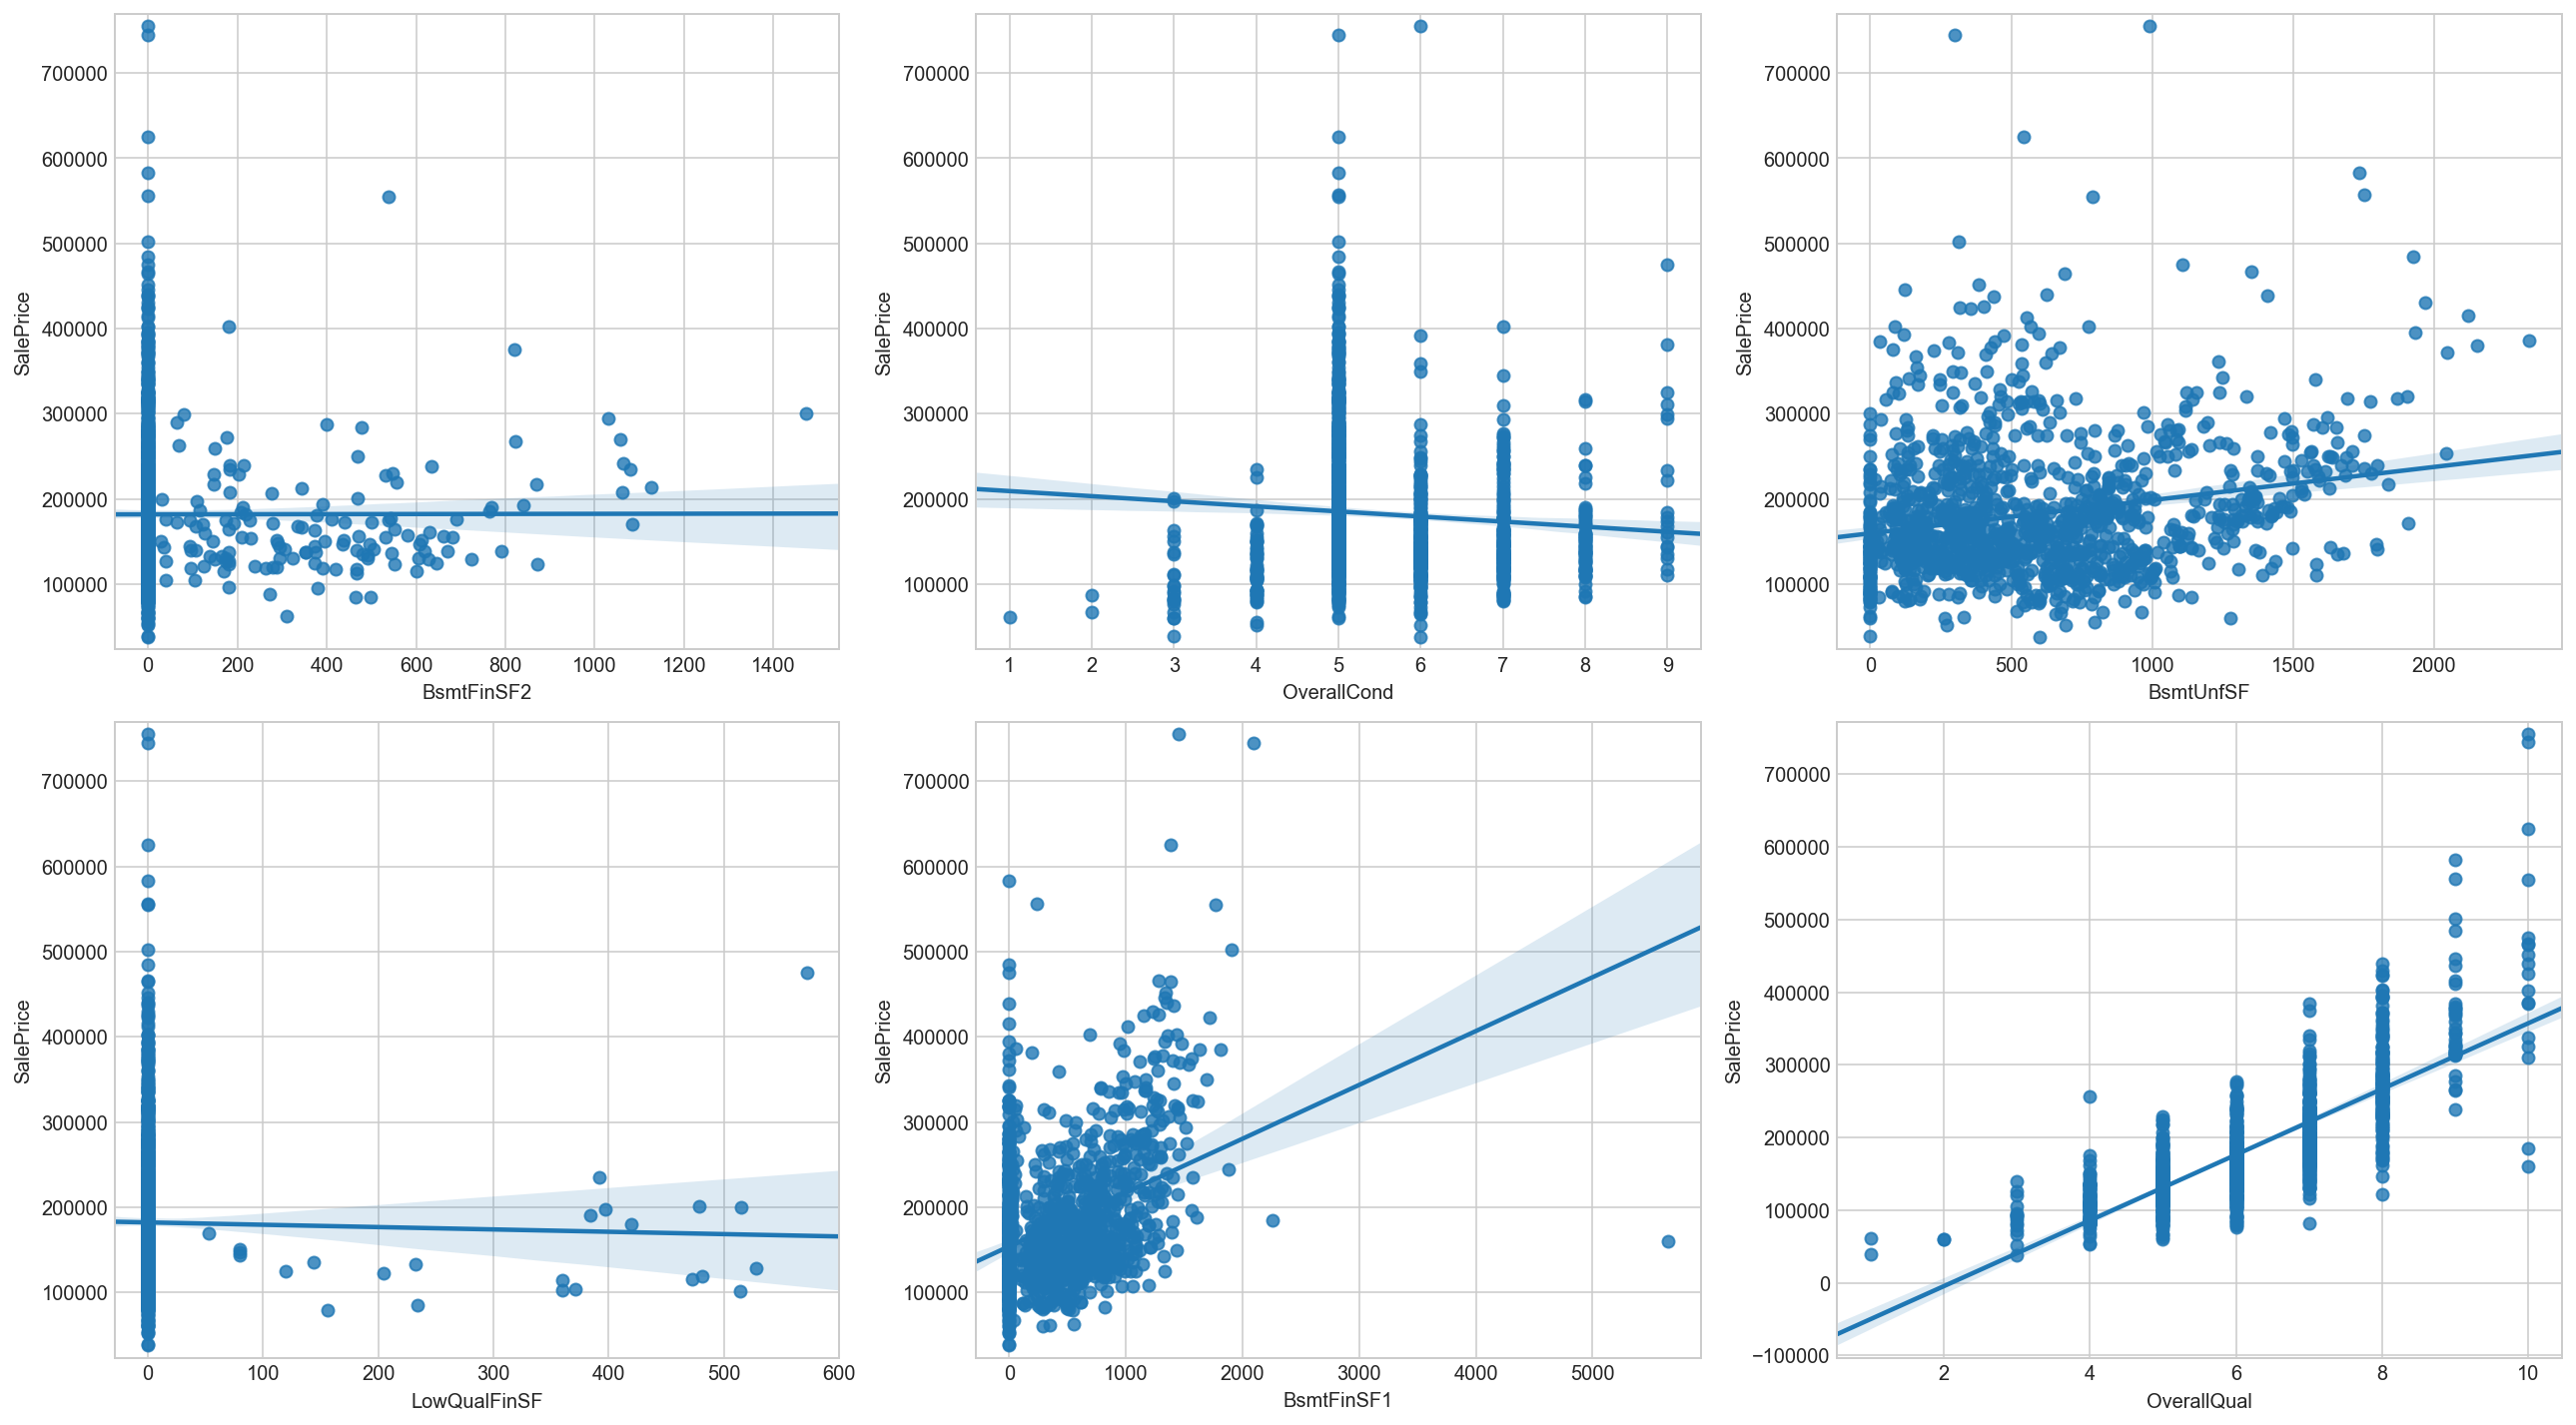

In [71]:
# 1.2.1 Plotting variable features, non-categorical

# Plot variables against 'SalePrice'
_ = plt.figure(figsize=(18, 10))
for plot, var in enumerate(var_ft_c_noncat):
    _ = plt.subplot(2, 3, (plot+1))
    _ = sns.regplot(y='SalePrice', x=var, data=resident_pre2010)
    _ = plt.xlabel(var); plt.ylabel('SalePrice'); plt.tight_layout(); plt.margins(0.02)

In [72]:
# 1.2.2 Evaluating plots

#### Features with clear positive correlations with 'SalePrice' <br>
\
    - [1] As 'OverallQual' of the building materials are rated higher, the higher the 'SalePrice' would be which is congruent to expectations that consumers are willing to pay a premium for higher quality built-homes.
    
    - [2] It appears too that 'BsmtFinSF1' is positively correlated with 'Saleprice'. While we are unable to note what kind of basement finish is the cause behind this positive relation, drawing information from the histplots of 'BsmtFinType1', the main driver could be 'GLQ' that results in this positive relationship with 'SalePrice'.
    
    This relationship would be even stronger if the clustered 0-points were removed in 'BsmtFinSF1'. This happens to reinforce the conjecture made in [1], consumers are willing to pay for better quality homes.
        
    - [3] 'BsmtUnfSF' appears positively correlated with 'SalePrice'. This does not mean that we should build homes with unfinished products as this relation is weakly positive to begin with. It is likely due to home buyers paying more as a result of increased home size, in this case the basement.
</br>        
#### Features with less clear correlations with 'SalePrice' <br>
\
    - [4] 'LowQualFinSF': the fitted line is relatively flat and intersects 'SalePrice' around $180,000. Examining the negatively (weakly) correlated relation with 'SalePrice', there may be a case of income and substitution effects; low quality homes are inferior goods: one decreases consumption on it with higher income.
    
    One may also argue that due to its imbalanced nature of 0-points, the regression is fitted negatively. The actual may be positive since home buyers would have to pay more for additional amount of space gained in their homes regardless of the quality of it - Assumes low quality homes are normal goods but makes a weak case!
        
    On the other, if this weak negative correlation has to be true then it may be due to a relative surplus of low quality homes that depresses the price for larger low-quality homes OR home buyers have preferences for higher quality homes hence a weak demand for such houses.
        - Based on the 0-point clusters, we may infer that the surplus argument of low quality homes may not hold since if there are many of such homes, there would not be a clustering about '0'
        - Observing 'OverallQual', it appears to support the argument of home buyers having preference for higher quality homes rather than low ones: if this argument is true then 'LowQualFinSF' ought to be negative w.r.t. 'SalePrice' - Then low quality homes are inferior goods which is a stronger case!
   
    - [5] 'OverallCond': the relationship is clear for ratings 1 to 5, a positive correlation with 'SalePrice' and would be similar to interpreting 'OverallQual' trends. However, this becomes less clear after ratings of 5. Possibly due to the imbalanced clustering of ratings of 5 (normal) that the fitted line reveal a negative relation w.r.t. 'SalePrice'.
        
    This makes no logical sense as to why people would pay less for higher quality unless the neighbourhood is filled with not so wealthy individuals that the demand for quality housing is poor - which is still a weak case to make! Additionally, since there are more datapoints lying from ratings 5 onwards and less on the other side, this could be the reason for this negative regression fitted line.
        
    To verify whether it is due to the imbalanced nature of the dataset in 'OverallCond', plot 'SalePrice' against 'OverallCond' for ratings != 5 or perform some randomised sampling for each of the ratings.
    
    - [6] 'BsmtFinSF2' may not have any added effects on 'SalePrice' after accounting for the 0-point clusters since home buyers are likely to view the entire basement as a whole unit rather than the kind of basement finishing differences.
    
    Referencing to 'BsmtFinType2' and 'BsmtFinType1', both features' majority class happen to be 'Unf' which denotes unfinished. Then, we may infer that home buyers regard the basement as one single unit than to split them into 2 separate mental accounts.
        
    If argument is true, then any effects of the basement's finishing type is fully reflected in 'BsmtFinSF1'. In subsequent regression analyses, it may not be wise to include both 'BsmtFinSF_'-'BsmtFinType_' pairs 1 and 2 together. To verify, we perform a distribution equality test between the dominant classes of 'BsmtFinType_' 1 and 2. If the null hypothesis cannot be rejected then this would explain why the fitted line in 'BsmtFinSF2' is horizontal because all its effects are fully reflected in 'BsmtFinSF1'

In [73]:
# Performing a KS-2 sample test between 'BsmtFinType1':'Unf' and 'BsmtFinType2':'Unf'
    # We shall take 'SalePrice' from the dominant class of 'Unf' in both 'BsmtFinType1' and 'BsmtFinType2' as
    # using the entire series would naturally be the same series hence failing to reject null hypothesis
    # Pick the top 3 sub-categories: 'Unf', 'GLQ' and 'ALQ' to reduce imbalanced comparison effects

# 'BsmtFinType1'
bft1_unf = resident_pre2010[(resident_pre2010['BsmtFinType1'] == 'Unf') | 
                   (resident_pre2010['BsmtFinType1'] == 'GLQ') |
                   (resident_pre2010['BsmtFinType1'] == 'ALQ')][['SalePrice','BsmtFinType1']]
    # Check length of 'Unf' data
print(bft1_unf.describe(include='all'))
    # Randomly sample 300 'SalePrice' values out without replacement
bft1_spx = np.random.RandomState(42).choice(bft1_unf['SalePrice'], size=300, replace=False)

# 'BsmtFinType2'
bft2_unf = resident_pre2010[(resident_pre2010['BsmtFinType2'] == 'Unf') |
                   (resident_pre2010['BsmtFinType2'] == 'GLQ') |
                   (resident_pre2010['BsmtFinType2'] == 'ALQ')][['SalePrice','BsmtFinType2']]
    # Check length of 'Unf' data
print(bft2_unf.describe(include='all'))
    # Randomly sample 300 'SalePrice' values out without replacement
bft2_spx = np.random.RandomState(42).choice(bft2_unf['SalePrice'], size=300, replace=False)

# Perform 2-sample KS-Test
stats.ks_2samp(bft1_spx, bft2_spx)
    # At 5% significance, we fail to reject that the two samples are drawn from the same distributions
    # Then we may conclude that home buyers do not explicitly view the basement in segments but rather as 1 single unit
    # Therefore any effects of 'BsmtFinType2' and 'BsmtFinSF2' are likely fully represented in 'BsmtFinType1' and 'BsmtFinSF1'

            SalePrice BsmtFinType1
count      938.000000          938
unique            NaN            3
top               NaN          Unf
freq              NaN          384
mean    194639.621535          NaN
std      84192.021300          NaN
min      37900.000000          NaN
25%     137625.000000          NaN
50%     177000.000000          NaN
75%     230000.000000          NaN
max     755000.000000          NaN
            SalePrice BsmtFinType2
count     1131.000000         1131
unique            NaN            3
top               NaN          Unf
freq              NaN         1104
mean    185877.897436          NaN
std      80975.742638          NaN
min      37900.000000          NaN
25%     132500.000000          NaN
50%     168000.000000          NaN
75%     221750.000000          NaN
max     755000.000000          NaN


Ks_2sampResult(statistic=0.063333333333333353, pvalue=0.57064367740015542)

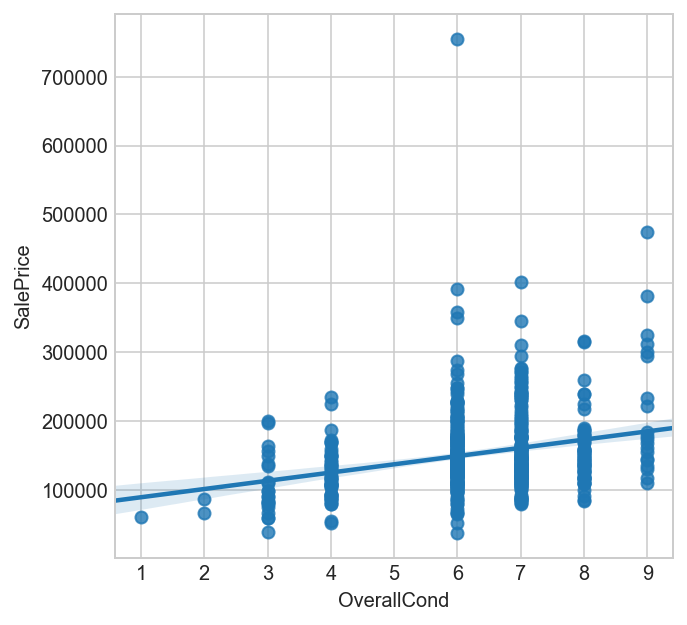

In [74]:
# 1.2.4.5 Removing 0-points and imbalanced data to evaluate consumer behaviour in determining 'SalePrice': Part IV
# Plotting 'SalePrice' against OverallCond' without ratings of 5 to check if imbalanced data results in negative relation

ovrcnd_5nabv = resident_pre2010[resident_pre2010['OverallCond'] != 5][['SalePrice', 'OverallCond']]
_ = plt.figure(figsize=(5,5))
_ = sns.regplot(x='OverallCond', y='SalePrice', data=ovrcnd_5nabv)
    # Plot results show that the relationship is indeed positive
    # With ratings == 5 included, the regression line would have been negative which supports the point that due to the
    # imbalanced nature of the dataset, the relationship between 'SalePrice' was skewed
        # Moreover, since majority class == 5, the wide variance at ratings == 5 shows that home buyers probably bid the
        # house price upwards due to other factors, 'OverallCond' cannot fully represent how these buyers evaluate homes

In [75]:
# 1.2.5 Summary of continuous/discrete variable features

Variables that may be used
    - 'BsmtFinSF1', 'OverallQual', 'BsmtUnfSF'
Variables to exlclude
    - [1] 'BsmtFinSF2' would be replicating what is expressed in 'BsmtFinSF1'. Moreover, the Type 2 variant exists only because there are multiple types of basement furnishings and since the distribution of 'BsmtFinType1' and 'BsmtFinType2' are similar (thru' KS-test), specifying both pairs may lead to overfitting or having redundant regressors.
    
    Moreover it has been decided that 'BsmtFinType2' would not be included, thus 'BsmtFinSF2' may not be necessary
    
    - [2] 'OverallCond' is excluded for it's over conentration at ratings 5 hence resulting a negative correlation with 'SaLePrice' which is hard to justify. It is better to remove it since it is imbalanced. Perhaps this may be revisted to upsample/downsample other ratings/rating==5.
        
    - [3] 'LowQualFinSF' will also be removed for its imbalanced nature, clusters of 0-points. It will not predict well.

In [76]:
### [1] END OF EDA / CONCLUSION OF SECTION 1 ###

Summary of variable features that are deemed capable of predicting 'SalePrice' well, categorical variable features which will be used:
    - 'Fence' - 'NoFen', 'MnPrv'
    - 'ExterCond' - 'TA', 'Gd'
    - 'KitchenQual' - 'TA', 'Gd'
    - 'GarageFinish' - 'RFn', 'Unf', 'Fin'
    - 'RoofStyle' - 'Gable', 'Hip'
    - 'HeatingQC' - 'Ex', 'Gd', 'TA'
    - 'FireplaceQu' - 'NoFir', 'TA', 'Gd'
    - 'MasVnrType' - 'BrkFace', 'None', 'Stone'
    - 'BsmtFinType1' - 'GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ'
    - 'Exterior2nd' - 'VinylSd', 'MetalSd', 'WdShng', 'HdBoard', 'Plywood', 'WdSdng'
        - 'Wd Shng' was labelled as 'WdShing' in the data dictionary
    - 'Exterior1st' - 'VinylSd', 'MetalSd', 'WdSdng', 'HdBoard', 'Plywood'
    - 'ExterQual' - 'TA', 'Gd'

In [77]:
# Non-categorical variables features to use
    # 'BsmtFinSF1', 'OverallQual', 'BsmtUnfSF'

# Based on EDA, these features should predict 'SalePrice' and therefore the remaining residuals from Part I
    # If they were poorly related to 'SalePrice' to start with then it would have been poor at explaining the its variance
    
var_ft_reg_all = ['Fence_NoFen', 'Fence_MnPrv',
                 'ExterCond_TA', 'ExterCond_Gd',
                 'KitchenQual_TA', 'KitchenQual_Gd',
                 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin',
                 'RoofStyle_Gable', 'RoofStyle_Hip',
                 'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_TA',
                 'FireplaceQu_NoFir', 'FireplaceQu_TA', 'FireplaceQu_Gd',
                 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
                 'BsmtFinType1_GLQ', 'BsmtFinType1_ALQ', 'BsmtFinType1_Unf', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ',
                 'Exterior2nd_VinylSd', 'Exterior2nd_MetalSd', 'Exterior2nd_WdShng', 'Exterior2nd_HdBoard',
                 'Exterior2nd_Plywood', 'Exterior2nd_WdSdng',
                 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng',
                 'Exterior1st_HdBoard', 'Exterior1st_Plywood',
                 'ExterQual_TA', 'ExterQual_Gd',
                 'BsmtFinSF1', 'OverallQual', 'BsmtUnfSF']

# Length of investigated variables
print('No. of Regressors (before correcting for overspecification): ', len(var_ft_reg_all))

# Points to note for fixed categorical variables, absence of some categories in the feature
    # 'KitchenQual' - 'Po'
    # 'Exterior1st' - 'Other', 'PreCast'
    # 'Exterior2nd' - 'PreCast'
    # 'ExterQual' - 'Po'   
        # When interpreting dummy variables for these variables, exclude these subcategories out as they are not present

# Length of investigated (adjusted for dummy) variables
    # No adjustments required

var_ft_reg_adjst = var_ft_reg_all
print('No. of Regressors (after correcting for overspecification): ', len(var_ft_reg_adjst))

No. of Regressors (before correcting for overspecification):  41
No. of Regressors (after correcting for overspecification):  41


In [78]:
### [2] REGRESSION ON RESIDUALS ###

- Perform Elastic Net regularisation for all the variable features (regardless of being chosen in Sect. 1) on the residuals
- Perform normal regression on the residuals using selected variables
    - Final check for highly correlated regressors (if any).
    - Perform 5/10 cross-validation on both methods.
    - Compare the results.
    
- Merge variable with chosen fixed features list
    - Check for high correlation +/- 0.7 as threshold.
    
- Perform full linear regression on merged list to evaluate marginal effects of variable features on 'SalePrice'
    - Note any changes to interpretation of fixed features if any.
    
- Rationale of using regularisation
    - With the residuals already '0' on average, the normal regression may not yield any better results, regressors may not have any explanatory powers.
    - Using Elastic Net regularisation, we can fine tune the model further and let this method capture any variable features which may have been deemed unimportant earlier in Section 1.
    
- Variable list required:
    - 'var_ft_c' - For ELastic Net
    - 'var_ft_reg_adjst' - For 'Old School' Linear Regression

In [79]:
# Extract out relevant columns (variable features) from 'resident_pre2010'
var_ft_c_1hot = pd.DataFrame()
interim_undsc = [feat+'_' if feat not in var_ft_c_noncat else feat for feat in var_ft_c]
    # Append '_' for extracting 1-hot encoded categoricals only                         
for feat in interim_undsc:
    var_ft_c_1hot = pd.concat([var_ft_c_1hot, 
                               resident_pre2010[resident_pre2010.columns[pd.Series(resident_pre2010.columns).str.startswith(feat)]]],
                              axis='columns')

# Verify correct columns have been extracted
print(var_ft_c_1hot.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 0 to 1449
Data columns (total 147 columns):
OverallQual            int64
OverallCond            int64
RoofStyle_Flat         uint8
RoofStyle_Gable        uint8
RoofStyle_Gambrel      uint8
RoofStyle_Hip          uint8
RoofStyle_Mansard      uint8
RoofStyle_Shed         uint8
RoofMatl_ClyTile       uint8
RoofMatl_CompShg       uint8
RoofMatl_Membran       uint8
RoofMatl_Metal         uint8
RoofMatl_Roll          uint8
RoofMatl_Tar&Grv       uint8
RoofMatl_WdShake       uint8
RoofMatl_WdShngl       uint8
Exterior1st_AsbShng    uint8
Exterior1st_AsphShn    uint8
Exterior1st_BrkComm    uint8
Exterior1st_BrkFace    uint8
Exterior1st_CBlock     uint8
Exterior1st_CemntBd    uint8
Exterior1st_HdBoard    uint8
Exterior1st_ImStucc    uint8
Exterior1st_MetalSd    uint8
Exterior1st_Plywood    uint8
Exterior1st_Stone      uint8
Exterior1st_Stucco     uint8
Exterior1st_VinylSd    uint8
Exterior1st_WdSdng     uint8
Exterior1st_WdShing    uint

In [80]:
# Elastic net regression

# Elastic Net with CV
model_fx_resid = (model_sm2_4.resid).reshape((1278, 1))
X2 = var_ft_c_1hot; y2 = np.ravel(model_fx_resid)

# Standardised X for ENet
ss = StandardScaler()
Xs = ss.fit_transform(X2)

# Build model parameter - L1 ratio
l1_ratios = np.linspace(0.01, 1.0, 100)
    # Search between 0.01 to 1.00, step 0.01

# ENet, 10 X-validation
model_en_cv10 = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, random_state=42)
    # Using sklearn's auto-determined alpha level (strength of regularisation)
model_en_cv10.fit(Xs, y2)
    
# Obtain optimised alpha and L1 ratio
cv10_alp = model_en_cv10.alpha_
cv10_l1r = model_en_cv10.l1_ratio_
print('CV 10 -  Alpha: {}, L1 Ratio: {}'.format(cv10_alp, cv10_l1r))

# ENet, 5 X-validation
model_en_cv5 = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, random_state=42)
    # Using sklearn's auto-determined alpha level (strength of regularisation)
model_en_cv5.fit(Xs, y2)
    
# Obtain optimised alpha and L1 ratio
cv5_alp = model_en_cv5.alpha_
cv5_l1r = model_en_cv5.l1_ratio_
print('CV 5 -  Alpha: {}, L1 Ratio: {}'.format(cv5_alp, cv5_l1r))

# It appears full lasso regularisation was used

CV 10 -  Alpha: 1581.5344341399152, L1 Ratio: 1.0
CV 5 -  Alpha: 1196.3728006917077, L1 Ratio: 1.0


In [81]:
# Obtaining R-squared scores from cross validation
enet_10 = ElasticNet(alpha=cv10_alp, l1_ratio=cv10_l1r, random_state=42)
enet10_score = cross_val_score(enet_10, Xs, y2, cv=10)
enet_10_coefs = enet_10.fit(Xs, y2).coef_
print('Average R-squared score (10-Fold): ', np.mean(enet10_score))
# print('Coefficients of regressors: ', enet_10_coefs, '\n')

enet_5 = ElasticNet(alpha=cv5_alp, l1_ratio=cv5_l1r, random_state=42)
enet5_score = cross_val_score(enet_5, Xs, y2, cv=5)
enet_5_coefs = enet_5.fit(Xs, y2).coef_
print('Average R-squared score (5-Fold): ', np.mean(enet5_score), '\n')
# print('Coefficients of regressors: ', enet_5_coefs, '\n')
    # Apparently there is little tuning available left, the residuals are no different from white-noise
    
# Obtain feature-coefficient dictionary pairs
enet10_dict = dict(zip(var_ft_c_1hot.columns, enet_10_coefs))
enet10_dict = {feat:coef for feat, coef in enet10_dict.items() if coef != 0}
print('Variables with non-zero coef. (10-Fold): ', '\n', enet10_dict.keys(), '\n')
    # Elastic Net of 10 CV.

enet5_dict = dict(zip(var_ft_c_1hot.columns, enet_5_coefs))
enet5_dict = {feat:coef for feat, coef in enet5_dict.items() if coef != 0}
print('Variables with non-zero coef. (5-Fold): ', '\n', enet5_dict.keys())
    # Elastic Net of 5 CV
    
# It appears that the 5-fold cross validation has additional non-zero coefficient variables

Average R-squared score (10-Fold):  0.0959175639832
Average R-squared score (5-Fold):  0.0960002746864 

Variables with non-zero coef. (10-Fold):  
 dict_keys(['OverallQual', 'OverallCond', 'RoofMatl_ClyTile', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior2nd_BrkFace', 'Exterior2nd_WdShng', 'ExterQual_Ex', 'ExterQual_TA', 'BsmtCond_Fa', 'BsmtFinType1_GLQ', 'BsmtFinSF1', 'LowQualFinSF', 'KitchenQual_Ex', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_NoFir', 'FireplaceQu_TA', 'GarageFinish_Fin', 'GarageQual_Ex', 'PoolQC_Ex']) 

Variables with non-zero coef. (5-Fold):  
 dict_keys(['OverallQual', 'OverallCond', 'RoofMatl_ClyTile', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior2nd_BrkFace', 'Exterior2nd_Other', 'Exterior2nd_WdShng', 'ExterQual_Ex', 'ExterQual_TA', 'ExterCond_Ex', 'BsmtCond_Fa', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'BsmtFinSF1', 'Heating_OthW', 'LowQualFinSF', 'KitchenQual_Ex', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_NoFir', 'FireplaceQu_TA', 'Gar

In [82]:
# Vanilla linear regression with selected features

# Checking for high correlations
corr_var = resident_pre2010[var_ft_reg_adjst].corr(method='spearman').abs()
corr_var_pdSr = corr_var.unstack()
corr_var_pdSr_sort = corr_var_pdSr.sort_values(ascending=False)

print(corr_var_pdSr_sort.head(70))

BsmtUnfSF            BsmtUnfSF              1.000000
Exterior2nd_Plywood  Exterior2nd_Plywood    1.000000
BsmtFinType1_Unf     BsmtFinType1_Unf       1.000000
BsmtFinType1_Rec     BsmtFinType1_Rec       1.000000
BsmtFinType1_BLQ     BsmtFinType1_BLQ       1.000000
Exterior2nd_VinylSd  Exterior2nd_VinylSd    1.000000
Exterior2nd_MetalSd  Exterior2nd_MetalSd    1.000000
Exterior2nd_WdShng   Exterior2nd_WdShng     1.000000
Exterior2nd_HdBoard  Exterior2nd_HdBoard    1.000000
Exterior2nd_WdSdng   Exterior2nd_WdSdng     1.000000
MasVnrType_Stone     MasVnrType_Stone       1.000000
Exterior1st_VinylSd  Exterior1st_VinylSd    1.000000
Exterior1st_MetalSd  Exterior1st_MetalSd    1.000000
Exterior1st_WdSdng   Exterior1st_WdSdng     1.000000
Exterior1st_HdBoard  Exterior1st_HdBoard    1.000000
Exterior1st_Plywood  Exterior1st_Plywood    1.000000
ExterQual_TA         ExterQual_TA           1.000000
ExterQual_Gd         ExterQual_Gd           1.000000
BsmtFinType1_ALQ     BsmtFinType1_ALQ       1.

Removal of highly correlated variables, to avoid multicollinearity issues
Highly correlated variables, threshold == +/- 0.70

[Var_1]        ||       [Var_2]         ||        [abs. rho value]
- Exterior2nd_VinylSd    ||  Exterior1st_VinylSd      ||  0.981291
- Exterior2nd_MetalSd    ||  Exterior1st_MetalSd      ||  0.975239
- RoofStyle_Gable        ||  RoofStyle_Hip            ||  0.935649
- ExterQual_TA           ||  ExterQual_Gd             ||  0.912541
- ExterCond_TA           ||  ExterCond_Gd             ||  0.902322
- Exterior2nd_HdBoard    ||  Exterior1st_HdBoard      ||  0.890961
- Exterior2nd_WdSdng     ||  Exterior1st_WdSdng       ||  0.863237
- KitchenQual_Gd         ||  KitchenQual_TA           ||  0.821409
- MasVnrType_None        ||  MasVnrType_BrkFace       ||  0.796607
- BsmtFinType1_Unf       ||  BsmtFinSF1               ||  0.779213
- Exterior2nd_Plywood    ||  Exterior1st_Plywood      ||  0.745876

We shall drop the following variables
    - 'Exterior1st_VinylSd': Keeping its 'MetalSd' variant which happens to be highly correlated with 'Exterior2nd_VinylSd'. It is possible that Vinyl and Metal exterior finishings come as a pair. Otherwise, these 2 materials are most commonly used in constructing houses.
    - 'Exterior2nd_MetalSd': 'Exterior2nd' has a sub-category represented already, 'Exterior2nd_Vinyl'.
    - 'RoofStyle_Hip': 'RoofStyle_Gable' is the dominant class, from 1.1.3.8.
    - 'ExterQual_Gd': 'ExterQual_TA' is the dominant class, from 1.1.3.1.
    - 'Exterior1st_WdSdng': Keeping its 'HdBoard' variant which happens to be highly correlated with 'Exterior2nd_WdSdng'.
    - 'Exterior2nd_HdBoard': 'Exterior2nd' has a sub-category represented already, 'Exterior2nd_WdSdng'.
        - 'WdSdng' and 'HdBoard' appears ubiquitous with each other regardless of as the 1st exterior or 2nd.
    - 'KitchenQualGd': KitchenQual_TA' is the dominant class, from 1.1.3.10.
    - 'MasVnrType_BrkFace': 'MasVnrType_None' is the dominant class, from 1.1.3.5.
    - 'Exterior2nd_Plywood': To even out number of represented class in the regression between 'Exterior1st' and 'Exterior2nd'.
        - 'Exterior2nd' had 6 pre-selected subcategories while 'Exterior1st' only had 5.
    - 'BsmtFinType1_Unf': There are already enough distinct classes in 'BsmtFinType1'. Preserving 'BsmtFinSF1' would provide us with some idea how much of the classes in 'BsmtFinType1' will effect changes in the 'SalePrice'.

In [83]:
# With information above, redefine final X on y (residuals from part 1) variables
final_var = ['ExterCond_TA', 'ExterCond_Gd',
             'KitchenQual_TA',
             'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin',
             'RoofStyle_Gable',
             'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_TA',
             'FireplaceQu_NoFir', 'FireplaceQu_TA', 'FireplaceQu_Gd',
             'MasVnrType_None', 'MasVnrType_Stone',
             'BsmtFinType1_GLQ', 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ',
             'Exterior2nd_VinylSd', 'Exterior2nd_WdShng', 'Exterior2nd_WdSdng',
             'Exterior1st_MetalSd', 'Exterior1st_HdBoard', 'Exterior1st_Plywood',
             'ExterQual_TA',
             'BsmtFinSF1', 'OverallQual', 'BsmtUnfSF'
            ]

print('No. of variable regressors: ', len(final_var))

No. of variable regressors:  29


In [84]:
# Defining model and performing linear regression - First Iteration
# Converting X to patsy-styled formula
X_var_str3 = ''
for idx, var in enumerate(final_var):
    if idx == len(final_var) - 1:
        X_var_str3 += var
    else:
        X_var_str3 += var + ' + '

formula4 = 'residuals ~ ' + X_var_str3

# Concat residuals to variable features (selected) dataframe
var_ft_reg_df = pd.concat([var_ft_c_1hot.reset_index(), resfit_data[['residuals']].reset_index()], axis='columns').drop(columns=['index'])
    # The indices are unlikely the same, concatenating 'residuals' directly will return a column of 'NaN's

# Create y, X using patsy
pat_y4, pat_X4 = patsy.dmatrices(formula4, data=var_ft_reg_df)

# Perform Regression using statsmodels
model_sm3 = sm.OLS(pat_y4, pat_X4).fit()
    # Correct for heteroskedasticity - White-robust standard errors

# Perform fit then correct the standard errors
model_sm3.get_robustcov_results(cov_type='HC0', use_t=None).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     4.502
Date:                Fri, 12 Jan 2018   Prob (F-statistic):           5.68e-14
Time:                        13:50:05   Log-Likelihood:                -15097.
No. Observations:                1278   AIC:                         3.025e+04
Df Residuals:                    1248   BIC:                         3.041e+04
Df Model:                          29                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -4.65e+04    1.1e+04     -4.225      0.000   -6.81e+04   -2.49e+04
ExterCond_TA         6233.3835   4954.854      1.258      0.209   -3487.379     1.6e+04
ExterCond_Gd         8764.1012   5791.855      1.513      0.130   -2598.746    2.01e+04
KitchenQual_TA       -380.4693   1954.533     -0.195      0.846   -4215.003    3454.065
GarageFinish_RFn    -1.225e+04   4104.140     -2.985      0.003   -2.03e+04   -4197.056
GarageFinish_Unf    -9155.9917   3509.268     -2.609      0.009    -1.6e+04   -2271.276
GarageFinish_Fin    -6776.6796   4316.812     -1.570      0.117   -1.52e+04    1692.330
RoofStyle_Gable     -3008.3983   2678.414     -1.123      0.262   -8263.090    2246.294
HeatingQC_Ex         6710.2802   4972.565      1.349      0.177   -3045.228    1.65e+04
HeatingQC_Gd         7559.9190   5042.039      1.499      0.134   -2331.889    1.75e+04
HeatingQC_TA         4562.5920   4896.842      0.932      0.352   -5044.359    1.42e+04
FireplaceQu_NoFir    4567.2182   5266.915      0.867      0.386   -5765.767    1.49e+04
FireplaceQu_TA      -6606.8172   5519.449     -1.197      0.232   -1.74e+04    4221.607
FireplaceQu_Gd      -1281.3772   5558.415     -0.231      0.818   -1.22e+04    9623.492
MasVnrType_None      3592.1833   2175.155      1.651      0.099    -675.181    7859.548
MasVnrType_Stone    -2409.5142   4911.438     -0.491      0.624    -1.2e+04    7226.072
BsmtFinType1_GLQ     1.212e+04   8600.881      1.409      0.159   -4758.208     2.9e+04
BsmtFinType1_ALQ     1.419e+04   6774.968      2.095      0.036     900.533    2.75e+04
BsmtFinType1_Rec     1.083e+04   6051.522      1.789      0.074   -1044.806    2.27e+04
BsmtFinType1_BLQ     1.376e+04   5991.233      2.297      0.022    2005.020    2.55e+04
Exterior2nd_VinylSd -5106.4312   4232.501     -1.206      0.228   -1.34e+04    3197.172
Exterior2nd_WdShng  -1.276e+04   6689.304     -1.908      0.057   -2.59e+04     362.516
Exterior2nd_WdSdng    131.6547   3882.637      0.034      0.973   -7485.562    7748.871
Exterior1st_MetalSd -2896.2113   3871.951     -0.748      0.455   -1.05e+04    4700.040
Exterior1st_HdBoard  -632.1553   3868.968     -0.163      0.870   -8222.555    6958.244
Exterior1st_Plywood   130.2835   5046.648      0.026      0.979   -9770.567       1e+04
ExterQual_TA        -2375.9894   2499.205     -0.951      0.342   -7279.097    2527.118
BsmtFinSF1            -13.0759     16.585     -0.788      0.431     -45.614      19.462
OverallQual          7838.5134   1329.672      5.895      0.000    5229.874    1.04e+04
BsmtUnfSF              -4.6761      6.332     -0.738      0.460     -17.098       7.746
==============================================================================
Omnibus:                      492.084   Durbin-Watson:                   1.936
Prob(Omnibus):       

In [85]:
# 3.2.2 Refining regression model after first round of regression
# Variables which ARE significant at 10% level; Because we want to build a refined model, we allow room for type 2 error
    # 'GarageFinish_RFn', 'GarageFinish_Unf',
    # 'MasVnrType_None'
    # 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ'
    # 'Exterior2nd_WdShng'
    # 'OverallQual'
        # Ideally, investigate what determines 'OverallQual' before regressing against 'SalePrice' / residuals
        # Difficult to interpret, how increasing 'OverallQual' (in terms of what) can raise the 'SalePrice'
        
# Obtain new regression model
final_var2 = ['GarageFinish_RFn', 'GarageFinish_Unf', 'MasVnrType_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 
              'BsmtFinType1_BLQ', 'Exterior2nd_WdShng', 'OverallQual']
print('No. of variable regressors (truncate 1): ', len(final_var2))

No. of variable regressors (truncate 1):  8


In [86]:
# Regression analysis on refined model - Second Iteration
# Converting X to patsy-styled formula
X_var_str4 = ''
for idx, var in enumerate(final_var2):
    if idx == len(final_var2) - 1:
        X_var_str4 += var
    else:
        X_var_str4 += var + ' + '

formula5 = 'residuals ~ ' + X_var_str4

# Concat residuals to variable features (selected) dataframe
var_ft_reg_df2 = pd.concat([var_ft_c_1hot[final_var2].reset_index(), resfit_data[['residuals']].reset_index()],
                           axis='columns').drop(columns=['index'])

# Create y, X using patsy
pat_y5, pat_X5 = patsy.dmatrices(formula5, data=var_ft_reg_df2)

# Perform Regression using statsmodels
model_sm4 = sm.OLS(pat_y5, pat_X5).fit()
    # Correct for heteroskedasticity - White-robust standard errors

# Perform fit then correct the standard errors
model_sm4.get_robustcov_results(cov_type='HC0', use_t=None).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.184
Date:                Fri, 12 Jan 2018   Prob (F-statistic):           5.88e-05
Time:                        13:50:06   Log-Likelihood:                -15122.
No. Observations:                1278   AIC:                         3.026e+04
Df Residuals:                    1269   BIC:                         3.031e+04
Df Model:                           8                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.103e+04   8332.082     -4.925      0.000   -5.74e+04   -2.47e+04
GarageFinish_RFn   -6256.0352   2818.378     -2.220      0.027   -1.18e+04    -726.841
GarageFinish_Unf   -2917.5360   2099.604     -1.390      0.165   -7036.614    1201.542
MasVnrType_None     4831.3323   1874.812      2.577      0.010    1153.261    8509.404
BsmtFinType1_ALQ    6204.1351   2082.426      2.979      0.003    2118.759    1.03e+04
BsmtFinType1_Rec    4551.9688   2504.986      1.817      0.069    -362.401    9466.339
BsmtFinType1_BLQ    6947.5710   2268.175      3.063      0.002    2497.786    1.14e+04
Exterior2nd_WdShng -1.019e+04   5711.627     -1.784      0.075   -2.14e+04    1015.538
OverallQual         6431.3835   1399.299      4.596      0.000    3686.190    9176.577
==============================================================================
Omnibus:                      660.852   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47512.537
Skew:                          -1.539   Prob(JB):                         0.00
Kurtosis:                      32.712   Cond. No.                         45.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [87]:
# Obtain new regression model - drop 'GarageFinish_Unf'
final_var3 = ['GarageFinish_RFn', 'MasVnrType_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 
              'BsmtFinType1_BLQ', 'Exterior2nd_WdShng', 'OverallQual']
print('No. of variable regressors (truncate 2): ', len(final_var3))

# Regression analysis on refined model - Third Iteration
# Converting X to patsy-styled formula
X_var_str5 = ''
for idx, var in enumerate(final_var3):
    if idx == len(final_var3) - 1:
        X_var_str5 += var
    else:
        X_var_str5 += var + ' + '

formula6 = 'residuals ~ ' + X_var_str5

# Concat residuals to variable features (selected) dataframe
var_ft_reg_df3 = pd.concat([var_ft_c_1hot[final_var3].reset_index(), resfit_data[['residuals']].reset_index()],
                           axis='columns').drop(columns=['index'])

# Create y, X using patsy
pat_y6, pat_X6 = patsy.dmatrices(formula6, data=var_ft_reg_df3)

# Perform Regression using statsmodels
model_sm5 = sm.OLS(pat_y6, pat_X6).fit()
    # Correct for heteroskedasticity - White-robust standard errors

# Perform fit then correct the standard errors
model_sm5.get_robustcov_results(cov_type='HC0', use_t=None).summary()

# We shall stop at 10% significance rather than 5%
# If we truncate too drastically then we may possibly remove all variable features when we concat with the fixed features

No. of variable regressors (truncate 2):  7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.610
Date:                Fri, 12 Jan 2018   Prob (F-statistic):           4.18e-05
Time:                        13:50:06   Log-Likelihood:                -15123.
No. Observations:                1278   AIC:                         3.026e+04
Df Residuals:                    1270   BIC:                         3.030e+04
Df Model:                           7                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.405e+04   8227.017     -5.354      0.000   -6.02e+04   -2.79e+04
GarageFinish_RFn   -4816.5674   2347.912     -2.051      0.040   -9422.779    -210.356
MasVnrType_None     4562.2698   1874.729      2.434      0.015     884.363    8240.176
BsmtFinType1_ALQ    6050.2400   2064.149      2.931      0.003    2000.723    1.01e+04
BsmtFinType1_Rec    4206.6827   2505.800      1.679      0.093    -709.281    9122.646
BsmtFinType1_BLQ    6547.8264   2274.451      2.879      0.004    2085.731     1.1e+04
Exterior2nd_WdShng -1.048e+04   5725.855     -1.830      0.068   -2.17e+04     755.653
OverallQual         6700.7865   1409.479      4.754      0.000    3935.622    9465.951
==============================================================================
Omnibus:                      656.736   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47038.587
Skew:                          -1.524   Prob(JB):                         0.00
Kurtosis:                      32.565   Cond. No.                         42.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

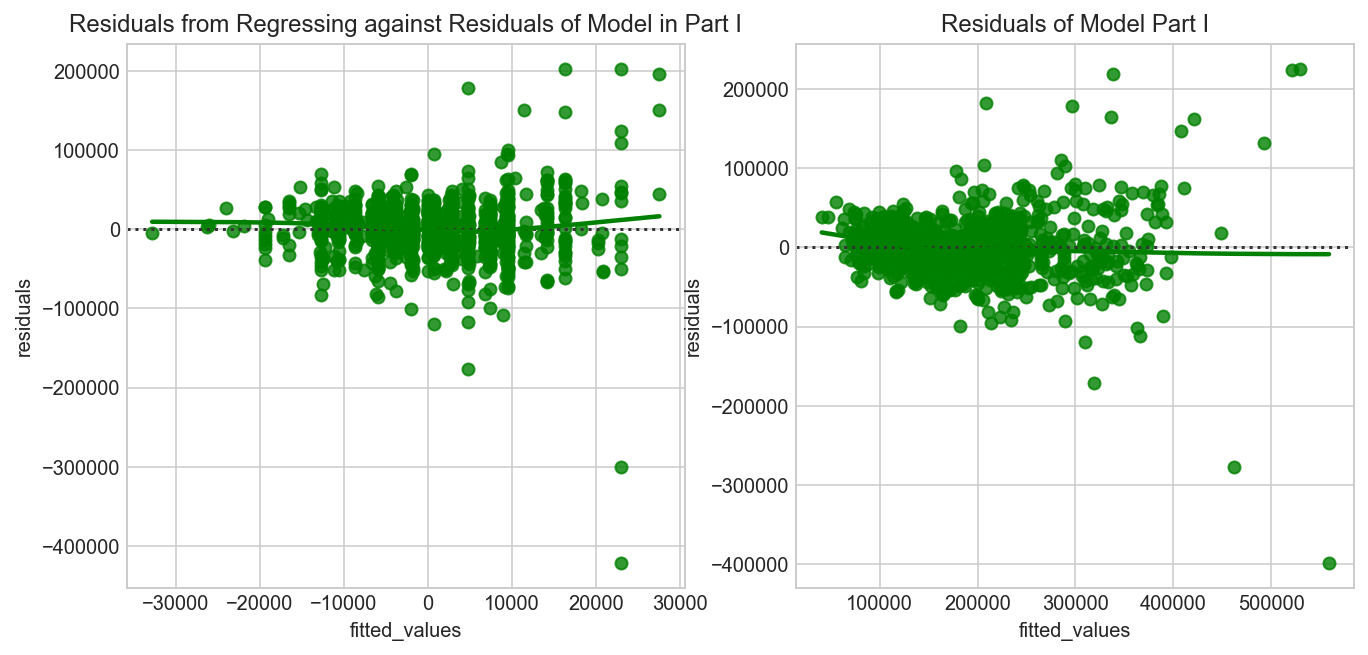

In [88]:
# 3.3 Least squares model stability check
# Plot the residuals against fitted values
resid2 = (model_sm5.resid).reshape((1278, 1))
fitted2 = (model_sm5.fittedvalues).reshape((1278, 1))
resfit_data2 = pd.DataFrame(data=np.concatenate((resid2, fitted2), axis=1), columns=['residuals', 'fitted_values'])

_ = plt.figure(figsize=(11, 5))
_ = plt.subplot(1, 2, 1)
_ = sns.residplot(x='fitted_values', y='residuals', data=resfit_data2, lowess=True, color="g")
_ = plt.title('Residuals from Regressing against Residuals of Model in Part I')
_ = plt.subplot(1, 2, 2)
_ = sns.residplot(x='fitted_values', y='residuals', data=resfit_data, lowess=True, color="g")
_ = plt.title('Residuals of Model Part I')

# From the comparison of the residuals, the lowess curvature line appear to be more emphasized, deviating from zero. There
# is a discernible pattern where outliers persist and the fan-shape trend (heteroskedasticity) appears stronger
    # This indicates that the variable features would lead to some overfitting, and the relationship with 'SalePrice' may
    # not be linear. The base model, with only fixed features, appears to be a better one

In [89]:
# 3.4 Sanity check using cross-validation
# For sanity check, perform 5/10 fold Cross-Validation on Data to verify model obtained is decent enough

# Perform regular, standardised and min-max adjusted CV. regression.
lm2 = LinearRegression()

X2 = resident_pre2010[final_var3]
y2 = resfit_data2['residuals'].values

# X-validate with 10 folds, no holdout
r2_10F_2 = cross_val_score(lm2, X2, y2, cv=10)
print('Mean 10 fold X-validated R-sq Score:', np.mean(r2_10F_2), 's.d. of R-sq:', np.std(r2_10F_2))

# X-validate with 5 folds, no holdout
r2_5F_2 = cross_val_score(lm2, X2, y2, cv=5)
print('Mean 5 fold X-validated R-sq Score:', np.mean(r2_5F_2), 's.d. of R-sq:', np.std(r2_5F_2))

# The cross-validations yield exceptionally poor results, signifying there is little more to explain about the residuals
# using variable features

Mean 10 fold X-validated R-sq Score: -0.0249294838761 s.d. of R-sq: 0.0128524332136
Mean 5 fold X-validated R-sq Score: -0.0232289897755 s.d. of R-sq: 0.0196362314001


In [90]:
# Compare Elastic Net  against 'Old School' determined variables
    # Use result from 10-fold CV for a more conservative approach
    # Elastic Net found more than twice the amount of variables to use in explaining the residuals from the fixed model

# Variables from Elastic Net - 19 variables
enet_var_ft = ['OverallQual', 'OverallCond', 'RoofMatl_ClyTile', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace',
               'Exterior2nd_BrkFace', 'ExterQual_Ex', 'BsmtFinSF1', 'LowQualFinSF', 'KitchenQual_Ex', 'Functional_Sev',
               'Functional_Typ', 'FireplaceQu_NoFir', 'GarageFinish_Fin', 'GarageFinish_NoGar', 'GarageQual_Ex',
               'GarageQual_NoGar', 'PoolQC_Ex', 'PoolQC_NoPool']

# Variables from 'Old School' - 7 variables
oldsch_var_ft = ['GarageFinish_RFn', 'MasVnrType_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 
                 'BsmtFinType1_BLQ', 'Exterior2nd_WdShng', 'OverallQual']

# enet_var_ft differences from 'oldsch_var_ft'
print('Diff. from oldsch: ', set(enet_var_ft).difference(set(oldsch_var_ft)), '\n')

# oldsch_var_ft differences from 'enet_var_ft'
print('Diff. from enet: ', set(oldsch_var_ft).difference(set(enet_var_ft)))

# Since there are more differences in 'enet_var_ft' from 'oldsch_var_ft' than the other way around, we shall use the
# variables determined by the elastic net method
    # In part due to having more variables in case many are removed due to high correlations with the fixed variables

Diff. from oldsch:  {'GarageFinish_NoGar', 'GarageQual_NoGar', 'RoofMatl_ClyTile', 'Functional_Sev', 'Functional_Typ', 'Exterior2nd_BrkFace', 'OverallCond', 'KitchenQual_Ex', 'FireplaceQu_NoFir', 'PoolQC_Ex', 'PoolQC_NoPool', 'GarageFinish_Fin', 'ExterQual_Ex', 'LowQualFinSF', 'Exterior1st_BrkFace', 'BsmtFinSF1', 'RoofMatl_WdShngl', 'GarageQual_Ex'} 

Diff. from enet:  {'MasVnrType_None', 'BsmtFinType1_Rec', 'BsmtFinType1_ALQ', 'GarageFinish_RFn', 'BsmtFinType1_BLQ', 'Exterior2nd_WdShng'}


In [91]:
# Full regression list
# Use 10-fold X-validated elastic net selected variables as a more stringent criteria than from the 5-fold
full_reg_ft = final_fx2 + enet_var_ft

# Perform correlation test of the full regression list
corr_var = resident_pre2010[full_reg_ft].corr(method='spearman').abs()
corr_var_pdSr = corr_var.unstack()
corr_var_pdSr_sort = corr_var_pdSr.sort_values(ascending=False)

print(corr_var_pdSr_sort.head(50))
    # It appears that only 'Fireplaces' is highly correlated with 'FireplaceQu_NoFir'
    # This tells us that for the majority of the houses transacted, there are no fireplaces built
        # However we would want to preserve some form of information 'Fireplaces' might yield, therefore we drop
        # 'FireplaceQu_NoFir' as it would not be informative either
        
# Final regression list
final_regr_ft = [feat for feat in full_reg_ft if feat != 'FireplaceQu_NoFir']
    # Because a list is a mutable object, we want to preserve the full list rather than list.remove('element')

print(final_regr_ft)

PoolQC_NoPool         PoolQC_NoPool           1.000000
LowQualFinSF          LowQualFinSF            1.000000
OverallQual           OverallQual             1.000000
OverallCond           OverallCond             1.000000
RoofMatl_ClyTile      RoofMatl_ClyTile        1.000000
RoofMatl_WdShngl      RoofMatl_WdShngl        1.000000
Exterior1st_BrkFace   Exterior1st_BrkFace     1.000000
Exterior2nd_BrkFace   Exterior2nd_BrkFace     1.000000
ExterQual_Ex          ExterQual_Ex            1.000000
BsmtFinSF1            BsmtFinSF1              1.000000
KitchenQual_Ex        KitchenQual_Ex          1.000000
BsmtFullBath          BsmtFullBath            1.000000
Functional_Sev        Functional_Sev          1.000000
Functional_Typ        Functional_Typ          1.000000
FireplaceQu_NoFir     FireplaceQu_NoFir       1.000000
GarageFinish_Fin      GarageFinish_Fin        1.000000
GarageFinish_NoGar    GarageFinish_NoGar      1.000000
                      GarageQual_NoGar        1.000000
GarageQual

In [92]:
# Perform regression using 'final_regr_ft' - 1st Iteration
feat_str = ''
for idx, feat in enumerate(final_regr_ft):
    if idx == len(final_regr_ft) - 1:
        feat_str += feat
    else:
        feat_str += feat + ' + '

formula_final = 'SalePrice ~ ' + feat_str
        
y_final, X_final = patsy.dmatrices(formula_final, data=resident_pre2010)
regr_final = sm.OLS(y_final, X_final).fit()
regr_final.get_robustcov_results(cov_type='HC0', use_t=None).summary()
    # Drop features that are not statistically significant at 10% level - From less stringent to stringent as tuning strategy
        # 'HalfBath', 'Exterior2nd_BrkFace', 'GarageQual_Ex', 'PoolQC_Ex'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 5.001e+12
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:50:08   Log-Likelihood:                -14836.
No. Observations:                1278   AIC:                         2.975e+04
Df Residuals:                    1237   BIC:                         2.996e+04
Df Model:                          40                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.021e+04    1.9e+04     -1.064      0.288   -5.75e+04    1.71e+04
BsmtQual_Ex           3.205e+04   5895.255      5.436      0.000    2.05e+04    4.36e+04
BsmtQual_Fa          -7375.3331   3076.630     -2.397      0.017   -1.34e+04   -1339.343
BsmtExposure_Gd       2.293e+04   3847.715      5.959      0.000    1.54e+04    3.05e+04
MSSubClass_20         1.344e+04   1765.893      7.609      0.000    9972.107    1.69e+04
MSZoning_RL           1.744e+04   2100.524      8.303      0.000    1.33e+04    2.16e+04
Foundation_PConc      7970.3897   2011.120      3.963      0.000    4024.807    1.19e+04
Neighborhood_Crawfor  1.011e+04   4593.459      2.202      0.028    1102.519    1.91e+04
Neighborhood_NoRidge  4.615e+04   1.01e+04      4.575      0.000    2.64e+04    6.59e+04
Neighborhood_Mitchel -1.272e+04   3301.144     -3.855      0.000   -1.92e+04   -6248.057
Neighborhood_Somerst  2.388e+04   4162.605      5.737      0.000    1.57e+04     3.2e+04
Neighborhood_NWAmes  -1.377e+04   3137.163     -4.389      0.000   -1.99e+04   -7614.300
Neighborhood_Sawyer  -5781.0197   3359.788     -1.721      0.086   -1.24e+04     810.492
Neighborhood_NridgHt  2.428e+04   7847.351      3.094      0.002    8882.228    3.97e+04
Neighborhood_NAmes   -1.221e+04   2754.176     -4.434      0.000   -1.76e+04   -6808.556
Neighborhood_Edwards -1.685e+04   5329.756     -3.161      0.002   -2.73e+04   -6390.744
HalfBath              2461.3505   1988.976      1.237      0.216   -1440.790    6363.491
KitchenAbvGr         -1.873e+04   4047.055     -4.628      0.000   -2.67e+04   -1.08e+04
Fireplaces            4780.0805   2127.551      2.247      0.025     606.073    8954.088
BedroomAbvGr         -3534.3927   2299.921     -1.537      0.125   -8046.569     977.784
GrLivArea               56.6686      9.835      5.762      0.000      37.373      75.964
FullBath              8973.1381   2243.648      3.999      0.000    4571.362    1.34e+04
BsmtFullBath          5261.0189   2308.567      2.279      0.023     731.880    9790.158
GarageArea              37.9728      6.835      5.556      0.000      24.563      51.383
OverallQual           1.012e+04   1051.190      9.630      0.000    8060.987    1.22e+04
OverallCond           5326.5465    708.979      7.513      0.000    3935.613    6717.480
RoofMatl_ClyTile     -5.384e+05    5.9e+04     -9.118      0.000   -6.54e+05   -4.23e+05
RoofMatl_WdShngl      6.679e+04   3.07e+04      2.178      0.030    6633.041    1.27e+05
Exterior1st_BrkFace   1.582e+04   4157.980      3.805      0.000    7665.401     2.4e+04
Exterior2nd_BrkFace   4942.2932   7425.097      0.666      0.506   -9624.882    1.95e+04
ExterQual_Ex          1.972e+04   1.16e+04      1.707      0.088   -2940.376    4.24e+04
BsmtFinSF1              13.9244      4.002      3.480    

In [93]:
# Obtain new regression list
final_regr_ft_2 = [feat for feat in final_regr_ft if feat not in ('Neighborhood_Sawyer', 'HalfBath', 'BedroomAbvGr', 
                                                                  'ExterQual_Ex', 'Exterior2nd_BrkFace', 'GarageQual_Ex', 
                                                                  'PoolQC_NoPool', 'PoolQC_Ex')]

# Perform regression using 'final_regr_ft_2' - 2nd Iteration
feat_str_2 = ''
for idx, feat in enumerate(final_regr_ft_2):
    if idx == len(final_regr_ft_2) - 1:
        feat_str_2 += feat
    else:
        feat_str_2 += feat + ' + '

formula_final_2 = 'SalePrice ~ ' + feat_str_2
        
y_final_2, X_final_2 = patsy.dmatrices(formula_final_2, data=resident_pre2010)
regr_final_2 = sm.OLS(y_final_2, X_final_2).fit()
regr_final_2.get_robustcov_results(cov_type='HC0', use_t=None).summary()
    # Drop features not statistically significant at 5% level
        # 'BedroomAbvGr', 'BsmtFullBath', 'PoolQC_NoPool'
            # Unsurprisingly, any variables associated with pools in the house get filtered out eventually
            # although the elastic net regression deemed them significant earlier

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                -2.385e+13
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               1.00
Time:                        13:50:08   Log-Likelihood:                -14862.
No. Observations:                1278   AIC:                         2.979e+04
Df Residuals:                    1245   BIC:                         2.996e+04
Df Model:                          32                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -6.231e+04   8730.222     -7.137      0.000   -7.94e+04   -4.52e+04
BsmtQual_Ex           3.546e+04   5827.309      6.086      0.000     2.4e+04    4.69e+04
BsmtQual_Fa          -6082.2668   3332.516     -1.825      0.068   -1.26e+04     455.700
BsmtExposure_Gd       2.278e+04   4300.371      5.298      0.000    1.43e+04    3.12e+04
MSSubClass_20         1.183e+04   1689.494      7.002      0.000    8514.550    1.51e+04
MSZoning_RL           1.583e+04   2207.928      7.171      0.000    1.15e+04    2.02e+04
Foundation_PConc      8519.4012   1932.871      4.408      0.000    4727.357    1.23e+04
Neighborhood_Crawfor  1.068e+04   4797.600      2.226      0.026    1268.310    2.01e+04
Neighborhood_NoRidge  4.763e+04   1.04e+04      4.572      0.000    2.72e+04    6.81e+04
Neighborhood_Mitchel -1.171e+04   3204.291     -3.655      0.000    -1.8e+04   -5425.797
Neighborhood_Somerst  2.348e+04   4030.572      5.825      0.000    1.56e+04    3.14e+04
Neighborhood_NWAmes   -1.22e+04   3189.049     -3.824      0.000   -1.85e+04   -5938.865
Neighborhood_NridgHt  2.552e+04   7567.990      3.373      0.001    1.07e+04    4.04e+04
Neighborhood_NAmes   -1.023e+04   2134.322     -4.793      0.000   -1.44e+04   -6043.359
Neighborhood_Edwards -1.527e+04   5025.607     -3.038      0.002   -2.51e+04   -5406.516
KitchenAbvGr         -2.049e+04   4054.170     -5.053      0.000   -2.84e+04   -1.25e+04
Fireplaces            5261.3465   1965.848      2.676      0.008    1404.605    9118.088
GrLivArea               54.7132      6.731      8.128      0.000      41.507      67.919
FullBath              7761.4918   2164.620      3.586      0.000    3514.787     1.2e+04
BsmtFullBath          4806.1751   2383.613      2.016      0.044     129.834    9482.516
GarageArea              40.4241      6.603      6.122      0.000      27.469      53.379
OverallQual           1.098e+04   1013.537     10.837      0.000    8994.906     1.3e+04
OverallCond           5256.3484    699.023      7.520      0.000    3884.956    6627.741
RoofMatl_ClyTile     -5.019e+05    4.7e+04    -10.676      0.000   -5.94e+05    -4.1e+05
RoofMatl_WdShngl      7.201e+04   3.14e+04      2.291      0.022    1.04e+04    1.34e+05
Exterior1st_BrkFace   1.801e+04   4343.030      4.147      0.000    9490.039    2.65e+04
BsmtFinSF1              15.5936      4.580      3.405      0.001       6.609      24.578
LowQualFinSF           -77.9247     22.955     -3.395      0.001    -122.959     -32.891
KitchenQual_Ex         2.82e+04   6107.074      4.618      0.000    1.62e+04    4.02e+04
Functional_Sev         -6.4e+04   4795.183    -13.347      0.000   -7.34e+04   -5.46e+04
Functional_Typ        1.266e+04   3229.805      3.921      0.000    6326.808     1.9e+04
GarageFinish_Fin      5449.7824   2112.247      2.580    

In [94]:
# Obtain new regression list
final_regr_ft_3 = [feat for feat in final_regr_ft_2 if feat not in ('BsmtQual_Fa')]

# Perform regression using 'final_regr_ft_3' - 3rd Iteration
feat_str_3 = ''
for idx, feat in enumerate(final_regr_ft_3):
    if idx == len(final_regr_ft_3) - 1:
        feat_str_3 += feat
    else:
        feat_str_3 += feat + ' + '

formula_final_3 = 'SalePrice ~ ' + feat_str_3
        
y_final_3, X_final_3 = patsy.dmatrices(formula_final_3, data=resident_pre2010)
regr_final_3 = sm.OLS(y_final_3, X_final_3).fit()
regr_final_3.get_robustcov_results(cov_type='HC0', use_t=None).summary()
    # The model has now appeared to stabilise

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                    -839.4
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               1.00
Time:                        13:50:08   Log-Likelihood:                -14863.
No. Observations:                1278   AIC:                         2.979e+04
Df Residuals:                    1246   BIC:                         2.996e+04
Df Model:                          31                                         
Covariance Type:                  HC0                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -6.339e+04   8666.507     -7.314      0.000   -8.04e+04   -4.64e+04
BsmtQual_Ex           3.541e+04   5822.295      6.082      0.000     2.4e+04    4.68e+04
BsmtExposure_Gd       2.273e+04   4295.039      5.292      0.000    1.43e+04    3.12e+04
MSSubClass_20         1.198e+04   1682.077      7.119      0.000    8675.429    1.53e+04
MSZoning_RL           1.592e+04   2212.478      7.198      0.000    1.16e+04    2.03e+04
Foundation_PConc      8621.5079   1932.279      4.462      0.000    4830.628    1.24e+04
Neighborhood_Crawfor  1.044e+04   4758.047      2.195      0.028    1107.402    1.98e+04
Neighborhood_NoRidge  4.747e+04   1.04e+04      4.561      0.000    2.71e+04    6.79e+04
Neighborhood_Mitchel -1.154e+04   3204.853     -3.602      0.000   -1.78e+04   -5256.504
Neighborhood_Somerst  2.361e+04   4027.016      5.862      0.000    1.57e+04    3.15e+04
Neighborhood_NWAmes  -1.207e+04   3191.622     -3.783      0.000   -1.83e+04   -5813.338
Neighborhood_NridgHt  2.558e+04   7568.426      3.380      0.001    1.07e+04    4.04e+04
Neighborhood_NAmes   -1.007e+04   2135.119     -4.718      0.000   -1.43e+04   -5885.580
Neighborhood_Edwards -1.541e+04   5042.233     -3.057      0.002   -2.53e+04   -5522.258
KitchenAbvGr         -2.053e+04   4060.502     -5.057      0.000   -2.85e+04   -1.26e+04
Fireplaces            5291.8467   1970.334      2.686      0.007    1426.308    9157.385
GrLivArea               54.8426      6.723      8.157      0.000      41.653      68.033
FullBath              7789.4230   2164.080      3.599      0.000    3543.780     1.2e+04
BsmtFullBath          4854.5918   2390.410      2.031      0.042     164.918    9544.265
GarageArea              40.1021      6.568      6.106      0.000      27.217      52.987
OverallQual           1.104e+04   1013.285     10.896      0.000    9053.236     1.3e+04
OverallCond           5236.7069    696.105      7.523      0.000    3871.040    6602.374
RoofMatl_ClyTile     -5.028e+05    4.7e+04    -10.708      0.000   -5.95e+05   -4.11e+05
RoofMatl_WdShngl      7.187e+04   3.15e+04      2.284      0.023    1.01e+04    1.34e+05
Exterior1st_BrkFace   1.815e+04   4333.424      4.187      0.000    9644.238    2.66e+04
BsmtFinSF1              15.7503      4.566      3.449      0.001       6.792      24.708
LowQualFinSF           -77.4869     23.015     -3.367      0.001    -122.640     -32.334
KitchenQual_Ex        2.792e+04   6117.365      4.565      0.000    1.59e+04    3.99e+04
Functional_Sev        -6.36e+04   4810.584    -13.221      0.000    -7.3e+04   -5.42e+04
Functional_Typ        1.304e+04   3206.968      4.067      0.000    6751.023    1.93e+04
GarageFinish_Fin      5497.4118   2112.639      2.602      0.009    1352.689    9642.134
GarageFinish_NoGar    4713.6500   1917.105      2.459    

In [95]:
# Evaluating the results for ONLY variable features
#
# On average, every 1 unit increment in the following variables have a positive effect (raises 'SalePrice', col.1 & 2)
# on the house's valuation, or negative (col.3 & 4), holding other variables constant:
# 
#  [Positive Variables]     [Marginal eff.]  [Negative Variables]     [Marginal eff.]
# _________________________|_______________|_________________________|_______________|
# OverallQual              |  $11,040.00   |  LowQualFinSF           |  -$77.49
# OverallCond              |  $5,236.71    |                         |
# RoofMatl_WdShngl         |  $71,870.00   |  RoofMatl_ClyTile       |  -$502,800.00
# Exterior1st_BrkFace      |  $18,150.00   |                         |
# BsmtFinSF1               |  $15.75       |                         |
# KitchenQual_Ex           |  $27,920.00   |                         |
# Functional_Typ           |  $13,040.00   |  Functional_Sev         |  -$63,600.00
# GarageFinish_Fin         |  $5,497.41    |                         |
# GarageFinish_NoGar       |  $4,713.65    |                         |
# GarageQual_NoGar         |  $4,713.65    |                         |

Within expectations, the better the quality and the condition of the house, the likelier it is to fetch a higher price. This is seen in categorical measures of quality in: 'OverallQual', 'OverallCond', 'KitchenQual_Ex'
	- Note that 'KitchenQual_Ex' is a comparison with all the other subcategories EXCLUDING 'Po' evaluations

Equally within expectations, with every square feet of completed basement, the value of the house increases. However, this may not be a demand side driven effect since it is a cost incur on the contractors' end to complete renovation works in the basement. Nonetheless, since this figure is positive, it appears that there must also be a demand to support the figure whereby houses with completed basements cost higher. This is one point to consider when renovating houses.

With every additional square feet of low quality finish in the house, the value of the house falls by approximately $77. This should be an indicator that the people of Ames are generally willing to pay a premium for better homes. Building low quality homes or renovations would be a poor plan.

When attempting to renovate to improve the quality of the house, exteriors with a basic layer of brick face improves the price on average by approx. $18,150 in relation to other types of exteriors.

It appears that roofs made of wood shingles fetch approx. \$71,870 more than the other categories combined while the worst kind of material to use for building roofs are the one made of clay or tiles, which fetch $502,800 less than the the other kinds of roof material.
	- This value however looks anomalous since the figure does not make much sense. A possibility could be due to the imbalanced nature of the subcategories found in 'RoofMatl'. Therefore any values presented here me not be accurate.

Whether it is a house with a finished garage or one without, the value of the house are relatively similar compared to houses with unfinished or rough finished garages. Therefore it is important to note that if a garage is to be added into the house, renovation works must be finished or forget building one to begin with (Go big or go home!).
	- It is believable that houses without garages cost relatively more against other classes (excl. those with finished ones) since the value of 'GarageQual_NoGar' is identical to 'GarageFinish_NoGar'.

Finally, for houses with a functionality rating of 'Severely Damaged' should be avoided if able to as these houses tend to be transacting at a much lower price compared to typical ones. Nonetheless, if the strategy of the company is to develop estates, then it may not be a bad idea to snap up these sort of houses and redevelop them, if after accounting for the renovation costs and still profitable.

In [96]:
# Checking the predictive ability of the full model on 2010 data

# 2010 data
y_test_final3, X_test_final3 = patsy.dmatrices(formula_final_3, data=resident_2010)

# Predict 2010 data
prediction_2010 = regr_final_3.predict(X_test_final3)

# Obtain Scores
print('R-squared score: ', metrics.r2_score(y_test_final3, prediction_2010))
    # While the R-squared scores are high, 0.873, we should also check for the prediction accuracy

# To evaluate how well the predicted values model variations seen in 'y_test_final3'
print('Explained variance score', metrics.explained_variance_score(y_test_final3, prediction_2010))
    # The model using pre 2010 data is well enough to predict 2010 trends

R-squared score:  0.873492259847
Explained variance score 0.873894835505
